In [1]:
import numpy as np
import pandas as pd
import requests

#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import linear_kernel

#Librería Spotify
import spotipy
import spotipy.util as util 

#Random
import random

#plotly
import plotly.graph_objects as go

#fuzzywuzzy
from fuzzywuzzy import process

import warnings

Credentials

In [2]:
client_id = 'Client_id'
client_secret = 'Client_secret'
user_id='User_id'
username='Username'
AUTH_URL = 'https://accounts.spotify.com/api/token'
redirect_uri="http://localhost:8080"
scope="playlist-modify-public playlist-modify-private ugc-image-upload"

Connection

In [3]:
def connect_spotify(client_id, client_secret, AUTH_URL):
    # POST
    auth_response = requests.post(AUTH_URL, {
        'grant_type': 'client_credentials',
        'client_id': client_id,
        'client_secret': client_secret,
    })
    # convert the response to JSON
    auth_response_data = auth_response.json()
    # save the access token
    access_token = auth_response_data['access_token']
    return access_token

In [4]:
def connect_spotipy(username,scope,client_id,client_secret,redirect_uri):
    token=util.prompt_for_user_token(username,scope,client_id,client_secret,redirect_uri)
    sp = spotipy.Spotify(auth=token)
    return sp

Get the information

In [5]:
#Function to obtain the features of a song.
def song_features(track):
    headers = {'Authorization': 'Bearer {token}'.format(token=access_token)}
    BASE_URL = 'https://api.spotify.com/v1/'
    track_id = track
    r = requests.get(BASE_URL + 'audio-features/' + track_id, headers=headers)
    response_features=r.json()
    return pd.DataFrame([response_features])

In [6]:
#Function to get the id's songs from playlist. 
def get_id_songs(playlist):    
    headers = {
        'Authorization': 'Bearer {token}'.format(token=access_token)
    }
    BASE_URL = 'https://api.spotify.com/v1/'
    r = requests.get(BASE_URL + 'playlists/'+playlist+'/', headers=headers)
    response_tracks=r.json()
    lst=[]
    lst = [i['track']['id'] for i in response_tracks['tracks']['items']]
    return(lst)

In [7]:
#Function to get the features of the songs from a playlist.
def playlist_features(playlist):
    songs = get_id_songs(playlist)
    df_features = pd.DataFrame(columns=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
        'time_signature'])
    for i in songs:
        track=i
        features = song_features(track)
        total=[df_features, features]
        df_features=pd.concat(total)
    return df_features

In [8]:
#Function to get the features of the songs from database.
def all_playlist_features(playlist):
    songs = get_id_songs(playlist)
    global track 
    while track in songs: 
        songs.remove(track)
    df_features = pd.DataFrame(columns=['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness',
        'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
        'type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms',
        'time_signature'])
    for i in songs:
        track=i
        features = song_features(track)
        total=[df_features, features]
        df_features=pd.concat(total)
    return df_features

I select a random element from a list.

In [9]:
def selectRandom(names):
  return random.choice(names)

In [10]:
def import_df(directory):
    data_songs=pd.read_csv(directory).set_index('id', drop=True)
    return data_songs

Choose your mood

In [11]:
def feeling():
    enter = input("What rhythm do you want today? Please choose from: 'Happy', 'Booster', 'Sad', 'Relax', 'Motivation', 'Energy','Dancing', 'Drive', 'Mix' or create your own playlist by setting 'Own' :  ")
    ok= ['Happy', 'Booster', 'Sad', 'Relax', 'Motivation', 'Energy','Dancing', 'Drive', 'Mix','Own']
    feeling=process.extractOne(enter, ok, score_cutoff=80)[0]
    return feeling

In [12]:
def ID(feeling):
    if feeling == 'Own':
        artist=input("artist:  ")
        track=input("track:  ") 
        track_id = sp.search(q='artist:' + artist + ' track:' + track, type='track')
        ID = pd.DataFrame([track_id['tracks']['items'][0]['id']])
        ID=ID.iloc[0][0]
    elif feeling == 'Happy':
        songs = get_id_songs('37i9dQZF1DXdPec7aLTmlC')
        ID = selectRandom(songs)
    elif feeling == 'Booster':
        songs = get_id_songs('37i9dQZF1DX3rxVfibe1L0')
        ID = selectRandom(songs)
    elif feeling == 'Sad':
        songs = get_id_songs('37i9dQZF1DWZqdNJSufucb')
        ID = selectRandom(songs)
    elif feeling == 'Relax':
        songs = get_id_songs('37i9dQZF1DWVIzZt2GAU4X')
        ID = selectRandom(songs)
    elif feeling == 'Motivation':
        songs = get_id_songs('37i9dQZF1DXdxcBWuJkbcy')
        ID = selectRandom(songs)
    elif feeling == 'Energy':
        songs = get_id_songs('37i9dQZF1DWYp5sAHdz27Y')
        ID = selectRandom(songs)
    elif feeling == 'Mix':
        songs = get_id_songs('37i9dQZEVXcOx8nqzmzXjg')
        ID = selectRandom(songs)
    elif feeling == 'Dancing':
        songs = get_id_songs('37i9dQZF1DWSX4baQVDQut')
        ID = selectRandom(songs)
    elif feeling == 'Drive':
        songs = get_id_songs('37i9dQZF1DX9wC1KY45plY')
        ID = selectRandom(songs)
    else:
        print("Please try again")
    return ID
    

In [13]:
def clean_df_features(df_features):
    df_features.drop(['type','uri','track_href','analysis_url','duration_ms'], axis = 'columns', inplace=True)
    df_features.set_index('id', inplace = True)
    df_features_clean=df_features.astype('float64')
    return df_features_clean

In [14]:
#Delete songs chosen as a sample from the global df
def drop_duplicates(df_features_clean,data_songs):
    for song in df_features_clean.index:
        if song in data_songs.index:
            data_songs=data_songs.drop(index=song)
    return data_songs

In [15]:
def concatenate(data_songs, df_features):
    frames = [data_songs, df_features]
    df_mix = pd.concat(frames, sort=False)
    return df_mix

In [16]:
def delete_nulls(df_mix):
    df_mix.dropna(inplace=True)
    return df_mix

In [17]:
def scaler(df_mix_no_null):
    df_mix_values= df_mix_no_null.iloc[:,1:].values
    scaler = StandardScaler()
    df_mix_scaled = scaler.fit_transform(df_mix_values)
    return df_mix_scaled

In [18]:
def normalization(df_mix_scaled):
    data_songs_mag = np.sqrt((df_mix_scaled*df_mix_scaled).sum(axis=1))
    ndata_song=df_mix_scaled.shape[0]
    normalized_data_songs=df_mix_scaled/data_songs_mag.reshape(ndata_song,1)
    return normalized_data_songs

In [19]:
def cosine_similarity(normalized_data_songs):
    cos_sim = linear_kernel(normalized_data_songs,normalized_data_songs[-1:])
    return cos_sim

In [20]:
def df(cos_sim):
    cos_sim_df = pd.DataFrame(cos_sim)
    return cos_sim_df

In [21]:
def concat(df_mix,cos_sim_df):
    songs_ponderate = pd.concat([df_mix.reset_index(), cos_sim_df], axis=1)
    return songs_ponderate

In [22]:
def prepare_dataframe(songs_ponderate):
    songs_ponderate.rename(columns={0: 'similarity'}, inplace=True)
    similar_song = songs_ponderate.sort_values(by=['similarity'],ascending=False)
    similar_song = similar_song.drop(similar_song[similar_song['similarity']=='1'].index)
    return similar_song

In [23]:
def select_songs(similar_song):
    best_tracks=similar_song['id'].head(50)
    return best_tracks

In [24]:
def prepare_tracks(best_tracks):
    tracks = best_tracks.values.tolist()
    tracks=["spotify:track:" + a for a in tracks]
    return tracks

In [25]:
def create_playlist():
    playlist_name=feeling+' Playlist'
    playlist_info= sp.user_playlist_create(user_id, name=playlist_name, public=False, description='This is a playlist based on metrics such as: danceability, energy, loudness, acousticness, instrumentalness.  Enjoy it!')
    playlist_id=playlist_info['id']
    return playlist_id

In [26]:
def cover_playlist(playlist_id):
    sp.playlist_upload_cover_image(playlist_id, image_b64="/9j/4QC8RXhpZgAASUkqAAgAAAAGABIBAwABAAAAAQAAABoBBQABAAAAVgAAABsBBQABAAAAXgAAACgBAwABAAAAAgAAABMCAwABAAAAAQAAAGmHBAABAAAAZgAAAAAAAABgAAAAAQAAAGAAAAABAAAABgAAkAcABAAAADAyMTABkQcABAAAAAECAwAAoAcABAAAADAxMDABoAMAAQAAAP//AAACoAQAAQAAAHgFAAADoAQAAQAAAHgFAAAAAAAA/+ENrWh0dHA6Ly9ucy5hZG9iZS5jb20veGFwLzEuMC8APD94cGFja2V0IGJlZ2luPSfvu78nIGlkPSdXNU0wTXBDZWhpSHpyZVN6TlRjemtjOWQnPz4KPHg6eG1wbWV0YSB4bWxuczp4PSdhZG9iZTpuczptZXRhLyc+CjxyZGY6UkRGIHhtbG5zOnJkZj0naHR0cDovL3d3dy53My5vcmcvMTk5OS8wMi8yMi1yZGYtc3ludGF4LW5zIyc+CgogPHJkZjpEZXNjcmlwdGlvbiByZGY6YWJvdXQ9JycKICB4bWxuczpBdHRyaWI9J2h0dHA6Ly9ucy5hdHRyaWJ1dGlvbi5jb20vYWRzLzEuMC8nPgogIDxBdHRyaWI6QWRzPgogICA8cmRmOlNlcT4KICAgIDxyZGY6bGkgcmRmOnBhcnNlVHlwZT0nUmVzb3VyY2UnPgogICAgIDxBdHRyaWI6Q3JlYXRlZD4yMDIyLTA0LTI0PC9BdHRyaWI6Q3JlYXRlZD4KICAgICA8QXR0cmliOkV4dElkPmFlOTk0NGUwLTVmMDItNDk5Yi1hNzRiLTc0NzkwMTk4NThhMTwvQXR0cmliOkV4dElkPgogICAgIDxBdHRyaWI6RmJJZD41MjUyNjU5MTQxNzk1ODA8L0F0dHJpYjpGYklkPgogICAgIDxBdHRyaWI6VG91Y2hUeXBlPjI8L0F0dHJpYjpUb3VjaFR5cGU+CiAgICA8L3JkZjpsaT4KICAgPC9yZGY6U2VxPgogIDwvQXR0cmliOkFkcz4KIDwvcmRmOkRlc2NyaXB0aW9uPgoKIDxyZGY6RGVzY3JpcHRpb24gcmRmOmFib3V0PScnCiAgeG1sbnM6ZGM9J2h0dHA6Ly9wdXJsLm9yZy9kYy9lbGVtZW50cy8xLjEvJz4KICA8ZGM6dGl0bGU+CiAgIDxyZGY6QWx0PgogICAgPHJkZjpsaSB4bWw6bGFuZz0neC1kZWZhdWx0Jz5QdXJwbGUgYW5kIFJlZCBPcmFuZ2UgVHVtYmxyIEFlc3RoZXRpYyBDaGlsbCBBY291c3RpYy9DbGFzc2ljYWwvTG8tRmkgUGxheWxpc3QgQ292ZXI8L3JkZjpsaT4KICAgPC9yZGY6QWx0PgogIDwvZGM6dGl0bGU+CiA8L3JkZjpEZXNjcmlwdGlvbj4KCiA8cmRmOkRlc2NyaXB0aW9uIHJkZjphYm91dD0nJwogIHhtbG5zOnhtcD0naHR0cDovL25zLmFkb2JlLmNvbS94YXAvMS4wLyc+CiAgPHhtcDpDcmVhdG9yVG9vbD5DYW52YTwveG1wOkNyZWF0b3JUb29sPgogPC9yZGY6RGVzY3JpcHRpb24+CjwvcmRmOlJERj4KPC94OnhtcG1ldGE+CiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCiAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAKICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgIAogICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgCjw/eHBhY2tldCBlbmQ9J3cnPz7/2wBDAAYEBQYFBAYGBQYHBwYIChAKCgkJChQODwwQFxQYGBcUFhYaHSUfGhsjHBYWICwgIyYnKSopGR8tMC0oMCUoKSj/2wBDAQcHBwoIChMKChMoGhYaKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCgoKCj/wAARCAV4BXgDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwDx2PXEc/vARgcVj39ybi4cjoavRaQkoVhJmm6raQ2sQCsC1bKyO5mWELECntC0f8JNOtctICTV+USEAxjNO5JnbWUZKkUw81fVJZTiRcVIbSPGCRmgClbyNH3FWEuPPO1vzqK6tXT5l5UVWyVOAcGmMu3VjsAeNg3sKrQod/PWkiuJUBBJNPikPmgnuaTAdcRyd1OKrCMZ7118UUUtnlgM4rnpLdnuWSMd6SYWG6WCLsDtXXqMKNvSsvTdK8rEkn3q1R+lJ6s0WwuOKUDHSk7UoOKaGKBR6UgzmgZ4pggY4PNOz8tIcd6XIxxQMamc0o+9QKFPNACseaaeDSnGaTqaAFPzUgGKAQDS9aAEBzS5IGKMYpe9ADTk0AcUhzmlPtQAGlycUhBFKOnNACDIzR0o6GgjNAC9aTjNAGKBy1ABgUcCg4zQcUBYTA60vBFKMYpMUBYBQeAaUUFgaBCKPWgdaMZPtSnrxTAOlIxzihjml4FIY080vajgihelAgxxmjtRmjtxQMASBQxG3jrShTimLxnNACqfl5o+lB6cdKd/DxQAAUhPagE0h60AGOaDRS0AIeaUUcdqXtQAdqSjmjPNAwA5zS9etB4HvSAZPNAhW4HFIOaG4FIDQAuKUn0pMUpwKAGjrQR8wNL1oxxQANgjigYxg0icGlPJoAOKUdKbigUALijtS9qSgBR60g5agUo4NACmm0pOaSgBaSjmigBc0hODQOKO9AC9OaCc0hNFACAnNLuNFGKAEZiSKGJFLnFGc9aAA8jNIRgZ70p6gdqauS3PSgBwPFHXrSH72KVsZ4oARRzSk0Y9KQnFAAKUikFB9KAFPSgdKQA0oHOKADPpSc96M7SaN+e1AB9KOaKWgAoHApKXtQAgPNKaXikzQACkPtSg5pOlACqeaGGRTTTh0oAOgoPJpD2oPBFABnk0owaD0pADQBDdR+dEyKeawZIJbXdnHNdGvD+9ZmuK/lEqKaIkYMi+Zlj1qq+AcYp8UrB8OasXTQvGNgG6mzMqKvcA5qQ3EhG1uAKSF9jDI4q9aWqXjnnFS9ASM0ncc0dq230yONCM5IrIuFCuVHahO4NWIc1NFGHxmolHHNLvKj5aYhZVCtigHLAdqFUysB3NWbqza3jDGkCIZ41CAg81AqilLE0uOOKZQgODz0rSe7Q2gQA5rPaNtuccUIcDkUhDo5Cj5FX7qdZYlBPPFZuQRnpV6xtROCSegosBVfGOKhbOeKutZkylVNV5YDEcE0CIgfWjrS4ooABSHrSig0ANoNFBoAbSd6eKMUwAUob2pKs29q0wJ6CgRVz1ozVie3EWQTzVY8GgBc0DrQOlBoAWl70gHFLjnFIY7OelJSqOeBSvx1GDTAQUhpM0ZpAHakoooAKKKM0ALnim55ooxQA7tSUCigBKKDRQAClJpKOtACqu6gjFCttNDHNACU/jFMwTRQAoGTQeKAeaGoASigiigDXhl+wqyOzFu3NVJm86TfIx+btmrFugunbzj81SWlkkt6I3PANGxa1KIUrwgJHtQGlh+Y5A9DXUCzhtuBHlfWmzaZFeAkEDHQUr3FytGPaaps/1ijH0qO6kFy+Ycg0mo2BtHwTxVe3kaGRcdzTQD1abO05z71at7XzJAJhjPpWtBZLPCJAuHIzSR+WsuJ1xjuaTkOxQvNPW3Bkz8o5qvFaPNh0X5M9avancLKwiQ5Q8VKs7rAsFuhwRyRQNIhupJI41ji69DTbaaO05PzStz61OsW1ish+duBVYWIjux5vIbkUh2N+3cTRhs1LwRgVFAqJHhRxTlOM4FJFDitAIBwKQE9TSkjFUmAufSjFJnPSl+tMBcCgAU05I4pyjjmgYmecUYGaABRigAIoBo5oJFACEDPFO4A96SgUAKD60h657UnWlK/LgGgAzxQBg5pGOAB3zTjkEmgBM0ds0uRigY20AN6mlIweKUYxmgYJoAbz36U4YpCMkelIcL0oAXbk80UE5FHagGL06UmfWgUpI6UAJnjikB55pScUg5OaADJ6UqjHNJ9KAeOaAFBNB5FGeKBnbQAn8NKBig9KOKAFJyKFPY0meRxRj5s0ABzn2obnpSk5pDxQADpilHAxSDpml4NACc0E5oJNGKAEbqKUgAijqaMZ5oAQKAadSHmjOKAA0goBzS54oAXPc0nWlA45ppPOBQApOKAaBxyaKAAmkNOApuaAADFKScUnJpc8YoAATigGkJpc4oAKKKKAE70tHeg0AB45o6jNB5FBxjFACAc0tLjC0meKAAUmecUgzSgA80ALg0dsd6M0nH40AGMUDANLzSGgBSc0vOKYfanDOKACkwT6Uc55pce9ACfSlzgYoxjik27ec0AHH40Yx060uOM0h4oAVeKb3Jpw5GaSgAGaQ9c07NHagBM80px170lBHFACc0ooBozQArHmgmig4oATPGaUYI5pGxg0HG2gAoxxSjG2mk0AKBSYpxHFJ0FAB9aBjbRSgALQAmeaH60E0fxUAOJ4pBjHNB4NAGaAG7eDSMAyFXGQadj9KC3HNAmrmNd6NHIS0ec1nHR5gCRjFdVk/w0zfnOe3Wi5DicZLbSx5DDA9ajhlaBsxmtTXbtd/lp0rGHHfrQ0QakWpEqd/Uis+Vt8jN61GQKM0Axc0hGRS9qQ5PFMRNZuElGa0tSYzQA+lY8Z2uCavy3IeDaKm2pRQVSTgVesbXziSewzTNOQm4G4ZBroLaFIw7DgYptjSM9VDI8ZUce1ZEqESkAE10dmiTzPtPepItORZyzjIovYLHLiNzxtP5VZtZmhBQZBNbl9JbW7E7RuFYE84aXcgo3EOkEsZL881WdjJy1WWuy8e0iqp60EiGjOaDQBQADrQetO2k800nBxQAhooJxSDmgBcCl7UY4ooAbjHSpI7mROB0ph6U3vQA53Z2yxphpTSZpiCjFLSUAPXpTj1pininE0hj4G2vk066cOwwKhJzSd6ACiiigApe1JRQAmaKUUUAFJSmmmgBaWkFLQAhooNJQAtJ06UtKBQMTaetKcngDmtDTLVZ3+f7tW7qK1t3whBNK4FC1snmU8YqCaEwuQ1X5tRESYhHPtWa8rStukNNAItIetCnJxTyuKBDaKRuOlFAFiGRg+4cVr6VKgcyueeorDBOPapDMxiwvGKT1NIs7UN5qZ4wapPvtJMgkoabo8iLaBpnAPvSXl7B5bLuBOOOaSG2Qam7XKDC5464rLgtjMwAIDA9zVy31UJE8ZGc9Ky5XfzTJGcVZHU6GNbqGEKGTp/eqrdagphMcigSeorJF7cEY3Gi3Rrm4G896m1h3JY1kCmTGV681owanGsWCuCB1xV67SOCxCgdq5eXBY4p7i2Ln21nug0hwAe1a7X8TBe5ArmhgUqkg9aVh8xvvrCxgLj9KQ64pwoB/KsFjk5NJ1IosCkdrazieMMuamJDDiuai1X7NCEjQ5q9Y6mJF+YYY0tTRSRsKOOKUe9Zh1OJX2v6+tX4pUlUFCCKAuSbscUFqOrAU1wQcCmMUH0pcnFU7m/S24YjNS286zpuU0w3LGCBk4owKaTgULk5oAcKM9qBmjAzQADikPBpR1pxAoAacd6UnI5pMCjtQAdqM8YozxRQAMPloA2jmg8ijrgUAHQc0g5NObqKQUAG3nmkyDxSnmg0ABpOpoBoODQIXp1o4PSlC+tIRzxQMTBFHBFH1peKBCc4p2flxSUGgYEZFHGaKQigBSOlA60d6O9AAQc5FDDOKU00DJ60AKR6UUdKQUAGeaXNJkE8UpGBQADjNIDwRR1o7cUAGcCgfNQoo5zQAHA4pV6c0hwaUDigBCfSgdaOlGaABj2NGCRxQeTR0oAUHjFIMc5pSMUY5zQADpSDrS9eRQeRmgBpNOOCKQUYzQIUDijFGQOKOtAw96MZpMUp6cUAIeoFLgZ96MDHNJQA7POKb0o7e1LwcCgAAyM9qTFL0OKQigBMUuAKUCkOCaAAml4NIRSgUAJxmjntQOtHcUAHPejHrStSCgAJz9KQHHXpSk9qQZzQA7r06UhHrSk8YFH1oAQGg9cUuBSZ+agAUZNHelzjmkB60AHeg5xmg0Z4oEIKcBmk6ClAzzQMMZ6UYx1pDkniigAbA60gGT7UvejJLYoAXgUmBQRjNJnFAXDdQFJFBA60maVwFFL2pAcUoycelMAHNDEFuKO9K2KBCEepopuPU0uPSgYdKMjvRg4NJtHegAdgvNYWp6i8eVjA571r3LbIy3YVyN9cNLKQBxQjOTK7sztlzkmm4NHNLTZAgBpelKKB1oEL2oXk1L5JK5FRYKn6UgHyQsi7jios055Wbg9KaOnNAzY0WRGcBgM1oarcLBEQp5PpXMRTNE2UPNLPO87fOaSjqVzEkV5JCzGM8k1u6TqPmgLKfmrmhxT43aNgUNElcEzc19QWBUZz6Vi7CBkiujsCtxbgzenes7UTECVjAP0oiwZmAelP8psZxQgzIAavXRCwrt64pkGdJGydaQVOWLYBpkiHOccUAAPHAqJ+vI5p6yBDVgNC8ZJxuoAp4pdp7A0uMv0q5HIFThc0AUTuHUGjOKsXEofoMGq4HFACE8U0ZNOPXFKoOcDrQAw5zS4qfyJCM7TioWBBwaAExRil+lFACdKXPNFNI5oAU0tJSigABpCaUDmlKZoABzR2o2kUYoASgcUUUAB60BR3pccUlADwophxRmkNABSdKKQ0wHCnHkUwHmnHpSAsW9y0KkLUMrtIxYk5pF6UrYxQMYM/jRg96OaH5oAAcGrVuFIy5qoOlOXPrTsBPtQy4/hoqEkg0UhFiEx+aFk4H0q5LBEX/dn5apAArlvvU+2hkkOMkD3pXKLq2s8y4RiF9jVW6s5IOZGPNEV1Lay4zkA1dvrlLmEFiN1NA2ZxRBEG701clD2qMsQ2AeKNxxQIa3GeadDM0LZHNNJJpBQFy9LfSzxbG6fWqxUjrTFODT2k4+bmgBtOVcg4qaK1Mse4MAKRbd3bah+tAWI40ZmwKurp7Fck4H1q1a2BX+NfMqveR3HnCPOWPpSTGkVpLbZnqaiWORfmTdWxZNLGNrRlj9K0LKJSxLR4+oouNI5Zwx5frWroNw6yhMkipda05j+8iH4Vm6fM8FwoI5JweKfQa3OxYjqO9RSlhCxB5+tLG6uinHbmsLWbspIY0PFTFFSdjNu5TLM3mE8GtTQpwoIZuKxC2Dz1pVkdOFOAapkJtHVTajCjYzVq3uVlXK1xZyTySc1pWF3IpESc5NTsWpXOoUmjvxTYydgHelAOaaKHAc0ueaTmlIzTATHNKSBxSMeAKDwuaAA0vGKQdM0A0AID82KFB3GnUCgBPWgUEd6O1AAOtBxQelIOnNACigjmkxkcUvpQAvWmng807NHfmgBOCKAKaw5zS9qADvSmkzgUq80AIKXtSDv7Umc80AKOtBNHWlHSgBaaRjmlooAQc0o4+lBzSUALgE/LTSTkA0oGBmjOfrQAvbFIeBQaTJFACjkcUoJ6UCkHWgLi4ABpFNJnmlJ44oACMmgDJoFJyKAFI5pcUig5zQTQAvWikFHQcUACgg57UrcnigUh5NAC9KQg9qU9MCkX0oAQCndqQjmlagBMUp4pGGRS54oARhyPSgc9elK5ywoIoAPbtSDg0vRTSDigBevNBpDxQTQAvUUmKKWgBB1o70HkUD0oAUcUg6ClpOKAFY9KTpRSEUALx+NFJjK0oGBzQAo45ox3oJGOKQnAoAXFIRgUAUGgA7ClPakXrQcFhQAGg9KQ9aXtQAA8c0AHtRSk5FACE7aM5FAFL9KABeDTGzuyKcfToaQEjjIoAFIzzTS2ScdKa/Ck1SOpxKxV+CKLCZf3gdTQGGOK5q81JzJ+6PFW9O1XP7ubvUtCTN3GTRuwcUyN94DL0px5Oe9CKDNFIp4OaU8kVQCkCjbxmjFJkhCAaADnmmnJ6U1WKpljVSa+jhJLEGmTJ2M/WbySNjH2NY5kQxk4+arOrXSXMhKCs8dKDNsaSQRmndRQ3SkpCDPOKUcUmaWgRYhl28HpTZmDN8tQZozzQArjFNPTGaXrR2xQA3FOGMe9JS0AABoU4NLmjHNAydbuSMbFPBp1rIqyFpjmoKShBcnuHDSFoulQmRj1NJT1UYoEIjfNmrAlUjaaqnANJQBdjghLZZqhu441b5DVfB9T+dBJ70AGdp604SMvSo+9LQApJY0KRikpcUAHOadEwR9xpppMUAXn1HdHsVB9apsS7ZNNHWnCgBvSlpabyT0oAXFJSjmkI5oABzS7aAcUu7mgBBwacDzSgbjSMMUASyOCgAHNQEGp4nVTyKLhlYcUAV6KO1IOaAHdaQig8GjNABSGkJNLTASgiiloAFHNOxxSCn0gGCnAcUhwKFNAEwgYpkdKrMCGwauR3JjQqKgJLEsRQMiXrU4hYru5xSKFJ+bpWl9ogFrsQc07gVbaJZflPU0UtgI/O+ckc+tFIRErBTluatLK0sX7kY9xUMUcQTc55qYXqJHtVf0pWGU5Mhvn5NMILDINOkfc2fWmA0wFUUUc0UCA0Cg9KTIB5oACOaXtg80HFAjfPQ4oGTpvEeVcgelJDctESVGTUQyB3pGHIz0oAuWtxKZ/NYnArQtb1Xvt8oGAeCayUXdGcHFRbWAwCRRYdzp0vo4C0hwc5qzYXi3KsyAfSuSWRkXB5FTWV29tLlclfak0UmdiSGVlYckVyt8jW16GdcLniuhsrpLhAwIDehqhrzCRF3gDB7CiIPcke+WOy3dCRxXOySmeRnanTz+YgTsKr9OKqxLY4nuaReetBOBzSdaQixbxPMcJ1rodI0/ySHlHOO9c9bztAQyYzW5Yap5wCy4H0qWXE3FZSc9qbg7iQeKRNpX5egpwyBzQjQXp1ozSHkZFA+7mqAXrS9RimKc06gAx2oxijj8aQ5NAC0Dik+7QOTzQAZ5xS0HOaKADtSDlTS0DI4oARTgYpRRxSHPSgAPBo6nNG3vkUueaACikPJpRxQAn1oFBx3oBHagBB1pcc0AUi5zg0AO5HSjNCnBprPzgUAOzQaQZxQeaAYoozScCg4oAUcqaTtQG4xQelAAM5pT0pFPFLQA08Gl7Uj9qUZIoELgHmk3Y7UE4pAaBi5zQaAaARmgQoPGKOKQ00g0wHGgHFGDigHFAC5pG6U4HIpDyMUhgvApO9J0FKKAAnFLjNIcZ5peg4oAQ8ECkBy1KOOT1oXrmgA4zQTk8UHApBwQRQAv8Jo7ClIyaafQUAKeelJQOKAetADgaM54pBQelAhOlL0JNIvXmnFiTjigBM0Eig0nBoGHWlGe9JxSg5oEBoxmg9eKU9KBiEYFJ3pwAI5ppPIAoACcU49BQ3SkJ44oAOKCe9APHNHagQA5pc02lxmgYZpaaTgcUq9OaBAKASDQODzTf4jQMSd1X5iary3SIhYYNVNRiuJ3KR4CnvWNdQy2wIdifxp2IbLz64AWXYKx7uUTSlgMZqM89RzSEZ6ighsA208U5Tg5HWk+6ppYwD16UmJM6XRLlpI8N2rVBBbIrlre/W1wqVppqy4A4yamxqmaxFOJwox1qot5E6gbuTVlMcelO5QcmkZcDrQepo56mmBm6p5+wCDOO+K5yYTbj5mT9a7ZsbenWq1xaxzA8DNCdjOSucZj2xRW1caRJuOzGKpnTZhnjpTbIZRPSm1JIhQkP1pmKQCYpaKQ0CDFBpe1IaAAGn7G25ApgBJ4rR0+aLISYcUAZ56c0nareoQhGLR/dPNVAeKAEHFLnmihVoAcKKXFNNAC0meMUUmKADrQBRiloAKSlxRQA3vTscUAUpoAOMUlFKQcZoAYaBS5pKAHcU00pPpR25oAFq4jxeXjAzVVBuNTPbGMB85zQBCQM03BzUsoUgbetNKMFB9aAGgZNK6EUi8c0/zCwxigBgJFPVhnmlMWVyKixQA9xk8U0ihSQKmiAP3xQBXxmnYAFTfK0gUcCn3FuIwCjA0AVcZppqZB83PSkkC54p2AixRSnj6UUAJS0YooEKtLSd6UetAxCM06NCzgUh5p8J2PupAOlt2jwT3pmCeBU9zcmUAelRI20gmmApQjGRxULABsrV9p1ljwQOKoSdeKQCbjnjrRQDRQApycc8U7gdqTFLzjmgBCKTHNOo+tACHNAzQc5pw64oAQjikI5p+KMDrg0AOhQvIBjitV5YotqsB0rJSRlbK4zQ8jSH5qCi/dRRs+Yuc1nSI6uQRVm1nEY5yTVzzLbyy0u4OenFAjLQ4OAavW1hJcDIzVORW3llU4+lX7O+aNQMEH6UDNCHSEMBD8NUEen/Z3Jddy1LBrEa8NnP0psupG5cxoBz0zSVytCQ20UY82OQLjtWbqd79pUIO1aYsQVDTS4HoGrN1G3SNlMZyM1SEzMHBwasW9u877VFa1npaz2zMeG7VmTrJaTFUPShsmw6406aHnBIqqwKnBGKsLfTEjecilmKSrkDmkBWGB16U5M7wVOMU1gV4OafEC7AD6UDR02jXBkhIPPFaW3C9etZui2zwQZbHNaf8AD71JsIowKUcClBGPemjrg1QCj2pc4pBxQORzQAhBzTgDR9KXnFACZNAzSAZoxQAp3d6KO2KT60AH0pT0pKPrTEKBSZyaM+lBxjikMAAD8xpQM5x0pM7qToeKAFxSkcUnelbpmgENOaUYxQMnrSdKAFGc0gzmlDUL60AAXqTQAOtGfyo+lAAzcYFGcUh4pT05oAQjPNLjIpMntRnkUAKBijNB4NBxnIoABS0dqQc9KAA9KFNHejjtQhCY5pTQwpKYC0nGaX603oc0AONIxzSdelDcUAKMgUuMCgDIpOe9AC0Z4oAzS7fWkA2lAoGKUdaBjTyaceBikPWl7e9ADckdaUUE+tITQAFeaUkcCkzkY70YoAcQQRQeKQ0YB70AHvRnPSjPajHpQAUUq80gOSaAAUUfWk6GgAzg80daXr1pDkHigBeKUACkxxQDQAE80HpQcAe9HOKAAZpB+tO7c03vxQAq570hHPFKTRyoyaADIPFGMUAhulDEg80AFFJnNKOlAgwBRikIOeacOBQMQnPSmrnPNOwOtN70ADdDnpXN6zPE77QRkV0oOOvNZ9zpcU77+lO5EkcqvXNW4nh24kQZ9a2W0ZONpqJtEyevH1pNkWMq6itxGGjIzVVB2z1rRv8ATvs6/eJH1qvBArrweRQKwfZAYd/Wq6xFmyO1XmkKx+UOvvUafKNvUn0pjJNPj2y7524HrXQQ3cLkKjA1gvaTGLeM4qKGJ7dTI5bPaptcpOx1JcBhk0/d69K497+YyA7jj610FjeJJbgueaNUXzF53GPQVUnvoYTjcM1narqQChIj9awizOxLMfzqrEcx0MmsqhO05NVRredwI61jkc5pUTc3AFIlu4+4kMkheogalkXaMVEKBC4oxSZpc8UCFoxSA5o5oAAdpoJ5yKPrQaAJHuHdAp6CowOOaQA5paADgdKUUnelFACmm9qWkoAKMUGkFAC4paSgUALmkJpDSUAKDTs5qPrT41LnAoAeq54qRoGCZBprKY+Gzn2oLuBg5xQBEFPOabnmrMULSKSMVG0e1iDQBETRyaU8GkA5oAcPyq0pl8k5yVqrGNzYNdDYQIbZgcE0m7Dsc6TtJPenGRio9KlvYDFMwI71Bg9+lMC7p9sLj7x4qS9hS24XmqKyyRfcOKVneRfnOaYFqHMq7VHNItk7Ntwc1BbymJxg1omRxiRWH50DM2SJ43II6UqS7eGFWZ7hW7DNU2Ic0iRsrnORVuyjNwv3qqFTVrTpBG/zHAoGhl5A8LdDj1qFQScd609Ru45RtQZ9yKzoiBICaaAc9rKqbip21DjFas9w5t8YXbWUxyaBMSl7UnNLQIO9KOlITSZ4oGL9KcDSA8UopIBGpOTSjk80tACD2obpSnpTCaADFFKKKAH7aOlOzgUmCe1ABwRxUsSIy5brUWCOoIp8RBb2pgMY/MVHSrNlAJm+f5R71YS2gdN+/DL2q0BA8ChThs9qllJAum256SqKtrY2Yj2llz65qSC0haAYc7ql+xx8ZNFx8pgXtgkRJjcMPQVXsbdp5vLIIHrXUG3gHHB+tPS3iQgoqg+1DYWMefTltIw2Qaz7jYxU9B3rZ1qUoqgDIrn53WQZ6Y9KaEzobFrZowvl5qPVbXfGFt4yM96xIbiSL7h4rotPus2nmSHoO9TqiuhzjW8iyBGBzmtiHRz5AkjYbsVDdX8Ludqjd9Krw6hco45+T607iQy9t71G5YkCqvntvUSHpXTzy5stzgEkVixWqPG8kpxVLUGbGn3sUkAVOMD1rHvZDNIwVCaht51gchfumtvTHtnHQFz6ip2Dc5zY0bjepA96mt4JZQWjU7RXQ6hpyzgFQB9Kks7b7Nasg6HOaGwsc1JukGxEJI9KiRjDIAeDmursYbZM7SGkPrWdrNgiZlHH0oA1NOuPMhUVbGMmsPQW+UjJNbbHgY60mkjRO6HkUmQBSJknml4yBVDAGlBo6UgGaAADOTmlXnNNKkUoGBQAmOtKDxSEU4cCgBBSUuaXigGIelIcUuaQ4oEKBR2NIBxRjA5oAVeKMZOaOopBkCgYppWzimnNKM4oBAORRjBpOp4pxOBg0AIccYpccUYwKO1ACBeaDnNAyc4pMN3oAU9KbmnDmkGKAFGMUd+KMijigBetIODQOKDQITPNO7cUgpCKBoCOaAOKByaXtQIO9LxSDrQRzTACKQ9cUp4pKAFxxSHmlFIRzQAp4FIp9aCeKMDGaBi0dOaRetKSOlAg3cUY6EUnUUp4AxQMTqaM0CgdaQhwORTRyaCfShR3oGLjmjHNHNAJoACKQDNKaTk9KAADBo5Bz2pOnWl3bhigAz6UpOKAMcUh4I9KAF6igDk0Z44oHWgBD1p3UUgOc0UCEGeaUYFIetJigY44pAeaOMe9L0GaAAnmkNGMjNFACikzk4pR0pOAaAA4HSlzQcYzSDB6UAKDSMSOlJ0NO60CEzmgCg8UCgYdaCCKD7UDJoATFKDhaXjNMxQA70pC5zSnoKQYHWgTRj62y7OSKxYSIW3Bsj0roNVs1mXOTWK1tHGhLMaZkyKacSnK8VLYTIsyiTmqEv3vl4FJkryvWhgjtkZfIGFyKy9XmhEJQYyapWGpvt8t6p3zF5iSamKsNlXHPFXIEmlUCPOKrJGzn5K6jSoFt7cb8bjTbsETLXSJZQDnmoZdLnQEkE49q6sHYAR0rMvdTjg3RnBbFJMGrHMujR8MMU1WKnin3E5nkJPFRE02SOZix5pvY0vak5xxQAhpcH8KACavQRBojnrQFih34p1PlhMbe1M60CCijFLQAmKWiigAxRRRQAh60UtIaACigUUAFFJQaAF60YpF606gBuKWNtj5pSKSgCY3OSMiknmEgGBioT1oPHSgCVLkpHtFN3Fjk0iIGIpZF2nAoAax6UgpT0FIKYxRxyKt2V40BPeqnakGQaNwLs0pupOmKgmgMZG49aYjlTkUPM0n3vwpAK2NtMDcYpDnFNoELjJpcuON3FJS545ouMM+ppyEDrUZHNLQInV05qIn5iRxTeMUpOBQAuc9aM80hpKAHl2YYzxTcUHgUgoBi4ooNIelMQUUi0p60AKtOpoNLmkMDxSZpGNAoAUmkxRRmgA7UUZooAepwwOM10mnW1tJCjMpD+5rnoMCVSema6r7MHtleFirY7UmXFCyaZFKPmFZGpacYeUHHtWxbXRJEcvBHc1bmCuuCARQmxuJxByvcg1Ztldwdp5ravdMiYGQELWI7G3mIQ1RI97q4tgVJpYtUnHVqiuGMigtVTAB60rBcuS30zPu3VLDqc6MCx4qlGu84FP2bvl9KLBc25J1u7bHG7FYUyFHINOWV4m2oeabLI0hy3WmIbkAg1JLcOwCg4WoeKM0gHKSDWrYWKzEPIwA+tZKkj3qXzpQuA5ApNDTNO65kCQtkLx61Wu1mI24OPaqsUzxNkEmt6xdLyLGBuFCdh7mAsbjqhPpVm3trsfvYwQB6ittHigfZLGC3atFJI2UKoAB7UXHYxdO1QtL5VzwRxzxWkl3A7FdwweOtY3iG2SGZWUAE96p2FpNJKrKTtzTa6hcv6nG9pMZoCfWrFrcrd2RFyDnNaFxbh7dkYZOK5maRrVihHBNJagzetlhtIg6dD71YedEi80nCmsFbgtbj+6O1I1x9pVUY4UdqLDTsdBZ3CzL+6yOepqyD8xHesvS8fdUYUDNaaMN3NFykxepo5BoJ+bil3UxiHmlPSk70poAB0zSD5qXtim5x0oEKQBSHGOAaUZI5pCSO1ACA56g044FAYntQvOc0AHam8ml3c0oIxQMAeKTFGcml6GgBpOeKUCgDnNKetAhDwKByKO1H8NMBR0pabS0gFzmm80ucUgOaADkChTjrQ3Sl28UDAYzQRzQBnpQeDigBeKacYpc0cd6AEwBzS8daQdeelHf2oAcOKQ8UNzjFHUUAGaQmjpRigQUtJ2opgOBpOKQ0mM9KADOKXp+NKelN6mgYoxS4FIBSnkUCD6UlAFLSAKKBSUABOBgUqgmk7UoJxxQMTJzS5pMGigBT0pF4FL/AAmkPFAADzS5zSDGKO1AgNGKBSnpQA3BpwHrSA4pTzQMCfSikxS57UCEzmjpQAB1ozQMOvIpOTS4OaQk5oAXpQaXHHNJ1oEL2puKMHNLQMOtHSjNB5oEApAeaWlGOtACHNFBooADSj3pO1ITQAuRSA880cY4pcZFA2I5z8w7U3ORk0O4ReelY2pamq/LGeaTVyW7GnKyFSGYVgamI1GFbOfeqhnnmYkMcVBIWLYY5Ip7GbYABxikMfNPiibBYVIkUj9VouA2yjMsmwdKLyPypCop1tI1pP068Vp3dt5tr5qKC2M07jMi3maI5XrWnpYnmuPMfO2l0e1STIlQE571vxRpGu1EAqJDjoK3KYzXK6zF5d0Se4rqpAAuFGDXP69byNJuAJGBTiEjFpO9LggYNAFUyBCKntXRWxIMiocUhGegpDNOSCAjfH1+tRB8nYlQW5dRjGaU+Yjb9uBSsBYvLUxRh25zVEHNXrm982AL1Iqge1MQtFGaBQIM0E0Gk7UAIMk4FStGVXJqLkdOtSFyy4agBo9aSg9RjpSGgB1NNHaigAFLSjpSE0AIaM0maD1oAXNLTc0uaACg0UlAC5pc5pKAaAFpBTutKVwM0AJ2pKUA46UhoAD0pvcU40h6UABpKUGg0AJS0YpaAGmjNBFJQApNKKaKdQAtJQTSUABFJTs80maYCZpwpKU0CCkYc0ooNACAUoFJ3p+eKTGhhHepYY95plSRkqeKAFkg21CRg1M0jNwaiPXmgBpHFFOYZFFAGlpFsZ7kbh8orrCBGBgfKKytDG1CpGGFaZbd8uKm5okV7u3W4GU4PWqE+ofYl2PyRWhdyeRAzLxXI3s5uJSzetWkDZNe6lNcNwcL7VFaRNcTAAn8ar4P4VYspzbvuFBJo31ibeDORn3rIJycEc1oXN+138rnAqG7SNUXywCfWgBttKsXUZNSReWwd3ODntVQcAZHNKwOAAaQD2jypcGoc1YkVooAT0NV1XcOO9AgWjGTTvJZeTTehz2piD7pHetfTtNN0Nz5ArOtkZ5AQhYZrq7I/u1UDaahsuKuYF1p7W8hH8NSQGOzTzA+W9Aav69vW3Jwa5pefeqSuLY6Wzuo71WV8A0mDazDe2VJ45rn45GhbdHwauQPNdAmQk46VNi1I19aEU1orEjOOKytKvfLk8t+gNU7mWUsUJO0cVXOVIK9aq2hF9TuN/moWUiuT1Ak3LbvWpbXUniUAmqlxJ5spb1pJWG2LAHd9qnitaDTnIBYgCsqGXyWDCtA6hPNGFiBOBzihgjZtY4oeFcE49avIBsBrjY3uFmzzk11NizG3G772KVjRMtE4NB603PIzTmPPFNDAcdaKQ0tMQGkA70HOKUdKAAntSGhs5FHegYowBmgGjjFJQIcMUhxRjik60DDjrRwxoI7UYxQAH0pe1IaX+GmIQ5x7Uo6YFDEEUgoAMkGlLUA+tHSgBOCvvQRtxig9KDzikMG6UAjFK1IBQAKSOlKOvNGaMZoAKDQRijrxQIQ5xzRnijrxSj+7QMRO9GQDxSnAoAHWgBDjPNByDxQTk8dqWgBG4pQeKQjNAoABz1o6HilpB1oEA60MTnilNJ0oGFHagYJobqMUCDNA5oFO4oAaeKMUMM0UDA4NAyKCMYpRQAcmmjnrTulIozk0AGOOaGxilHNJigA4IoAFFJigAAFLjnNG00HpigBCeeKU9KQcUHmgELk9qB70dKU8igQjdM0gJNL1FFAxMkUAmnDkU08CmA4HJ5pDgdKKBSEBNBozSHNAAODSnrQvvQSKBgQM0MB0oNB6igBKUEUZoBoEJmjPFAPWgZAoGLuAHNJuA9aT7w96hluEh++RSE2JeAtAwHHFcjcIRK2Tnmty/1PKlYzWBLIzMSe9UZt3JImCio3IL5FN5oNBJr6Y0TDDnFWL+VIYmEQWufDMpypxUjSuy4Y5FKxQq755ORz7Vo2t5LZAxygFTxyKNHA6svPar1zZi5BLDFK99AGhkAEqHGeeKs2+oo7BR+tYdyzWh2ZytVVuSrZXg0WHzHZbxuAB681BNPDIWjPLYrAF9MUG3JarllEUheaX75zQtBNlC9t1EzYOAKZa2bzvgYxUNxK8krE1NZXskMgAPFNiNKPRf75/KmXlrFaoCOTVufUlW2JVvnxWbbyPeyFXNJDZbtrq1jQZHzfSor+RLllWEADHNZl7bmGYjtUUcjRkMDTETXFv5PWoNpxmpJJ2l+9SeYNhGOaYiI+1TW8TSuFFQ45zVvTpRFcAseM0gG3ds9uRu71W6mtTV51mK7TniswdaEIWjFHSjOaYCHigUpFMzzikAp6UL0paB0oAKQilFJQAgFBopRQAmKOaVhxxTcGgBaXFJjHNGaAFxQBRSigANKScCgdaVSM89KYFuIw/ZyTndiqbnLGnS4z8tR0gDJpCc0dqQ0AKBSmkFONACA0ZoAzRjB5oAQ5zSY4p5xSHpQA2jNLSUAFKKQCnAUAIc9qTFPwaQ0wEFKaQUpoEFFFLQMTFBozRSYApqaJwp5qEcUvWgCZ2UnNQPgninL70wj5uKAHqpIoohJDc0UAdFYXKSXJMXGe1bJPBHGa4vT5jDOCTxXUm5iWASFhkik1ZmqasRazMq2xUnmuSI5yemat39w085Ab5aqkYA5yKtEMM84qzDC0rBUGaqjDfd61raHOElCsKlsEWotHZowWwDTZIoo1KNjcK3928YHANc9rFpIswdcke1KOo2jPMDu+FHFaC2aGIAf6yrmkxo8HzjDY70l9LDb8ZG6mwsVZYo0gKT53Y4xWT5ToxZR8var9xeLcFU6c9aJGVUCDnNAmUHdiOaiNX54lWHPeqAB6AUCLFrdm3JG0GpV1KcSFuAPaqyROWAKGpJYBvAxijQaZNeai9zFtNUF4qeWEqQq85pBA44KkUARHrWrorLk7yAKy2Uq2GpAWU/K2KTVwRd1RFF2dh+Umqg6mjOWyTk0u4CmhMZijHFBPFAOO1MQgJPFWLO4a3ckAEe9RDjtU1vCZZFUDg0ijUg1G3ON6Yb6Vqw3UJA2EYNVI9GR4BkgNVSTS54WwjcUrJlrQ3wd+CCPzqT7pGa523e7ikCsrHFaK35VgJlK/WnaxSZod6QZzTInEnzDoakABoGKelGT0pMYzQevFACtximg048gUgFABjJpDTh1pMc0CAAmg8GlPtSHBpgHWlNJig9KBi5zSE4GKOlLwRQIQAYpeaQUuc0rAB4+tAyaReKcKYDW6+1IRk8U7HzZpp68Uhi555oAyaMZpDxQA7FAoXpSHrxQAtB4o700qcigBfpRScijmgBcZo+lFOHAoAb9KOtA6nNAxmgAA5ozS9DmkzQAoyaToaM8UmSaAF5zmg470uKCPSgBuOcjpSnmgUnegAoY8UHrS9qAEX3pzYxxTaXtQAlLSLxmgE55oAd9aaBil6mkXkkUAKo7ijJHWjvihs0Aw5NGcGgUnHWgBc0EUlK3IoASilHA5oAoAKXnFN6mlzQITPGBQvvQDiloGGRSEZFKRyKRqAFxxxRnaOaQZo+tAAGB6UHrS59BQR3NAAOBzSbSelHWjpQApGKDzSUH2oAMdaMUKPWlPWgBAKUdDmk6mgUCYgxWDr8bg7lY4+tbpIANUL22a7QgcYpomSOXVW25JpCPQVLdRPbSlGBIq7pYgJzMAPrQyDLHTJBpCcVq6gtsE3REVkjJJpCJoITM2BRKhhm2MOO9T6VLicBqu6zEuQ6DJPpSbGi9pzQCEHjOKq6nfhciI8+1V4YEWDc8gUntVB0Bc7TmhIbZHJI0py5yabjj3p8ilOopvOKZI+CbypAcZq9c33mxhY+PWszBzTsFaAHE8+9JjnNN6GhSM80wLkUYZNzMcVJbypDISp6VT84qpC9KjySc55pAWL2bznJqttpeRSKc9aAHCkNLik5zTARsmjvweaUc0mOaVwF5zyc0dvekNAoEGTxThmkY56VYtSh+V8YoAgp6BMc1JcxIHxEwOajZPLAyaAI368dKSlbrkUg5PNACikp2BjrTD1oAXrT4gGYA9KYMUdDkUAWZ4giZqr1FSNKSuDTOtACUAUpFKKBhinIpboKsWluJmyTwK04rVAdo5o2CxjrExyADQ8TqMlT+VdPa2aR8sM1O0MYBLLxilzDcbHGlSDyD+NIRireoyqZ2CDiqzMcDIpiGY4pKd2pMetAgHTNBOeKUUhFADgBkc1bWCMpljVEdaeC3rxQBIIWZiEHApkiFOGqSG5eLPemyyeacmgCE0gpc80tABRnBopCKAHBqaeTQBS96YhBS55pOwoNAC0E0dqQ0DDvSk0lAFAC9qQn0pQpzQy4pAJzSU7rQBQAq5JwOtFBFFAChalLySJtDHAokhaMn0qWzfDFPWmMiRUPB61ctYrdmVGOSfaqt1A0TknvU+mWzu3mdMdzU3GJqMEcEgEfeoLLK3CnPer2psuAQQWFP0iw81xMzDA7U3sNbnQWxzEuaJWiI2yYP1qE3kcUgi2n2rB1pnSYMpPPvSiU2dFEsXOzAxWHrNuCS+7JFVob10gI3fNiqm+WSQdSpOTVEt3GiJiMrnIpQ0mcHqK6C1tw0A2Yzis292xTBeM0biKkkjsAhp0cLxlXwCPrQ4/iFMM7bcUCuaJuDEFZo0xVe8vUmOVUA+1U3ldhg9KYR6UgZYiuNjjIyavPP5kfAANZadc1p2NkLzPzY/GgDPn5YetIkRY8mrl7p725OeR7VRDEZBoAsBI1AyavW2nwT4JfGayTyKIzInMZOaLAamp6dHbJuRyaq2dkbpCUPIqGSSZ1/e5xVjRrgwT98GjYdiIwSW8n7xMgVs6bcWzkLtAce1WmuYXk2OoJbisPUrV7e48xeFJyMUr3KtY6tTg8nin9e2azdJm8+3GeSKvk8UrFjiEJyVGRVW9hWeJmCjcKsgHFOwCMGmhFHTXBUqeo4q4veoobdInZvU1NwaBoQUo4Y0ZFBpjDrR3pOuKUDmgQd6XNJijvQAoOKTvRRj5hTADijNHekJ4IoGKMGgntSDilAz1oEKMYoAFIBiloAKSkyKU4oAOtGaMDFAApDAjigig80LmgBeBTenSnU0nigAbOeKUZwKFGKXFABnHWgHPSk9qDgDigBCTmlNHajIoADyKAKCR2pKAF600HmnDrSd6AFBFBxSUE0AKOaQcUYo6nmgAyc0pzQaQnigA6UpoFGeaAACgikzzS4zigBR04pOtBPNHXmgA6Ui8UE0oNACAc5oyaXNGaADHrSdOlL1oI4oAb3pTR0oHNAAVOKcp4po+9TqAG96dxim0tAg60DJpD1xSYzQMXk8+lA5NL7UdKADODQaKQUAKKM+tKOBTM5NADgBRjmkwQfpzQckZoADSikzmlPSgLATikHSg4ooAAQTRkc0hyOlA60AICOeOaVTgHHFLgZzRkZoEVbqxjmBZhk1y1/G8U5CjCiu071WutPiujlh2ouZtHFjkDJNOC9a2LzRvLcGAcZ+tWYdJSSIeZ98+9U2KzOcQlHyDV77apjCucmrN7ozR8pz9Ky57d4j86kUgJbmZZQADgCq8TbXDA5A9aQcUmOaBXLFxOJAMAVXHI5pcUCkIXcAMDrUm8bcHrUXGacRxQAhOKaRk04UcYoGCru4FEiGPk0+1cJJk9KffSq/3aAIM5FA4NMFOxTsFh4BboKd5bAZIOKfZziBskZq1Ndi4BCrj8KQGd3pD1pxU7jjrSYK5BoENxTs0lLQAHPapbeISNjOKipQ5HSgC5NEkA4bLdqpSMzH5ulDMW7nNIM0ALx2pKACaCKAEozS4yKQjFACjHGamJTZ71XpTQAdSaUU0Yp4xQAlBNWI4BIhOeRUDoQTnrQMdFO0fC960rDUURgJOtZHFWbWOOQ4c4oauUnY6kXaPEXBGBWbNqZlYon0qvKqwQMI2yMetZ8Epjl3Y70krA3cW4jZZvm71G2e4q/MBKvmGqksilMAc1RJEPQVKkBYjNQo3NadshuE44xSbAoTReUaiJqzeZV9pqrjJ+lAgpQaSigBcj1NL9KbSigBvPORSig80qjmgBabTiD+FJjjoaAAUd6aeDQTTEL2FBpBRQAoNKaQUtACUopM0ZoAUE5pSc0wmlBpDHA0tNBozQApPNFNzRQBfkMu3DqagCusgdRwK39WnjiUKEyfYVj+c20jb8v0pLUosQD7U4eU4RRzSXt8pXybb5R6is5iwJwSAaYfSiwhxJJ+dsmr+kXLJOFLHb6VnYpY2KOGXqKbVxo6fUpIo4i+BvP3TXPzTPMfnJI7U24uXmxvPSoSeMU0rAxQOcGtmGa1itsHaXNY+Pl600DnkmhgaKXrwlthODVOV2lcu55NAyeoppXJwOtAg3N68VLbKJJVU96iZShwadFJ5bg96QFvULPyAGBqj2zU1xPJN948CoMflQgF3HFfQn7LHh3RPEcfiMaxp8F41t9m8vzBnZu83OPrtH5V89dDX0t+xkBnxhj/AKc//a9TLYibtE9nk+Gfg2QYfw9Yke6n/Gq5+E/gQnJ8M6fn/dP+NeR/tV+I9c0XxDoUWi6xqWnxyWrs62l08QY7+pCkZNeFjx94xJIPizxB/wCDGb/4qpSbM1GTV7n2h/wqbwIOnhnT/wDvk/418kfHPTLHQPirrenaPax2tlD5Hlwx8KuYI2OPqST+NY//AAn3jAD/AJGzxB/4MZv/AIqvqj4J+H9G8U/DHRtY8TaTp+savc+d519qFslxPLtmkVd0jgscKqqMngADtT1juPWGrPkG3kS5HlvgE8V9k+A/hl4NvPBHh67uvD1jLdTadbyySMpy7NGpLHnqSc18sfGCzttP+J/iG1sLeK1tororHDAgREGBwFHAr7W+Gn/JN/Cv/YKtf/RK0Teg6ktFY+FNYMdv4j1CNECpFcyIijsAxAFPv3Fxa5J5FaHiLT0/4SHVGJ+Y3Up6/wC2ayzZESBS2FPqapG62GaHc7GMeK6ID5R61UtbKKBQy8mrmcjNK9zRC5wMV3nwU0qw1rxzFZ6rax3VsYJGMcg4yAMGq3wbsrXUPiRo9rf20N1bSedvimQOjYhcjIPB5AP4V7N8Y9LsPDXguXUPDtlbaTfrNGgubCJYJQpPI3oAcH0zQ30Mqk9eU6k/Djwf/wBACy/75P8AjS/8K48H/wDQBsv++T/jXyz/AMJj4m7eI9Z/8Dpf/iqP+Ey8Tj/mYtZ/8Dpf/iqXKzP2M+56H+0J4b0fw+dB/sWwhs/P+0eZ5Q+9t8vGfpk/nXj/AFr3f4CgeLv7c/4Sr/id/ZfI8j+0v9J8rd5m7ZvztztXOOuB6Vh/tEaTp2k61pMelWFpZI8Ds628Kxhju6naBmmnbQqE7PkZvfAXwnoWveELy51fTLe7nS+eNXkByFEcZx+ZP51wfxr0mw0Xx1LZ6VbR2tsII2EcY4yQcmvWP2aT/wAUPf8A/YRf/wBFRV5r+0Jj/hY83/XtF/I0luKDftGea96SlAJNJnFWdB9VeDPAPha98H6HdXWiWktxNYwSSOynLMY1JJ59TXzDrESQ6zfRRKFjSeRVUdgGOBX2J4AP/FB+Hf8AsG23/opa+Pdf/wCQ9qR7/aZf/QjUR3Oei227lHo1J1NKOvNKfarOgQ4rY8F28V34w0K3uY1lgmv4I5EcZDKZFBB9iDWMMZrf8Bf8j14d/wCwjbf+jVobJlsz1T4g/BOSISX3hBjIn3msJG+Yf7jHr9Dz7npXiVzBNazyW91FJDPGSrxyKVZT6EHpX3WK5Txx4D0Xxfbn+0IPKvFGI7uIASL6A/3h7H8MVmp9zmhWa0kfHKjHWlNdn4++Het+EJWkuI/tWm5wl5Cvy+wYfwn68ehNcaOlaXudUWpLQTGRQBRn8qBQUA4oZqDzQaBB2o7UucimgUDFFA5x6UA9qDkcdqAENKBjk0Ck6nFAC0lLjHSl6UAIaSnE56036UAKKTHNH86AKAFzSNyaU0nTpQADikxS8nrRgYoAXNFIDzSk0AGaCaQmjrQAg60p7UvWigAagHikxRgUAKMUdKQYBzSkk0AGaKBRxQIKQ5pOaXJFAwHSlWkApTgCgAGKM80gpKLCFb2pR0pozSnrTGC9eaTvS0DmgAPSgUGg57UAgPtSgYGaTtSdTQA6k9cUAnGKAcfjQABuOaOc+1IeTzTs4GBSATPNBo96CaAAUc0UvFACHjrQOaXNGaBCY59qTGDS9uKQjHNAC5oY8gD0pMnFISOvegBV9KQjn6UjAcYyBVZ72JJNhbmgTLZkA4PNUb82xU+cq1M0qBNwYH6GqUsaThpHYYHbNJEsw7025bEOPwqoRzz0q/DaCe4YbgADTb22Fu2AQRVEFKkNPIpNppCGkdKnUrs561DzmlAy2KAEPBNNIzzVqOAyE8gVDLH5bYyDQBGeRTSOlSDvxSFfWmMAKDxzQfegUgLPloIt3UmiJlRCABk1XjJyRmrUNm0qMynGKAIlkCNk802VtzZprjYxB5NM3ZNAD80hooNAhDQKDmjPFAAaVQWOBTTz1p8cnlnIoAGVo2wadvXHTmknlMpycCmdxQA7vSgihn4wBUeM0AOIFIaUZFSGM7C1AEHFOBpKOlAEttKYnyTwatT27TR+ZGKoKcuM1s292sMGBg0DMhkYdRyKQKT7Vq2ka3k7E8DNQ6nCsD7U6UwKYL9NxNSwug4cCokO0ggZoYeYeeDSAuZDAqp4qq0eCcUFJFXIBpN7AYIx9aAGmMqMmrNteGFSBUDSFhg9Ki+lAE1xJ5rbu9RKcUKpJpcYNABjPNFLnim5oEHenAZIFN704UATGECPPeoAM5p+84x2pooAliI6GrMjQiHAA3VQJxTSfegAPU+lIeaXNGaYgAoalNNzmgAWlNIOKCc0ALSUUGgBDSjpRSigBuaM0GigAoo70UAXJLySRh5hJNPMrlRlSRVbOTnvWhbaikaBXjQ49qRZRlJJ5GKjxk1f1KaGZQYRg96pRqSQO9BInJoHB5qV0MRG/vQSnGaBkZANJgGpS0YHvTltncbkGRQBCBnjNTxwgY39KiKbTjBz9KXzGxtb170MEjetLCKWD5CCahl0dowzr1q1osLiIEN+tXbuRwh24yPWkmU0cpJGzTbW4akni8v73XtU1zJmct0YVBNI0vLUyCMcnAqXZhcGok4PFTSRyBNxHFAEW0Zr6V/Y0GD4v/7c/wD2vXzQSQR1zX0v+xrnHi7II/48/wD2vUz2JqfCVf2t7SS68S6AYs/LaSf+h14BJYvCCZj+dfSH7UdlqFz4h0R7G0uJ1W1cMYo2YA7/AGFeC6ho2sOuDpmoE+1u/wDhRHYIW5TmzwSB0r7g/Zu/5Iv4e/7eP/SmWvjE+H9Zxn+ydQ/8Bn/wr7E+AGoWel/CTQrPU7u3s7uPz98FxII3XM8hGVOCMgg/Q0TJqao+YfjaCfi14mA/5+z/ACFfZ/wzBHw38Kg9RpVr/wCiVr4z+LkkVz8W/EMsMiSwvdkq6MCpGB0NfZ/w7x/wr/w1jp/Zlt/6KWplshT+FHxn4otmbXtTeI/N9pl/9DNc/IzSHy5PlYV1mvkjXdSKj/l5k/8AQjWRNbLKd2ADVrY6ktCLT2YLsJyKvMM1WhgER6mpyc9KLFHefA05+Keif9t//REle1/tC/8AJOZv+vmL+deKfAwf8XT0T/tt/wCiJK9v+PtvNc/D2aO2hkmk+0RHbGpY9fQVD+I5qn8RHyqAaU1eOjarj/kG3v8A34b/AAoGjap3029/78N/hWh0XR7T+y318Tf9u3/tWqP7Tn/Ie0X/AK9n/wDQq1v2Z7K5sz4j+1W08G/7Nt82MrnHm5xmsn9pz/kPaL/17P8A+hVH2jnX8U8fttQvLRDHbXdxChO4rHIygn1wDX0t8C7a31PwFFcajDFdzm4kUyzqJGIB4GTzXy+evNfTfwC1Kxtfh7DHcXlvDJ9olO2SVVPX0JolsXXXu6HjvxrhjtvidrMVvGkUS+ThEUKB+5jPQV798LdK0+b4e6HJNY2skjW4LM0Kkk5PfFeG/GSzur/4j6xdWFtPdW0nk7JYYy6NiFAcEcHkEfhXuvwy1Czs/AOi293d28FxHbgPFLIqspyeCCcih7EVH7iPm/xrqd/beMtegt726ihjv50SNJWVUUSMAAAeAB2rl2JZizEkk5JPetvxy6yeNvEDxsro2oXDKynIIMjYIrDI5qkbx2Ac0vegjHSkJ45plCEc5rf8BHPjnw5/2Erb/wBGrWCSTW94C/5Hnw5/2Erb/wBGrSYpbM+0h0ooHSisTzhksSTRPHMivG4KsrDIIPUEV418Qfgra3vm33hQpaXJyzWbnETn/ZP8J9un0r2iimnYqMnHY+GtV0y90i+ks9TtZbW6j+9HIuD9fce44qoK+0/FnhTSPFVj9m1i1WXAPlyr8skR9Vbt9Oh7ivnL4g/CnV/C/mXdkG1HShyZY1+eIf7a+nuOPXFaKVzqhWUtGec0YyKTk9KVWwMGqNwFGKBQwI5oAQDBpc5oHIo7Y70AAFGOaMGloADQOlJSZxQAd6dnBpM8UD3oADyc0E0meMUg9KAHCik70tAAaQnFGaCKAAGlJpB1peh5oASlzxRnPFBpgFB6UZ4pe1AhopaMY60ZpDDbmhuBigmjaT1oAUD5c00UpOKOKADNFJml4C0AAoxSA0YoAD6CgD1o6UvJoATqDQOOtBOKCM9KAF6g0L0pOgoHFACkcUKeMGjrSHimCFxg0g70DmjpQACkpeTR04oAQc0tIOlKOaACg0tIBzSADS44pD7UvagAGKb1NKOTSHk/LTAOQaDQeBz1opCDtSHGRxzS5xxSbsHkUALtDx4asDV9PZCZEPHWt8jYuetRzL58JRu9CZMkcYl3KmVDE043czKRuIFTXtg0MrEYxVMjGQabIFWSRDkNipXlZ1G45qBeTz0pc9RQIUYzzVmyKNJtaqv0p6MVOQKQie8gKtlehqttI61Ozyz4I4AqJ8p96gYfPtO01HgluetaOmoGbc4+WmXJTzj5QphYpoD5mKWXKnjmtSytUm5kODVa88qKQqOcUgM84B5pGyelTOik5FNKHtQAwAgitizlQwbAwBPWqVjA0sm3HPvVq40+S3yQwz7GlcZQutokIzmoSPQVdtFjMuLjI/Crep28UcAaHBFUmIx6UU09KcooYWFpBjNPjUM2DVuay2RBwR+dICkRSHilPBooEIFzTim3vT4U3NiluY9gHNAEdBGBSHpR1FACHNPEh27e1MIpBQAE0UAgml9qBje9O5HfikYGlzxTAsW921vnZ1NJNcPcHLdarjJpRxQBZjAWMk9ag3ESA9qGYkU3rQB0tg8HkZkAziqeoxRTH/RwM+1ZnmOsZCmi2uXjYnOR71NgbEkhdOCKiVcGrUtwZ+gpFhO3dxTERqwHFMY5NKBluKR129aAENNpaO1ACCnA0gpaAAmnKRimGgHmgBWppFKaSgBKUCko6UxCmmgUZpaAA0lLRQAUhpaKAEzxTh0ptLQAClApKXNACEc0UE8UUAa0FtBOPvqtJNp0aDKyKazMsp4Yj6VJ5khX7xNIotmyj2581c1XAEcnBzjvViwjim/1sjLTr61ijH7py1CCxUnkLsMnIqMCjHY0qnBoAQKe45q1a3klseBlakhmhOPMAAHtU0v2Z4jsPP0oGTRXdrJJvkQbj71X1FI5DvhQ/hWcAFJOK19Ku41QidBjtkUAMs9TNtHtdSKml1Jp4yFGAag1N7aXmIDP0qGG1lkhLJwB70WC5XZSzmhdpYIeDSxMInO/mrpihnj3IcNTCxYGnRiESBhmrFvCZISH6Vj5uUO0MSo96vRXhW32g/MBSsBALcw3mZB8lfSn7JPlk+KjFj/l0z/5Gr5iuJZ2Pz5xX0b+xmxYeL8kn/jz/wDa9KexnU+E+gdZ8R6HokscetaxpunySDci3d0kRYeoDEZFZ6+PPCDfd8U6CfpqEP8A8VXgn7W9q1z4l0DZ1FpJ/wCh14dbzpaOY5YlzjrUKNzONPmVz7sPjzweOD4q0AfXUIf/AIqvjv483tnq/wAX9cu9Mu7e7s5fI2T28gkRsQRg4YEg4II+orjdSmjkcNGB+FUDkHI4qlGxcYcrLlxYzRKGiywPoK++Phln/hW/hXd1/sm0z/35Wvg3TNTaIFJwGHbNfevw4Ib4d+GGHQ6Xan/yEtTIVXofH+utu1zUiOn2mX/0I1RI9KsawQNc1Jd3/L1L/wChmqw44FM6o7BQOvFGKXtVIZ3nwN/5Knon/bb/ANESV9V6lqFlplsbjUru3tLcEKZZ5BGuT0GScV8qfAz/AJKnon/bf/0RJXtX7Qv/ACTmb/r5i/maiW5y1VeaR1n/AAmfhf8A6GLRv/A6L/4qj/hMvC//AEMWjf8AgdF/8VXxaacelPkK+r+Z9waVrOl6v5v9k6jZXvlY8z7NOsmzOcZ2k4zg/ka8H/acONe0X/r2f/0Kr37LnXxN/wBu3/tWqP7ThA13Rs/8+z/+hUkrMiEeWpY8WHJpM/NS55pp61odZ9a/Azn4W6L/ANt//R8lfPPxY/5KNr//AF8n+Qr6G+Bf/JLNF/7b/wDo+Svnf4s/8lH1/wD6+T/IVnHc5qXxs5SlB4oApGGK0OkWmnrg0oOKRuRmgAPBFb/gP/kevDn/AGEbb/0atYBHArf8B/8AI9eHP+wlbf8Ao1aHsKWzPtIdKKB0orA84KKKKACg4xzWF4s8V6R4VsftOsXaxZz5cS/NJIfRV7/XoO5r5x+IPxY1bxR5tpYltO0k5Xyo2/eSj/bb0/2Rx65qlFs0hTc9i/8AG7/hCv7Qb/hHs/2xv/0j7Jj7P757bv8Ad4655ryoUoAxQBWqVjtjHlVhKDSnAobG2mMTJ7Uv1oXOM00/NmkMXBzTm6cUnajtQAnNL2oxikHJoAAaO1BFHamAAUg60oFHANIBQMmm9DS9elA5NABSdTSkYo70AHQ0p5pDmlBxQADFFIODmlPJpgGKKSigAOKAKMUgNAC9DmlLH0pCaC3FAhxOVpope1ApDYcUN92jFITxQIOhFK3JIpD1FL3NAxOlL1oB55pGPpQAgHNOpMUUABGBSClPSkzQACjvzQKOtACk0KM9aOAKTNMBxOKaeTQBSnqMUAN7UoPApw6UHGKAEoIoooAaRS0GgYoABijoaCBQOlAAcnmg0Z4oPUUAJ0IzQ2N3tQ/OKH6ADrSEyvNOqqxyOKyf7TnMhVFPtWnNY7+pPNOgs4YcZxmi6RG5iSpeTklwcfSqslnLgnaa65AgPtWZe3kUc/lEDmjmuJxscywKnDcU38a6KbTUuo96HBrPk0oopBbn60Jkmb2604OQAMVLLAIlOTzUHagRoRFGgJBAIqg5Jc56UKSBgE0g5PNAyZLhkQovQ023l2MS3NRnAo4pgSyTuzZQ4FRnLcseaAOeKnhgaV8LSYEKA54NSHEXzHmieMwSbR1qBss3PSgDRt7qOMFgPmxTYZzLclnb5c9Kpm3kHzbflpEOGY9KLDNhkhu4yVwGFZc0jqDGTla0LFUWEvuxWdcHdMxH3aAZAKkUU0YqRACDTuIT3FTRzFl2ueKrP14pwxj3oED/AHjjpTTxUu0baibmkAoYryKQkv1NAGKO9ACk4FFOCBhUbcHFACmmkU4Up6UALFHu+tDxujcg4qWF1BHrWhcOhtugzigZjnNKKVuaQLQIUcUdaUjApAaAA9aF5ooFAEyruU1Cy84NWrXBl2mi8hEbZoALW3eYYjU4pblWg+QmnWt69uuFUYqG4mMzFz1NMCFSRzQ2WpuSacHwKQDMYpSeKQtk0YoAUdKWkzQelAD0VWzmkYAHimDOetOHWgBDSGnMaSgY2g07FLxQKxHilxilNFMQlFFFABRRRQAmKWiigAozSGjFABRRiigCQjilUEjjrVuytPtKsc9KiKGGUg9qRRGCU9amgl/eDPNRSEselIpxQIkun3yZxiou1DEtQvvTGT2SLJMqt0Na66dGjgt0PvWGjMkgZOoqw9/OVGckA1LQ0as+mwREyM4C+may76eHGyIdKiurqSYbWJx6VWwAcYppAxUOD1rorWNpNPJBxXOY9K6fTuNOJJ4xQxoo2lgJ3y3rU17pbR4+z1Npjgl1zjritGJyDtc/SlcdipaaYrw/vPvfWqdxZxwzbX+7nrmt3GFzmqOqQ+bas3cChA9ByW9tLb7QATjivdf2RrU20vi44wrfZMfh51fOGnXrW77ZORmvpr9lO4W4HicqMY+y/wDtWpktDKqvdML9rCXyfFnh5u32ST/0OvFb21+27XUcV7J+11Gz+JvDxUdLWT/0MV5TYgi3UGhbFUl7piXGkuiblGQKzpoWjU7hXZ5yMHpWNrlsDFuWrTuU0c7xxiv0G+GP/JNPCn/YJtP/AESlfnxyABX1t4H+OXg3SvBmg6ZdzXwurOwgt5QtsSA6RqrYPfkGpmjGom9j5o1y8kTxTqoLcfbJf/QzWvayeZCGHpXYXnwL8Z6tqFxqVpDYm1vJWuIi1yAdjksuRjg4IrYsvgf4xghCtDZZ7/6QP8KTZrGpG1mzz1TSkV6WPgr4v/542X/gQP8ACqGu/CnxPouk3WpX0VqLa2TfIVnBOPpVJopTj3G/Az/kqeif9tv/AERJXtf7Qv8AyTmbP/PzF/M14p8DP+Sp6J/23/8AREle1ftDf8k4m/6+Yv5mofxGNT+Ij5b60vajjFJWljpPeP2XOvib/t2/9q1n/tPf8h3Rf+vd/wD0Kr/7Ln3vE3/bt/7Vqh+07/yHtF/693/9CqPtHMv4p4wcAAd6Q8UjD5gaM1Z0n1p8C/8Aklmi/wDbf/0fJXzz8WT/AMXG1/8A6+T/ACFfQ3wL/wCSWaL/ANt//R8lfPHxZ/5KPr//AF8n+QrOO5zUvjZyfNHBpAe1Lt4rQ6Q6CkxmlXrzQx5xQAlb3gHnx14c/wCwlbf+jVrC7Vu+ARjx14c/7CNt/wCjVoexMtmfaY6UUVynjjx5ovg+3P8AaE/m3jDMdpEQZG9z/dHufwzWCVzgSb0R1EsiQxvJK6pGgLMzHAAHUk1418QfjVa2Xm2PhMJd3P3TeOMxIf8AZH8R9+n1ryrx58Rda8YSNHcSfZdOBytnCTt9tx6sfrx6AVxfetIw7nTTodZFzV9TvdXvpLzU7mW6upPvSSNk/T2HsOKpiiitDotYKUDIoIpORQMFGTzS+1HbikoAQ0dqUUGgAApRim96UigAxSjpSUvakAg5zRnFGOaO9MBM0daX2o4BoAcBSYwDSE0HO2gQv8NJyKQA7aUcikMAaKOlKeBTAQ0pOVo6igUAJ2FITStRQADAFHFHeg4NAC544pM0vA4FJQAYB60tJjNLSBiY5obiijuM0AAOaOlB9qQjPWgB/GKQUmMUvagBPWlBxTe9LQAucmjIFGcUnXmgAHQ0mKctN70ABp2BtoyM0jdaAADilHApBxR1piF7UmaBRQMM0ZpKXNACDNKc0gzmlJoAQ0CjmkPNADuKQdaDxQpFAATzQM9e9APzU3J35FJgyjqd59nUnPz1hHVpzIGJ4+lb2o6b9qBcH8K5y5s5LZiCCR2qlYyd0bljqKzLtc81la2MThx0qkjNGdy8Glmnefh6mwN3J11KaNAqHiopLuV2BZjUBGMCgg9qCRzEsSSTSUUmKYhW6U3I9DUse3cN3SrMyweX8uM0DKRPNGaGAFIaAFzxWtpk0KKfM61lAcZqaHYVO480AP1F1ecsvSobZPMlA7VE55x1FSWkwhmDHpQM2rlhDabcCsMnmt1hHd227cOKw5wBIQOgpCYm89ATj60hPFNqUR7hnNAiMdaU0FcGigBOlFBpaAEycUZo70YoAO1IKdTT1oAXNJ1NLQKAAHmnNTQOaG64oAbuIPFSGRmXFMxzRQAuTQGpVxSkUATRqrqS1ROADxSA+lGaAFBFJkZpKMZpgPicxtkUs0zSHmoxRSYDs8UKOeaaBSE8UASSIOoqLrQGIFFABxTlIxTetFAARzS000CgBwopDQKAHUUUUAKKQ0tIaAGGgGlNJTEFFFBoASigUGgApR0pAaWgBKFp2KKAA0UGigC5ZSPGTtBApbmQNLz1rYW0WWzzEPmrHubKeM5ZSaSLK5brTO/FKwIODwaTpTEOAJo2tnkEVZ0+Hz5wp6VtajYotr8g+YUr6jSOd5B4rTtnt3t9kgw3rUWnxRzNslxu962H063eLhACB1obsOxzkwVXIBzUZQ9amuovKlZQvA71GHwuMVQmMHQitPR7vbmFuQazDT7YlJgaTEjYtnEWobT0NampQuYjNEeR0FYV2WimSVfat3T7r7VCAeuKku5W0rUBIxjueGFaUoV42HUEdqwNXsnifzYeD7Vc0W7MsO12y4FFuo9zJurd7e4ZtuVJzXsXwA+Iml+CY9aOq219P9sEPl/ZURsbPMzncy/3x6968/vYlmhOeoFYWn3Zs52VulN6ohxTVmeufGHxzpvj3WtOuNLtryCO1haNxdoikktnjazcVxOABxVSCaKX59wBqbzo1B+YUrW0LiuVWQ522rnNczeXs00rRkjbmtq8u4hARkAkda52dCSWQ5yatEsYYGJwgJp0ZMOQ6kGrlhOIQdwyafLby3jFgCopNiPqPw7+0D4WTSbK1On62ZIIEjYiGLBIUA4/ee1a5+PfhgYzYazz/wBMov8A45XyVbWstuchzWghcDLHIrJxIVGPU+pP+F9+GP8Anw1n/vzF/wDHKxPHHxj0DXvCWp6ZZ2eqpPdQmNGlijCg+5Dk/pXzyCZeEfBp8bTRjDZNNRKVGK1Ou+HGu2vhjxpp2sXyTSW1t5m9IQC53RsowCQOrDvXoXxT+Kei+LfCb6Xp1rqMVw0qSBp40C4U89HJ/SvFFlBYAnmpW4NVbW5bgm7iGlB9KTOetKMUyrHpfwa8eaZ4IOr/ANqwXk32zyfL+zIrY2b853MP7wqt8YvGmn+NNS0+40uC7hS3iaNxcKqkknPG1jXn3OaDRZXuRyLm5g7ZpuM07tzSUzQ9w+G3xa0Lwx4L0/SL601OS5t/M3tDHGUO6RmGCXB6MO1eWeNtWg13xbqmqWiSpBdTeYiygBgMDqASP1rC+lFSo2IjBRd0KTmgUYpMelUWBFKelGDQaBCCtrwZPDa+MNCubmRYoIb+CSR2OAqiRSST6AVjDrS0A1fQ9x+IHxseUyWPhBTGnKtfyL8x/wCuanp9Tz7DrXiVzcTXVxJPcyyTTyHc8kjFmY+pJ61EBS5pJJExgo7CUcUHmj60yhOhoJHalbGKQCgoOcc0DpzSk8UhHFAC/dGRSdue9L/DSY4zSACMUEHI9KM5IpTkYoAaOtOGT1pO9KeBTAbmgcUtIaLgLmjr9aB90mhTmkAHoaABR1PNG2gAwaT2peaKADtigHHSijPFMAzzzQSCaF680rEZ4oATJHSlFANGeaAEoxmg0CgA7ijkn2pDRzQAuAOtAz2oAz1o5HSkAE0dBR1o4xzQAZx1pOpo+tLQAdDmgsTSUvQUAApc03NLzQAE0dRzRSg0ANyDSg4oOBRQAA0DFITxQAaAFIyaRh0pc4oPNABjuKB70ZIpp5NACijjt1pTigYAzQAD3pc803JNKSRmmFwJoPbFIMUZAoAUnnmmtw1KSCeKjcnDE9hQK4rnLdaUAiqFrcGW4YZ4BrQznpQNCr1ppzyRTiCOaTJUfWkwY1mKrmqN5cW7AeZ1p2pXiwxbe9c9cMsvzZ5oSM2yxdC2YZjPNZ0h54poiLMcDNWbaOPdtmOPrTZBVzzTgMmrV1DGpGw5FRxNGjfMKVwIWRl6g4pFGTVm6ulkG1RjFVweOKAJGRQM85qMk/hTuW4pjBg2CKYCGgnIxSupAz2pg+U80DLEUZdOKhZSrkVfskCfvGPFVLlxJOSnTNAiLHHFJgEc0/YSDtFMIIwDSESRyMnCk4+tNfn8aRfvUp7UDEx607cVFPgTzDzSXEflng5oER5zSUDpRQACnUlGaAFpM4opQpPagBoOaXbmnBCBSUAJg0UpptADs0h5NGaSgAxSikooAcOKXNJ2pMcUAHWloAoNAB3oooAoAUCkNOxTTQAUmKWjFACYxSUppKADNOwcZxTfpU8BLcUARdaI8bjnpU4tizHBoS3KyYfgUAVpMbuKFzVq4t1XlTVXoaAHA0ZpBS0AGaSlooAaaSnEUhFMQlFGKB1oATpQeaUikxQAlKKO1KooAdSE0uKTGaADrRR0ooA7WyKC3UIeamlVWj+ZRXKWV88DfNkity11FbkFOhqOpre5gamoE52iqtaN1Az3+0dDVuTRmYZQ4NaXJIdEiPmhu1b90P8ARn9hWNpmbOcxz8Engmt5kVlJzwRWfUrocUZCl0WXIwa6C01ENCFcCsfV4vKuiF7mo7R1VSG61clcm5o6lAZAXjA2+tZMZVJPn5FbENwG054yfn28VikcnjmkBYu4wAJF+6arA/MDV20xLHiU4UetRzQxRyAowI60riJ5La4ltw+BtHvTrCa4iU+WuQKv2N5G0PlkjFXIZraL5VAJNK5Zlz3sxjKyKOazLed7eUslaWuMoYbR1rHJ71ZBd/tGeR9o78U64spFiMj/AF4qijFXGPWurswtzZbXIJIpN2KWpm6dbO8Ybd8vsa0o7WNj99s0+0t/sqsByDUkkS7S4b5vSkUUr60GEUc5qC9ngtoQgVS30qO91F1fbtJxWRM7SPuaqIZIbglydowaRbqVJBgkCo4ceaGbpW21pBdwDySA+KTQFm2kjuLXlsNisy6ea3ONwKn3qvcW9xaHAJxUSO8zbXNCQyWCWVmJR2B+tXY7+a2IE6kqe+M0+w0396JNwK1szW8UqBSBQ2UilvDsksZ4OOK0sEoGPesiK1lt7juU7VsR/wCrJNBQ3HrSgikzmlFAC5xS0lLmmAfWik/GjmgBfpTe9LzRQCDNHSjFBFAxaTvQKM0AGeaXOelITmgCgVhc0UUlAC0UUlAhD1o5pQaM0DA9KB0oIzR0pDDqKDxgUCjFAAPahsmik5NMBQRmjOWz2ooFIA6mjGaMUoGKAAYINJjFGKMjpQAUdqQA0EUAKKB1ooHWgBaQjHNBoHTmmAA5o4BoA5oYUAGT2pRzSUAGgBMc07pSZpM0AL96g8UY5pD1pAOIGKSjNFACUEUtFAAOnNITiloxQAgFByKMGlwTxQADpRmg8Gg9aABjxxSqRikOKBQAhPPNLmjg9aOKAEpaSigBaM0lFACnmgjigU3PNACnBobAHFBo7H1oAAcjFKTg4NIe1LnkZoAE5amsKQP85xRI7LFuAoENDAE5IBFR3T4t2II6Vzd/fTNcNgkAGmLqcpTY2TTsRzDrW5eK8P8AdJroLa9jYgZ5rkncl91PhkZJgQ1JjUjtmY7RTJn2xlj2qtbzboVZm5qvf3ieUyg80lqOUjG1K48+U+lVYj84HamsdzE+9GMGqb0MjZE8ENvwoLfSsqWQSSZ6CmZYjnpSdelSMtsTIAEUn8KnXSnkTeTj8av6TEFi3OOKbqd98pSKkncZi3UAiOO4qBQAOc0+SRmJ30R7SwDdDVkiLuU/LzmpzFIV3OABVl7WNAkkbg8cinztLLD0wopXGZjvnimd6cwOcUJ975ulMB+51Q5Py1FGcPntU88isu0CocYFAi0JUVDtHP0quwLc0gpfMwpGKAGDk0pFIDzS5pCBWKn5aGJbk0DJ6VLbbC3z0AQZ5xSjrV1LeJnO5gAelQTxLG2EYEUAQE80lOxz1qWKFpWAAoGRipvMUJ71YbT5FYen0pt1BFFH8pBagCvh2UkDioiMdamE7LHs7GoqBChcrmmd6cTTOpoAdiiig80AFJS4ooATk04cCkxS0AJmlNFFABRmiigBaQmjNFACA0tJilHSgBCaSnGkNAAKcGKnIpgp1AEkczKc1PcTiSMbfvVCNpGKBEDypoAiLuRyaRRnrSnOSDSZxQA4qQKbTg2RimmgBKM4oNGKAAHNFAFLQAmaTNLRincBOTRS0hoATFKDik7UUCHE5oHHWkFKaAEJyaKTvRQBOuN+GrY07T5GIljJx1p9zoxIV061Lb3ElliN1O0UjRFw2gMiueoq8G6dqrQ3EU4zu5+tTj07UirFbUbQXCbk/wBYOlUYbmW2by7gHaO/Wtj7hpjRRzZ3r1oCxi6zHHLCJojnjNYnlufmAOBXSXWmHDCI/QVTSQW8TR3CfjirIaKVjEZpcgn6VFcJ5c5DcCrlhIkV0COEzT722E8pZnXHakwESOCS0UK2GNUbm28lfvbqhkHlMVUnH1pmSepJ+ppWEIpZDleKuW90AQz9RUNoFaULJ92p76GJGHlHrRYZDeXBnfPaoQecdjSsjZ9qUpgUxCKPmz2q/YTXG9RFkqKdY2Mc5ALAevNdDbWSWyYQDHrUspIof2g+7y2HNX41DruJ61C0MckxGOfWmrDLatlTlaCileGJLwK6jFUZvIe4wOAeOBUmsyGSYPjFSaNBFMcyctVEWGy6PJgPHnaan02yuIJdzEhfrW4OAFHQUjn9227HSpTKsYutSkLtGCaw03buOuauXjNLOw5b0xV7T9LYlZX49jVXsidzT0hGFoN3WrsYAyGpI1CjA7CkB4qFuaIeTngikxzjtSYpeaq4w4o4pOKBQAvOeKWgcUlMAIwaMmkxzS0AFHFAFBoABmg5J5pRSCgAwB3oOAaMUEcUDDpQOuaQCndKADrQeKSigQUZo78UUAgxSmkoAoBh3oxR3o70rBcOKO1HajPY0x3FB4pM0h4NGM4oAOtKOKTODil6c0gFxmmjOeaUmjqKAEJoA5pQABg96CO1ACnNN70o4FIOTQAvehqB1oJ5oAMcUUAHvSnGOKYDaXNIp5pTQAZpQaTBox60AIOtLSGjqBSuAc04U09ad0FAATSA0D1pDQAtFJS5HSgANJSg4o6nmgAAoNB9KCKADvR/EKTPOKU8dKAEbrTsjFIOme9Gc0wENAHFB6Ui0AKOtKaSgdaACig9aSgY4Uh4oFGaQgoopSeKAEOTijHzAU0nnig5DdDigLgMKzGsq81ExgritQsADnpWfqEcEkJbI3ChEM525k8xiw4qEDPNOkADnB4zSCmzMbj060Dg5704DDCkYelIZN9rlC4BOKjaRmPzGm4G3nrTelADlNOUEk0wGgGgCfcApBqzpixs/wA/SqFPSQp0oA1rzUVRTFDWUZS2cnmojzknrQF6CmlYAY5PNIcdKtyW4WDd3qoAx+lAEsTNnbuOK2YrmKKDZJjmsIkj7tBZm6mlYC3cGHfujPH0qtKwY/LTFOG56VakaJoht60wKxAH1pd2eKQg880CkIKG9qfsyBUZGDQIQmlA5zQRzQoJoAeqjkk0zOD8tOHpSYGaBhvY9TinxRvJ05NXbXTxcJksBT0tmtJgNy7aAsZ0ieW2G61NaTsswwBitO9tIZYw6su/HY1nQxeTLhlJX1o3BG5PMDZFuA2Kxra3a4kJY/LmrM6+ZgITsqWCIxL8pplWG3unIsatGapx2LvGzDtVu488g4YUgmeKEqcZoJaMlxtJB600Dip5+W3HHNQY5zSsAoopDS9qBAKM0UGgA60U0migB1ApAKcelACUnelzSd6AFpKU000AOpD1oFAoAKWikoAUUZpKDQAZzUkMmzg1HSigCZlDqWFQHinbiOlNxmgBARiikPWjFACmgUgpaAClNJRQAUUUUALikxRmkzQAGkxS5opiCl7UlL2oAaaKDRQB3qSBwCnIolhRyPMAI96y9BaUxfP0961T3qUbFF9O2PuibAz0FXoQyqA1OByOaM+tMYE5zQMZ600HmjNAx+CTxVe9hinXDKMjvUwPORUExIU4oE0Vf7PhkUKhAPtVS406SME+YcCr0DlSSOlLqTKbUsT7cUyWcrKCrEdaYeFz3qQKd528g0xgwJG0/lQQN7Z705WbOScmkII4IwKfAhaUAUAKWbHIpoBYYHWrstvNI6qoAH0qaPSpklQ8daQ7FBY7iEhlLAVr2GrliI5ePetpIEMKoyr054qm+jwF8qSPxoWpSuPWRJJl2EVcyAcHkYrLexNs4dGPHqakkvtkY3Kc+woaHcfqdks8X7sc1i2ltcwz5QHArTg1dHcIysPwrTBUoDgc+1O4rFJL5UIWUYenTyLLEVQ4zVTUUQXcYUEkntV0WiNGMEg0hkdnYwxAM5DN71eUDPBwPSqQiKS43HH1q4OF4pNDSHg4Y49KaBk0idc5pwGM7qEMXFIc03J7U4E0wDtmhTmlzikHWgBaBSYA+tAoAdQaTtRTADRSnpTRQA7tTeppaBQACg9KBQaAAUUCg8UAL0ozSGgUABxmig9aXAHQ0AA6UUlB6UABNGfajtSj3oATtSkCik280AAHPNKT6UgpQDQAg96DRjJoPFIaEpy4pDx0oFACN1pRSdetKeaAEwcGhRil5pMmgBR1oJGeKDyM0nbNAAaWkxkZpc8UwFApDzSZzS0AAOKU8036UuDSAB15o4opuPSgBTyKVenNNBNOBoAD1pO9LSUAKenFJS89qDnvQAHHajNKOKOO9ACZGaCeeKDjNFAAeaKQ9aXPFACUo6Uneg0wD1oHSigUAApO9HOaXHNAAetFHeg8UAGaDSDPelNAB2pCMilpCcMMUARTSCNCTWQ2slXIxkCp9W81+AOPasMW8mTlT+VNIzky/LqxkUgcVmNLKWOWO01Pb2TTEqARWlFogYAMf1pNpCV2YJxSgiujGjRhtpNVNQ06OBCY85ovcT0MgNSE803HJzSH2oAtQW3nIWFV5F2kj0qe1uDCpHY1DKdzEjvSAYtKKAM0Y5pgJS5oPNJn0oAM4qWPmRTUQGRxT4CEkB60AX77cIlGOMVURk8sjvXQF4ZLVTKMYWueufLEp2dDSQEWMk0YxRz2oHXmmIQDLVOI1RM96aYwUJqPk8HpQMU4yaTbjmloLE0iQycUA880gHFKUcgkKaAFkx2pYzgU1SCMNkNTc44oAeSM0KuTzTACTSk4FMZpRShIsJIQapvcu8oVmJGagBJ70E/MKQHTWNpG0G8tk1FJGrTbMcVFo10MFZD9K1m8lPmJFSjQSK1iRACBTjBF6DFRyXUe3g1Wmvk24Bqgdi3NBGwO3FZ2o2LiHKUovjHHk96uLdJJb568UEs5WRHXh6YmScYq3fyrJIdop1iiENvpskpt1pMVPc7fNIXpUPU0hAKGpaaTQAhpe1JjJp1AAKQ0tFACUE0GkB5oAXBpDT9xIphoAXNJmikNADqWmqaUmgAzSUClNAwzxQKSgcUCHZwaDzSZozQAYxSZoNJQAtFAoNABRRSc0ALSGlpDQAYpDS0hFAADSikpQaYhaSlpKAA0UUUAd3HEsY2oMCngdjSNk9KhmuUiUFjyKlG1yx1HHakGSeaiilEibk5zTmkKjkUxjzgngdKRhkU3eFXcSMVl6hqWMrFk0BcvTXkUGdzDNVW1KBgQWHNYE8jyNl88+lRkHsDQK501vLFKu1GGTUF0jsjRkZFYdvK0T5yRip/7QkLHPIoE2XtKtRvYSLnFX7i2tIl3PtBrJt7l8Ex9aa4mu3wW59M0rCIL90aXEXSqyko2VODU11byQOAwqHABye9USWEvZsghzxW9p2o/aFCkc+tYVtEZvlReT3xW/pln9liHmAb8dqllRL/WgE560o6U1TQjQHUN96mtbROuCoNSMCMUgOKYiqdNtwd2wZFWlXCgY4FOBzwaRehBoAja3jMgl8v5hzTnBXnsaeGwMUHpzQBBdJ8u5eoqC2uPMyjHBFXQcqQRxWDfM1veoU4U9aANtRgU7krzTIHV41Oeak6n2pDE6LSjJJpMY60v0pgIKdSUUABHOaN2Til7U3gGgBxOOlFA5opgFFL060mDQACgnmigUAApD1FLQevFABig80c96KAE70o60lLQMCKKDQaQAaQdaBTuAM0CCkzzRSbhTAWjBzRQDmgBB1pxpABmlNAADxSZ55pO/FKRxzQNAaM0nNKOOtAB1FJSnj8aSgAFL1oHWjPpQAgyeKP4TTsgD3pvagBQeKSl6jijtxQAg6UdTQM0o4OaAEHBpSc0Ac0YGaQCdKOlLwaMUAJ0pRQetLjigBDxSdaKUcUAAzSHOaUGkJ5oAXGBSUpzRjigAxSGlFFAB2pBS0cUAJjmlxQRSUwDGKMYozRyaAEPNAU+tLiggigAxQRmikGaAF60meaUe1KcZ5oATPNBHcdaAKORQAEK/BHNM8iPoV5p4GBuFKxGAe9AWIVhWNsqNtK7991Q6hKYoCeMmuakvJiSAxx9aXKQ5JG5dagkJPzgtWfHJLelsZqrZQfaZQHJJNdJZWkduuF60NpBa5yt1bSxSHcpqt354ruJYI3yrqDnvWHqmmogLrgChO5LVjExke1JtbHAp46EelbGmpbmLMlDYjI8llTcRTMbq0tUljPyw9qzQdo96YAy7Rimgc0vJ60negAyc09PlO4800dOaQZBwaALk11viCD0qoRuAPelHrVizCFxv6UCK5zjNNBq/fJGCDGeKoigZIJfkK1HSCloEKelIOnNGaUUhDkGWHpW2ht4rQs2M4rEVsUrSMw25OKAGzsskhZKBG7DIUkUwDHAq9ZXSRDEi5H0oApgEHBGKQnqKs3MySMSgx+FVzQBGDzTsZoA5pc0DBSyuGU9KsSXcrgDJqDpSUASiR8HmpPLPl7yargkVIZmK7R0pgSecGXaasWMwQlGPBqhkD604OByDzSGS36qk2V6GoRKVUgUkjM5y9MUAnigQoOSSetGelG3FJ6CgQuaQ0tIaAFA4oo7UlABS0neloASkpTSUALmjtSUUAFFLiigBBkGnfhSDrTieMYoAaaM0hpM80ALSUUUxBQKKXFAC0YoopDEpCaUmkoAUUUoFGKACkpe1FACGmmnGkxQA2nCjFGKYhDQKXFFABRSGigDsE1OPcR/WsvVpRM/yNxSXkSLclEqpeW8sJB5INCRo2XdMvjCNp5q9NczTD90prnraURygvXVabcQyRjy8ZqWhoyJZriJv9IVthqa1W0l+YMMn3rXuoluIyjKOa5W8tHs5SASAfSmhM6CKyt2O8Mre1Siyh5ITmuZtbqWBslyRXSaZdfaFzSY9zC1iJYZNoXBrN7Zrp9WsvtLFhwRXPyRiNypPA4quhJo6JCWfd1WteSzVH8yMjd6VlaROsb7AeDW8pzg9ah7lpFeW1+1RnzSAfpWaNFYSZ3Db9K3gx3cgUrtkAYxVBYr2tskCAADNTYOc0uMUh470WGtA6Uo5poOetKeOlMBzDApFwaFyRzSgAUgAUDrS4pKAExSjgHNANDc0ACnmsvW4QyBgORWoMDrUN7GJICKYmZOkT5OxjW5wOlZWmW6oxJ65rV6mk9ylsJQR6Uh60vOKAEGaKTml5oAXOCKDzRn1pRzQAq0g60HjgUmeKYCnqaSjPOKMGgBc4pCcmlAHeloAQCg0UHpQAdaMcUdKO1ACCigUUDFpDR3pKQCjpSnpQelHagQgxQaWkxuPFABRnmlGVFNHJoAdnmhqSlPWgBMGlbkUgPNOPei4xAOKAfWjpSHrTACc0c0GigAGc0p9qTNBoAXtSUvam0AKOlGaD0oHHWgBTxSAd6U8mjpSAKWm5pSaACgChjwKSgANKPrSHmjpQAd8UHrSjFBoAO1DdqOtBoAXtTSeaWjFACCjNKKQigBc8UCkxS0xiAc0GjrS4pAJSg0ZpB1piAkZoOfwoIFLnjFAw7UmaXHGaTkGgBRSEUtB9qAEoJ4xQOaD0x3oAOduKz9QvPs+AK0PmPHtWNeWUtxO2elFyWZt3fSXBwMmmQ2ckpGVOK2rTSUiOZOa0hGiLhQKTl2JUSlp1ktuAe5q+eDmg/d4pMZNFiyOZ9kZb0rmdQ1CSZzGAcCupdVZWVqoPpsW4nHWi6REkcsiM2dgJNKDLFxkiutgsoIVPAyfasDVFVJWxijcjYo5J5JqQqrR9eRUZyelNAIbrTAd5JC5HSozwav28Mkw5GFqvcoI5Nq80AV8ml71JGmaWWMgnigCPHvR06VIqDbkmo+9AC7mI5NIOKKTvQAZ5pTQeDSUhC4opKXIoEHerVvAZASD0qrwaek7ICFPWgB0ylHxUXelLFzkmmlsmgBc80vamUZoAcKKbmloAWiiigBaCOKQUpNAySPbjmomxuOKTig4xQAE0IdrZNJR2OaBE7yKy4FQ45oUAUvU0AFFBpM0AOHSkxR2pM0AB4opCaBQAUUUUAFKBSUoORQA4U5yCBimCloATFLRQaYCGm4p1JSBiEUlKaSmIKWijNABRRS4pDEooNAoAUUZpKKAHUhpKWgBKKDQKACnUzvThQAYpCKUmkoAQiig0UAdDq1s3nCVM1c/wBZpygr82O4q1EyMpVwCfensYwgU4AFO5pY5K5tXSTp1rS0qwmjcSA49jV+4ltFG5ipYVHHqsJwpwopMlGmR0z171WvbJblccZqSK4WUfKc1Mg96C7XObutJlh+ZOQK09ITyojkc1otzweRTdgUnaKGTsZer3gjjZFyGPFc6xz+NX9ZJNyQfWqAGeO9V0JHxEphhnNdXp7mW1DHqBXPRQF9oAzXTWcYitlHtWbNIkg5FApV4oJqihM80p6igjoaOppiEGSadSHPalA45oATHFKPlFHSjOaLAKnNGcGkHHSk+tKwDj940hNB60mKYAaawLIQCKcRSge+KAKdpbvFKWc8Vc6t7UuM9TSdBxSsMDxSE5pR70tADRRmlxRigApR0oxSZ5pgKMCkyO1KcGkwKAFFHek6UGlcBTQOaOopBxQA4U00tBoATI6UopuOadRcAIyaUAUlKKYDT1oo70tIYdaTvSmkPAoAWkooPFAARmlxxQOaMcUCEAoPSlA4pKBh2pSeKSjtQAdqUc0lKOKACkHWl9aAKABjxSZpSaQdaYC9Wo68elK33uKQ0gDNHagDikAoAUcUZyaQ0pPHFACDrTjxTRSkcUAJilNGRR2oGJQOvNHY0gz3oCw5uelHakOTRjIoCwvGKOlAFKRQPlEHNBHNGKNuKB8oEUmKUc0YOaBWE70uKGHNOUcc0AkNHFHWnUgFAcolAG05oxnpRg55oCwEnINDdqGycUhHNFx2FPJFH3aCMMKDnNFxWD73NGKMYFA4HNO4rCUdqXFKaVwGDilA4zR3o6HFAhKUCg0tADTQKXGTR7UAN4/GmyvtXk8U58AZzWLrF5sXajUWuS3Yff6jtHlxmqUti8sYlzkmqVrG9xLjJJNdFvFtahG5bFDdidzEkhEKc/ePFQGPaQzEVfkglnbewOO1RzafMy5GcU7isI9/iHYgA/CqDtk5bqatLp02RwasnT9ibpO1ILFfTrYyyAgcVvS6ejxgADNR6REEBOK0d3B9aTKSMS70pUiyg+asVoJFkKkZNdpI6rHmSsqaW2ikLnaTVXE0c88Tp94EUwVfv7pZ2ygAFUAaCQIGKb9KdijGKAAIxFIV/OpFcgU0nPNIQgAFIRmnU3NAgHFBHNHeloASkIpaBQAAUuKXtRQAlFBo7UAApaQUGgANNpTSUALSZooxQAUUHilFABQBzSE0KeaAFcUgpTzSUAKKKSnUAIaSlNJQAUdKKBQAo5paUKSOKApPHegBKM0pUqeaQ0AITSZoNNNAMdml7U2l7UxCUUUUAL0ozQDS0hgaSlIpKACjvRRQAUuOKbn2pwoASig0maADNLSUUALRTTSigBD1opxooA62cPDNuTkGqd6lzI5MfSrVzeRodhILZqNb10JHOe1M0ZiSpKsv70NTZcP93jFbRu4J32XAAJ9aJNKVsGJvlNBNjO06Z0uFQEnNdSgBUE5zVGz0qO3bfwTWgBUloDyOKTA6E04gVHwDzTBoytY07zT5qnkc1glNsm09a7N+YyG6VzN1CXusRDPPaqvoS9zV0aJljywB4rSbPAqrYK0UGH64q4OgqCxo+Xiig/epe2KoADZGDR060mOaVhQAKcmgjmk70uKAENL9KPXNHSgBQTikPWl7UhODQApIFB9qDzQFxQAoFJjnNA4pWySKBhSAYNOIwKb2oAWjHpTTTgMCgQZpOaWkzmgYc0DnpQODg0q8HigQY45pAuKdnOc0UgGkelKR0penNJ70AGMCkxmnA0h68UDEwfagjijvSnAOaAEyAMGlABHNNfk5pwOVoAax54pQTQOO1KTQAMRSDNBAo6igAzSimj0pwoGJQTmlpO9AAKcKSk70AOJ9KT60bqD1oAMUZpAaM4NAC9KOopG6ilzigAoBoFAGaADHr0ozQT2oAoGKowcmkI5pevFDdOKAE7UE5HFAJxS56CgLCKB3ooxjrQSKAsAwelLg+1Iq56UKrFsZoKsBHNGSO1Kcq2KUblPTNF0NREwCKQcClRXZ+hxUohaoc0jSNGTIhg8Gkzg8CrBg4HY0CBh2qfaxLWHl2K5zRz7VYMR7ip7ewaY5HSiVaKRrHCTl0KOwE8ZpxB6VqSac0X3RmohaPn7prL6zE1eBmigimgjmr5tjt+YYpi2uc4oWIRH1KfYo4p2wsOM1rW2nCQ8ir/8AZYWPhazli4xZ008slJHNEEDpQgOMkcVvtpmByKqtZ7TtI4qoYuMhTy2cTJ5U8DilwTyelX5LYICBzUAiOcGtlWTOZ4Oa6Fbvx0ox371dFk5XIBqN7Z0FP2qJeDmtSscEZ5zSck88VJ5T5pGRy1PnRk6E10GY4oxzknikJZTgilIGMmq5kR7NoAC3SjHY0qg444FITtOM5ppkuAnXigg5p2MjjrSFTj3pk8o08UdqcQcUFcDmgVho4oPNHcUmOaBFDUXdQRHXM3GfMOSSfeuxlVcFmHSuVvBvuWEYpoykR2VwLeTcavy6gkjAmsp1IOJFxUeMVLQrnYWVzFNGAMbqle4RAQ4A/CuUsZmgmDZ4Nbl/iW1WTpxmixfS5pRyRsvy7c1n6ockKOM1h2l5JHcAZO3NdE0P2pUkzxQ9AWpLYrsiGKsNwwpEARQopXB3A0hlPVA3kEg8VyRYtKSxau3ni82FlHU1yF3DJBcMu01aIkQHGeKTA9RVq2spJ24UgU+90uS3UMaCSlnFGQaTB70mOaBC5ozSGkoAcKTFKopaQCdqSgg0CgQnelFFHagBaBRRQAUA5oFAoAMUveg9aKACkIpaBQAgFFO7U2gBOc0n50+po2jEZLdaAKo60opGO5zjpS4oAWg0lFABS0CloAaaOadSGgAxSHpQc0A0AWrdk2HfUZIDkr0FQ4J6UuT0oAleYvxxURNJjFBGTmgApKdikxQAlLmjFGKYBmkoNKtAAo5pzEZoxTSDSAXrSHilHApDzQAopCaKQ9aAFHBqTcm0+tR0mBQAppKXpQTmgAFGMUCloASiiigBCOaKWigC2jvLcKXPOatX8rRyqwxxVOBNzrg81NfxOjDJ60yi5P5c1sJUGHFXdEuvOTaTyKxrF+TGx4NaVhbNBPlTwaRSN0HHekOT9KYASRTzkChFB/CaTHPtSgHFNJ5pgK43DFQw2iRPvxk+9TCkGaQCquTz0pxxQGGKQ9aLAAHNBHpQOtBpgAHrS8nrSUUAB9aAc4xS445pvegBSKB70UEUAIc59qUgcGgdKVSQeaABj3FB6UHJPtSUAKKWkxxSE0AKWpN2TRmkoAWlHIpAKO3FADsUijmgHiigA780KQGo60uaAF7k0h9qTnr2pwxSAQc9aXNHFJQACgcGlpp60AOFNbmlFDUAJ7UuB0FJSn1pjEOaMU6jtQA1uKM8cUHqBS4xSATHc9aBS9qQDmgYYoJAFB4FAzQADmlwTRk0h3etAAetGaUAmkPAoABjrQBual9qTpzQANkU7Hy+9IOetBPNAAOeKXvQe2KQg0AKRg0UmDjmk6HigYp6470ZpWwRmjGRQVa4E8dKTIxz1p2OOaQknAxxSbsXGLYZOPmowfwqRIy2MDipjFkYNQ6iRtHDykVgD2p8aMTxV23sS/QVdTSH6g4rGeIijsp5fORlR27FsnmrK24XrWzb6YVI71fTTEZRuHNcU8YrnoU8t6swILZD1FWhYr2rZXTFH3asRWAQ+tc08Z2O2ng4x3RhHTlZRnNSR6aARwa6JLZOMipvLQDgVySxcjf2EF0MNdKRl6VIumeXygGK2tg9KUKKh4mTKUIroYv2Vj1UUsVmASSoNbKotDIOwqfbyKtEyzp8Tr8wx9KRdMhUnA4rVVcdKdtGOan28u4rRM2OxROQKlMQxjAq7tFG0VLqN7jTS2M9rRW571C+mqw561q7Mc0pWhVZR2YXTMUaRH1PWo30WMnd3rexml2jHNWsTNdSXGL6HOvYEKQBVc6S8h5GBXUeUuc4o2gdq0WLmhOEX0OYOhZxzTJdFCmupKjuKaY1Oc1axsyXQg+hw91pTKeADVOSybIG0/lXetbLnJGaabNOoWto5g1uYywUJHAyWr4xtIH0qJrPBGM1372McnG2qzaVHnpXRDMEZSy6DOGMRQ00qd2Mc12LaIjvkjih9DixyBW6x8TmllfY4rYSxHNIyOTgV1c2jfN8g4FQnRWALVrHGxZzyyuS2Oaxt4PWmMw7Vuz6U6xswGWHtXNNcm2mdblcema3hXU9jkq4GVNXZYYKR83Ss77LFHOZDjHvVO/1bEjLF0FZc99PLxk4rdHmSSRoawbeQfu+DWORgUpJI+c0L1qjJoEGXXPrXShTLp+0dhXMnIORWrY3ziBkNDGloZ4TbdbT611dkVFuoB6CuTly0pJODUlvezW7ffytD1HF2OwUc804gk8day7TUo5VG4jP1p13qS24yDmpSKNENjiq0trFLJvYZNVodUilAOQDThqMIOCR+dUTuXVSKJMhQDWTrVwGXAq411CU5YfnWJqMqO52nNJEyM5s02lbtSDg1RIu0mkCFjhRTi/FWNPkQS5k6UAQGJ0GWFRkntWjqdwjYWMVnA5oELk0lLiikIQ09FzTKcGIFACNSClBz1oUfNzQAtIKe4HGKbTAQ9aM4paQikAmaXNGOKKADmjNFFACc5oI60tIaAEHFHaiigAFLRjikoAU0UtFADc84paMc0ooAFGaTjNO3Y6U0gdaBh0o70q470mdpoEB96Q5oY5oFAAKdQBQaAEzSUtITQAhoBpTTR1oAkFBpAaCaAEJozSGigAooooAKMUoozQAUUZozQAUUmKSgBaUGkAzS4xQAUUhopgbOk2ZlmDNkAVo6lp5uCAnatGONI8BRinN96p6lpHKXtm9mQec4q3o14ZJQr1uXMCXAwwHSqMGlLDP5g/nTGkaTckFe1OGcc0g4GKM0FBk4pMZpevWg4xTASnDGKbjijvQAo60HrSDrRQAvelagUcUAIOaDwaCaM0AITmlAxRwaUUAIaTkmlySaOtAB/DSjPSjJxigkmgAPTFGcUjEjgUAZoAOtGMdaDkHFG3uaADig0UYoAAOKAMUClOaADmlNNzmlNAADSbqXGBQFBFACc/hSikIoB7UAOopOtAoAd2pp9qdnim0AKDQDzQOlBHFAxByTSjrSAgcUtABRnik6YxS9TQAjHkUZyaU0hJ6UgFPBzSHnpRjnmlJFACD3oxjvSE0tADuPWmjmgcUvvQMUU1hmlPNHSgBMYpSeKTrSlcUAJ1pRQWAFCkYoGkJ0NO5J4poYnJHands0FqImCWAPSlHJxShsDJFTQW7StkDiolNR3NYUZTeiIQueDTxGW4Fa1rpLSBi3ArTsNHUdRXJVxcYnp0ctlL4jnY7SRxyDVqDTHdhkHFdbFp0adqtrbIoGBXBUzDsepTy6Edzm49M2pgDmlh0kyPhsgV1CRAdqkwOwrkljZM644eEehk2umCKrgtwB0q3inFRiuaVWT6mystipHGQ3IqQICQasgDFLsyKycmw5iHHHAoTNTBaNtK4rjMZpSOlSKOKOKVybiYyKbtqTFJilcLjduKOtPoIobC41QO1LigUpFK4hMUYpaXHFFwEIpMZp3akNFxDTwRStRilFFxjSKKU9aMdaLgNIzSbAafRiquO40DsaQg446U80houFyMDHakPuKkxSECncdyI8dqRhngjipSBScU7lJkQRRxTSgwRUnXNRnKIS3QU4t7DWpB5C7WJAwB3rx7xtOJNSYIAAOOK7rxR4nS1jaG3PzHhvrXll9KbidnY5Jr3sBTktWeVmVRKHKiljnIpealWNmOBThbucbVJ5r1HNI+cWGnN3SIQM9asxWryYCrW5o3h6W5bzHQrH71vtpKxR8YVRxzWLxEb2R2RyubjzM5eLTF2jf1qvPYsj5jziullh25KDcPaoPs7kgsODVRqo5KuFlB6owIbWMn97kH6Us+moRlGNbrQI3DLg1S1COKKA7W+f0zW0Xc5JRsYRtJIvunjPrTZkdtoJJq1BDLM+CeK1YLBFxnrTuRY5oxspwMirsFo8mCMmruqQLEwKjirunyBLcHjbSuCMuezMURZ2Oe1ZjHDHnNaesu0hBTO2sknNUiWxT2ptO69+KYevFAhTgCk5BzS5z1pDQAd8mgdeKXFJ0oAdSd6TrS9KAClxSUuKVhWHJEzc0m05walilaMcjj6UwvubNACCigcnFGBuzTARqSnHryKSkAU2l4ooEAoPSgUHpQAgPNB60Zo70ALxRxRxRxQAmaKKWgAzSZoNJkUAPXhhmhiCeKByeKbjB6UDFwT0qezCGUK9JaMqyZk6VduPs4AaLr9aALlxYQ/Z96dcVgSLtcj0rTlvD9n2gGstyWOTQgDHFJUi8ikIx0oENBpaaRjrR0FACmkooUAnmgANJVjyk2ZzUJwDgUAJSUuKcqbhQAyilYY6UlABRSiigA7UlFIaAFopo6U71oASlFIacvSgAHFGaKkCgigGRkc0UpBB9qKYHaxN5kKsD1qYA4FctFfyoQvYV0NlcefED3pPQ0TLJFLnimk5bilzg0JlAWGaM0ECimIOtBFFLQAg6UhHpTjwOKTccYFAxDS9qUECk5oASl6Uh5OaXGaADrRik5BxS5oAMUo6U00DigBQeDQDzSUvSgAzzRQOtIBzQAvvS0nTpSYoAU0hyaXmjNAABSEelHNKMA0AJyDTqTOTQwxQAp9qXtSDFBNABSc5oz60c0AKwxSfWlHXmkIyaAFpOaB1xS9aADtSdqXFBHpQMAaM5OBQBRigA4B560p4FJjNLxQAmKOc8UFc0o4HFACNnIpabzS9qQAaTijPOKXFAACBSE0p9qMYFAxTQcYpKXAFACCg07ikHWgBMUAk8Ghgc/LTtrEdqC4xuG0GlCjsKesTMQB0q/DYuyZFZTqqJ10sLKeyM1QeQBVq3tGkHSr1vYO7HI5BrobDTQqAyVxVsWonq4fLW/iOdttMZ5BvX5a27SySLACg1srAoGABj6VKsa+gry6uMlI9enhYU+hXggXZgAAmrCKFHSpMU7AxXDKbZvohoAIpQPSnqOOKdipuDY3BpOafg0balsVxAtPGAOaACOlKenNK5NxOKUHNFKuKLiDGOtApSM0qii4hMUmOacR3oqbiuHQUhFOIyKUGgLjBS0p60tAXGAUuKWlpgNC80p6UDOaKADFGKMUYpBcQCm4px46UgGaYJiUUpyKOcUh3ADig0vakzxQAhptPpp60xiYopc0YoAZxQQKdQRVIaZDn2rL8SXZstMdh1IIFbG3DZqtqVnHqFuYpR8p9K1pSUZJsdzwm/ke4meRsksc0WenyXDgIhJJr07/AIQmzEucvj3NbWn6NaWKgJHk+4r1Xj4xjaJyfVIylzTOO0PwaSqS3I4PJBFb82h6VYw+dKkYC9sVp6vqMOn25dyMjoorkrp7vWIXlk+SBc47VnTnUqu8jsjRjFaIl/te3luvLtwsduvXHpWbqd+NQv47e0b5Bwcd65O9dlmZI2IH1rc8FQtLq0ZIJABya6501CPMZxxHPL2djrV01YIEygOazblrYTeWzhT2rtZYQ+AMYxXC+MNHht0ecSMJW5A3VhhqvPKzIxVGLjdIxtTuo45/KjwxNYmqRsn7xzyegqKETGU7AXYevNRX7T7szgj2Ne1HQ+WxNKybsQC7mj5QmpP7SmK4DHNUycmlU7WzVnmkst5LIMSMSK1dNYyW+3qtVI4YZEyW5+tWbSRIRszhaVylE0ZLNZbXbgZxXOTWckMhGDiuptZUYDawNSSRRufmApqQpROWisHdM4IFVpofJbFdVczQRIYwRzXM3bhpTg8VSM2VeppTxS8Gjk0CEFIevSnE4HFPjKgEkc0ARdD0px5pZGyelN4xQAUdqBRgnpQBNJMDGBjoKiXmhV9adGuGHvQAqgZ5pzBVIqy9vEEDFufrTI7Z5SSqnA9RQA6ZoTANuN2KpHrUkyeU+1upqI80mIO1ApMGl5xQIXNITQaTHPFABjmjvS4IFJ160AKKDSUuOKAEpRS9qKADr9anitWaMsRxTIGUSDd0rRub5UgCRgc+1AGXnYwpWbcwwKYxJP1oBxQBoi1RoMk81RxsYjORmkMrYxk4ppPGe9Ay55iCHBAzVeMKzgNwDTA2V5p0cW45oES3ISMAJzUUTAEFhxSOMHB5plAE0zIw+WmgDbUYFLmgAJx2pRgim59acPagA56Z4ppFTJGWHSmONpwaAGZ5qWIgA1EwzyKQZoAkbuKjxipUA70x/vUAIOlNNO7U00AFFAopiEHSnetNFOpDEFOzikFB5oAXNAYg+1NNAoAkZs0U0HtRTEXr2LyrjAFbWjyfusE4rK1Rj5vTmlgjuGC+WQB9aTNEzpweKXoMmseG5niYCVcgccc1rRP5qBl6UkWP3ZIpRSZFLgEcVQgAFGKSjOKAFamrwaUnNJQMUjPNGc0mSKBQAtBpBzS9OvSgBqnmnGkBGeKU0AJRRilzQAlLSck0uaACk3YpxpvFADi2OcUgHel7UhyKADNJS0E0AKKQ4zxRil2+nWgBuOaU8ilxiigBpApTijb70uB3oARu1Lmg4zSHigBSaQAk0dqBmgBSCDSik5pRQMKM0UhHNACgUhpOaXoOaVwAGlBFJkEUYoAUk0nNLSfSgAIpKME0oxQAZz2o9qD1pOlAC4xR1oPIpcYFAwxRjmjFHSgdgwM0FcsPSgDPzdqd94gLQ3Y0jTcthFGKngidzwKntbUsRkVuWViAR8tcdbEKJ7OEwDlqyrYabIeWBrbs7LYMHpVuKIBQBxirCKAK8etiXJnv0sPGmiGG1RTkDmrITI4oAqVQa4ZVHJ6m2w0JinAUtKKhsm4oWlwKKUCpE2KBQRmlHSkxmkTcUUtCilIOeKQgFOIGKTFLSEJijFKRRwaBXCgUAY60o5oAU0UppKBAKQUuKKQARQKU0goAXFBFGaAaAEHWl4o6GgjvQISgUUdqQxOtGKWge9MBOpo74pT14o70AMPWlpxFNPFMYYwKaO9KOelHSgY3jNBzTivNGKBjcUvaloppgRjrS4x0pSKQ9KQDTz3qrf3ItIWduuOKshMNk1Xu7RbnAcnaKqLs7spWucT/AGfd65fmWYkQA8ZrqZrOOLTDbomTtx+laUMUcEQSNQAKGXjkVu8RJtWL5jyO88NXa3mBE2GPBxXbeFtD/s+LfJ/rDXStEjkEqDj1pQAOBWtTFznGxEYxi7ojVfnAHNee/EJiLxN/3cGvRSMcjrWD4h0BNWXJJDAetVhKihLUKicos8ltdQWzui+3IxVfWdQ+3Sb8YHpV3xNpDaVeGF+eM+tYiJuYA96+kptNXR8zinUXuMi4oPzVcitd8m0An6Vp2+gXNwpaKM4HqKqVSMd2ckMBUnqkYcUbNIFB61fktNifvGpTp06XBQI28e1WX0i/kXOx/wAQaj20O5p9RqpbGfHcvav8p4qV9YmkGBmq13aT2+fNRhj1FVc4HFaxaexwVYSg7MmnneR9zE1Dy3NSxYBG/pT2wSAg4qrmFiDO3ilU4FaB04mHzSQB9aBarhfpTuKxm5OeaO9WrxEUYXrVYfdzQIKCKMgmgjmgAxU0a8VCOtPDkUASeQztxwKjlQxvsJpROwPHWmsxkfJzSAt6fD58wDHIFdRBFGkQTFc9pc0cOSepNbYuUK9aTKRW1HTY5EZ1xkVhNakZ9q3rm5LoVTv61m8qrFuT7VRLMsqQxFKSNuO9LMfnJAxUXegQEZp8QBbFaOl2qTvgkUzUrBoJSYxxQOxUnwnANQjGM0jZJ+agDiiwgIzSgjGKcBkgdquG3iMOQeaQinSVI8e0UwCgBAKUjPWjvQetAAecUhFGcUtADMUAcU459DShcjigBAOKvWxiWP5yM1X8sKnzHmoTyetAEk7KZDtqIdaUDBoxzQAZozQaSgAPWnoBuGelRk+tLmgDVDRJDgEbjWdL8xJpY1aTgHmnSxPGPnoAr8jrRQfelA4oAcoZulNcEHmno+w0khB5oAZ2oI5pR0pygE0AMxQRzUjgdqjP3qAE20tFGM0AGKMUUZoAQ8UdaG5opgKBzRRzRQI0NWkElz8pGBVnT51C7WYCssncSW60seM4zigtHSCR9vKZX1q7aYMfy1Bph/cKJACMVdVVUEoMVJaF7c0KB60mMjNC0xinFKRxSBe9DHFMQh6UZopKBjjR2pcUh6UAAoIzQvSlFACYFFLSUAgoxSCnUAIeKUUlFACHrSijikoAdSA0o5oIoAQmkxzShaBQAA5NHVsUDg0rfeFAC496aTSkUcDrQAgFLiiigA6GkNKaTvQAEUYNLmkyaAFooANB4oAWk6mlHSkB60AKfak7UCl7UDEpccUDFGaACm55p3FHFAB2pppc0daQCDJNLml6UgPPNAxeaAKXOelIeDQUlcCaOnJFSAA09Yi7BQM5rNzsdFOhKexHxIoAFaljp+UDhTmrGl6UzDLLXRW1t5YxtGK87EYu2iPoMHl9leRTs7UKAcc1qw7QOnNCqq9KlRVxkda8irXcz2YQUVZABT1GBzQBT8ZFczdxtigZFOApF44p2OaklhjFKtGKBRckfilGKAOKBSJY4YowKFoNAhQKKQGloEFLSZpc1ICCnYpDSqaBB1FKvApBSrQAZoooFAhaSlNJQAUUvNIelACmkHWhetKaTATvR/Kl60e1IQmKXFFFMYYooooEJjmg9aWk70xitTTzTmpooGA4pOppQeaKACiikPSgAIpMUtFA7jTSYp1JQMaaSnGkpgJigil7UhoHcaenFJjindKRulUhjCKaxC0+qOqXa2lq7HG7tmqgm3oWlc5/xfoMWpSearAPgZrza70sw37QRnfg4GK6y68Rzzs0MSgux21oaLooghN9fcv1wa9ujUnTjZmFXC06ruyt4S8OKp8+8XCAZ+at1NVhS7+yWcQYZwSK5XWfE8zk29sAqA4yDXR+DLaM2YuXGZWGeRWNdtLmbN6XIvdj0NKDSrdZjcNGPMPNRalqdtYDEqqfatbGS3Jzg15J40uJxqMisTgHiowidWWrIxFaNGDk0HivXLe8V0hi2np2rj8fzqR2yxLfjUfVuOlfQQjyo+LxlX2s7ksMRlcKtW5YBabT1NN02ZIZDvqzeMJRv7Um9TKNO8bomTfPGuOlF3F5MPXk1Y0uMvEHHQVTv5Ga6UH7opxdzKcbFMxgRlpOpqlj5iO1bOoGN4gF6isnyyzYFaGLG0GpmtXVc9qhPBwaBCCg0E0cYoAD1FaSrCtoScbqpWqh5Pm6CnXTjJC9KQCBo8Vp6Uglfk8ViDp0rY0hwr88DFDGmX9UURwZX0rGtZwJSZOlamsTK8RVc/lXPHg4PWmthMmvZBJMSowKiVfTvTDnPPanqxA6UAaFnG8Tq6P+FbcjCa25GWA5rlVlkRsqxxU66hMoIHQ9alrUd9CG4GJmBqMAdM0ruZGLNSY5GKZIoI6U4Ow71HjmnCgQ8sT1pDRmnAZXNMCI0jHmnNxmmfxUJDHKPlqWM4OSOKI1zitCERLCd45+lAFbzotv3OaifA5Henu8WflApEjMjgAHFAETtkCmGrV7B5SA1VHSkFhKKKUHFAgFFGc0UAIRRiilWgCSOQxMCKdcXLzYyMVEGAPNIxyeOlADacOlNI5GDS0ALim9+aUGg9elAFuztxK+CcCpr+zjg2lGBz1xVKKVk6HFSF2mBySaAEkAwMVER1qRlKnkGo25NADaUUUlACmmmlJptAMKKBRTEFFFFAFpEzLtI5qxJYyr8yjIqWYxuq7Mb63NMB+ygyjJx3pMtIytJadJwrq2PpXQ9s96aqrnIQClxnJNJFoQ5xj1pRwMUcYo70xikcUgyKVuaBTAQ80fSg0nJ6UAO4PXrS4x1pBgdetBz3oAXNBxikDYoPPNIBKXNGaSgBTilABFIo9aWgBe1JSkUh60AJ2opc0hxTACeKOcUuMiigBOaByOaKAM0AC9aUn0pQAKKAG85pwx3ooNIBp5NA4pRgUGmAc9qTmlyRSA0AGcGjdR3pRzQAYJpAKUqexoHSgA4o6dKB1oPPSgBMHdTmzijvSdxSGH1pTikBzQRxQAE5pcDFIaUUAhOKWjgUUDDpzSYpR79KXbkjFJlxjd2QvGDRGhdsVPDbs7bcVs6fpRLgmsKlaMUerhcBKbu0U7KxLEA963bTTEiILCrltYrByeatrHlsnpXkVsW3oj6GhhIU0LDEqKMCpM5NA4OBTyO9ebObk7nYlYTFORcUKKdWbYmxcA0uKbnBp2M1JI7FFJThQIMcU5QKTtSjrSEx1LikPSnDpQyWFLikpaBBRSE0uaBCYp3QUlHekAuaMUCikAdKdTKdQIUUYpueaXNFhC4waBRmigAzmgcmkXg80tABQaKKQCikzmiigAzRRmkoAU0CkoFMBT1pRTTQDSAVqaaUmm5pjsKKBSA0E0DsKKDSZpCaAsLkCjdSUUWACc0lIxpQeKLDA0mMUoNIx5p2ASjIxS4ppFFhoCTzTTyOetOJ5NMPXJqihk8qxIS9cr4hczWzySuAi9B0zW5qjgqFPrWFcWEmqzxpkiGPg+9dNFqLuzWK0uY/hXS1Z5by5U+WmSM+1UPEniWaWSa1gYCEnHArt9btvI0F4rb5AqnJHfivH/AC2eb1P869Sg1U95nJiKkopRj1N3w7o0mqzBgRgHJzXp9hZrY26xJ2FYvgixNnZ+ZJwW6V0kwwhKn5q4MVVc58vQ3px5EMkYRxtJJworh/EFnba8T9jGJQeSTVfxJqOqrJKmHWIHHWuRt9WurSQtDIyH2rtwlDlV0znxFenFcs0N1Pw/d2RbzI2K+oFZKxFW5BHPeunfxLcTxeXc5kB6kmoLmazniyiKH9hXpxnJbniVcNRm702ZNxZbYRIGHuKu6Rb/AGuRY2HFNhiedxHyQeldnpfheWK3EpcoSM1FWtY2w2A5nfoY11ps1oNsH3DWDdRyJKQeSa6LVbu4gke3DlwvfNc1PO7SEn72aui3bU5sfhYxfuipbE4LnrSPCsMoxzmh/tDRhmBC0sG1wd789q6LnjShZjpCxjwCKqhY9pDj56smF/PAXlauy21uow5AkppmUonPOu1zQDU95GFc7TmqwyBTIJ7ZcSDPQ1bvbZRGGFUYycg1LLPIy4IOKQCwRrtOakt5khlwc4qmN2DgkUzJzgmmBtXN5CyFVHJrIc5bNNHBpQaQg701jin5HNNNACopbpSMCMgipbeUIeRRcOrtlRQFyADmlope9AgAp6LuOBTDTo32HIoAfIhTg0+CJnAANI0nmfepqTGEhlOaBlibT5I1DHv0qkVKvhqvi9muOGBwOlRNGTKN3SmBChw1WXcGHFEkKqCwqN2Xy8d6AIooy7jHSt61gSMLnGapaVHGMM5q1d3CeaqxmpYyHXFG0baxhwK3b8bol3VizABuKpCI6KKDSAQUueab3px6UCDvSim5pw6UABFOCHbnHFNB+YZq1LKnk4HWgCr3pyAGmBs0mSOlAEjAA03FNySeaWgBQcVesHjBJk7VRFIc9qANi6uIXjIUDNZDdsDinIQDzTiQcAUARilPNBHNKelADG6U2nGkoAQ0UGimIQ0UpooA0JYZLab171p2epoiKjZyamEa3BVjzkYqnfaS6PvjHTmkapG9EwkUMOlPHHHaqtgxECg9QKsjOKChScjigelFGKAFPApABijmigBcCkI5pR0oNMQ4YApjfrS0HpmgYLyOetJ0oAPWgZPNIBcDqaCT2o70dKADB70o9qbk0oJoAXBFAIzzQc0cUABHpSYo60cimAoJxSDrzRg0poADSY596dim+9ACjnr1pelIPWjrzSAATmlPvQCBTepoAU0DpRmjNCAM0tN60HIpgLjjNIaOaOlABTieOKTrQeKAAZ70ZoBzQeKADuaOAM96BSUDQCl7UdaXbSASgUEYpV60DE6UoO6jODgjINBJ6J0pN2LjFydkHrjFXdNtvNYF84zTbKy85hjkmupsNNWKAE9c1xYjEKK0PdwGAbfNIbb2UYYECtS3jEQOKI4wOlSivGqVnI+jhTUFZDgATTgOuaFUGlziuRu5YoFOIGKQE04c1mSwUcUoo6Uq9aBBjNOHApKWkIKUUClFMli54wKUe9NNLyRSEOLHtQGJpOcUowKAHZNHJ60mc9KAaBC45pTxSA5oNIQoGKOabnmlORQKwopaQDilpWAWkyaDQOaLAA60ppvSlzQxDqToaQmikA7NHam0GgBQaXPNNBxQTTsOwpNFHWkNKwC0ZpKKLCsLxQKSj6U7DsLRTcml7UWAM0lITRSGFL0ptFFgHZFBNIaSmA6imig0wsGM0oApmTSigdhWo70h5pKYCk0gpO1NzQMce9Nxmlc8Gm54oGQXVqswOe9MtbcW4IXoas5FMlZVRmPQVS10KTdjM8RTJHpc29gGKkYJrzrwtZC61VQwBUGrPinVJ9RvWSHJjXjAq14CAW/O8bWz0r1ox9lRM1707WPQoUVI1VAAFGKccnmhR1FJIQkZJ+6K8qzlI2Iry1ivIGjkjXBHUAVwd94FmedjCy7CeMmjWvF9xFePFbMVVTjg1SPji92bctu9c162HpVYLRnJWnSbtIqa94YXS7UPJIpfHQNVPRfskSNJccsOgqDU9VutVk3TuTjjmtDw94fn1CUAoQndq7nPkj7zOSEFKpemtB8Pm394JLWHAU9lrp7qHVZ7DHCqq9uDW/pWlW+kwBI8NIRyRVxiXQhjwe1eXUxV5aHq048sbHl+laLNqN06SFhjqSat3/hWCyYPPKMegau2lS3sIXlVQDjmuD16S9v2aYq3kKcA9q66VdzMa2Hg1dq5Wvo0msjFaoSB3xXIzRSwy7XDAiu70PUrOCIJIgLeuaqeJLZL4rJaR4OOcd67qdXozxsXl/NHmgczBdkSLS6rNvc4bBpJNOuI25UjHNUZwfMO8/NXSrbo+eq05Q3BSx6nNHA603JApCeOas5x6Ph8npVwyq8f3f0qgoz0qwshSLBFAiIttJxTTzzUiRGQ/KMk1ZawcRgkEGgLFI4BoAqYW0mOQajYFTg0hDO9GKO9LQITFHSlpKAAdadjmmn2o3EUADCjoKXcTQeaAEzTlx3pmMUUDRp6d5ZY7qlvUBbIB/CsuJ2icMKtm9Zh0pjIjIVbaelRzEAfLTZG3tnvTGOcUCHLKy4AJxVktGFDhjuHvVQgEihEyxFA7liW8aZQD2quxJNTNA4jJ2ED1qEfKPegQu000jk1fjkg8oKcbqlmt4fs26MjOKQGUBzT2IxikPDYpD1oEJS9qQ0LQAooopaAGnrRilNJ3oAKXNJS0AKDRmkzS4oAQHmnKGJBpOPxrT0mNJGIfFFxmecjqKYTmruohEkKrVEigQlLikxThwKYhuKCKdSUANop2KKAOh0m6jChZDzmtoHcSMAg1xUBxKpUHrXX2rM0QyCKlm0WSqoBOKcT2pOPxpVNMYnel5FA4NDDNAAelHTrR7UdTQAH7vFGDjNFHJOKAF4K5pccUnQ4oPJ+lAAAegxijGOKXGelLwq89aYhhBzTu1JnNL2oAaFNPpvOeKcOnNACGkVR3pcc0p9qAEPB4ooApcUAHUcUlAoPWgA5zR/KkNL2oAM+nSjIFIKKBh3oyKM80u4AdKAGk0AmlFKRxxQAEEYNJml7c0A8UAITxQOaASeKMYNACjrSHrzS9qB70AKAMcUnUGjmg8kYoGA60pFGMUNQAg4NLznikHSlHJpDEbJIxSsCuKMk0BiSBik3YuEbuyAOR8uAc1dsrFpmDHpRaWrSuOK6fT7URIOOa5MRXUVY97A4By96QmnWSwhWI5rUVTtx701QAKeprxKtRyZ9HCCgrIUdaXHNLnAp3WuZsscBgUoxSAcUoHFZiHCnCmCng1ImLmlBFN6ml6UEjs4pe1NzmnDpSEFLmkzQvWmIWgGikoELzmlzQKSkA4E5oJxSZo60APUgClyOKZ2oJoFYkxSHNMzTgaQrC5pc0wGng0wsHejPPFITSqaBCmgfWkJzRSELRSUUDHUh60mKDxQKwuKCcdaZuOaUnNIY4HNKaaOKWmAUUmaWgBCcUtNNGaAF6UE0hPWm8mgLCk0uabginDpQMODQMCmDrS5phYcTSY5pM0E8UhgTzS54pKQnNMLBmjNNxil60DFNJ1NFIKAAjFFBpKAFNNxS0lAxaguk823eMcFqm7U3rTTsNGHo+gQWru86hyxPXmpTpEcWoC4gAUZyQOK1xTWrR1pvS5SEP3QKiuFZ4HRe4xUlFQnZ3Kscfd+CluJGkD8tyeaoTeBZs/IV/wC+q78k9jRn1NdccZNKxi6EZO7RxeneChFIrXLDA7A5rrbeCK2QJCgUAYyBU55FNwMVnUryqbmkIKOiGsO/Wo8ZOTTxnPtQ3FZxLK91Cs8JRu9Q/YYWt/JKDYRzxVvGaGDbSA1axk09A8jm30LTrWYyO3HpxUN3LHMvkWEILHuVxWtPpMcz75Xz+NWIbeK2UCJMe9dca1tQ5Y2scVLo8yFnuSBnsDXLa5bwo+EI3V6jrkMUlsxkkVDjvXkOsjZduFfeoPavWwk+dXPm82oKKuii3XApO3NSKoAGOp7VaGnyNDvPyj3Fdl0j5pwe5SjBY4HFOAOcNyKkETg4Ck4q3ZWu5gZTj60XJsOtoXiUSKuVqdrh2zuTAHtW3DGiQgIMio7lVKHCc0k7gznWvRz8uB9KpTPubParV/G6uflNUWBHXrVEA1ANGcigGkAtIelLSHpQIQe9KTTRTwKAGjNO6daToaCTQA0nJpRSnPpQBxQAEnFAzSd6UUDFpvenUlAgp8R2uDUeTmlJwKBmrNfI1sECjd9KzCCc0wMakhwzYNAEZ4NKsjjIycVYmgReQRVc0CGsSTR9aXig0AA5FOApY1yKGGDQA3PNGaCPSkoAKb3p1GKAEPSlGOKO1CgEigBcVbsoPNJ9KrvgjirFrdfZxgc0AJPasjkgcVBDM0T/ACnpWkbkXB245NUbqDyXPvQMjkYyNubrUZ60vakNAhDnNGaKMUxC5ooxRQAUUneigDQsoNzhycDNbg1GGMiPdzXPSTEDauQKiXJOSTmptctOx10d3DJwpGanWub0y1lmmDpkAV0gBAGSMigpMd9aTnNIpLE04daZQFucUMMUAc07tQAnbNKTgZoNJz3piAcjdQBTgABxSZJ60AHTpR7mg0nWgBQRRmgYFAxmgAU4NB5PFLjFJQApPakxQaKACg0d6MGgBBQ2cinCkPWgAI4oxThzTW4oAMUdqTpzSctzQMMd6dxSCjpQAcYpR92mk4pc5FAC9qWkooATmlpD0obGKAFxikzS/wAFKvSgYAnFNHWnCkPWgYuOaD6UUd6BCKcUueaQHmlXA61LNIxb2HY9KngUGRRjvSW0DPIDg4rcsrEFwxFc1askj2cBgnJ3ZbsLXZGGxxWmg6YpqDC4FSJXj1qnMfT04KCshw5NPApMYpRyK5JalijmnqRikUYo71ixjgadSDpSnrUiFFKOlIKWiwBzS896QU6hiFFOFM5pcGpJsLSr1pv1pQRTEOzSUnFKKQC0ZNGcUlAhQTRnmgHikJoAcDzQKQU7igApwptJQIdS80wNSk07AOB9aUUzOKUNSFYeTxSAmkzSZzQFh4NGabnFNzzQFiTNIQabmjNAWF5zS4INNzQTxRYB+aTNMpc0DsOzRmm5ozQId2pC1NJpB1oHYd3pc+lMNANAiTJpucUmeaQGgY4Hmg9abRmgB1JSZoJ4pgLnNJ0pAeKM0BYUUE0ZpKBhmkFGaKAFooam5oGOpDSZpGNCAUmkxQMkUgzzmgYd6RqWkNAxtAozRmgoSgDJozzR0oQARTRS55pA3NUAhbg03rSkjnikziqsMSm5zmnseKZ/FntVpAIGGPemMSOw5pz4wWHQVyuueJhbmSKFSJBxmtqVJzYSkoq7NLxFDHLpzbnCt7GvMU0ya5lbyULgd6uS3l7qM+CWbJ6Cu68NWX2Sx/eIA7DuK9NT9hGyOCdKOLeuxyGn+F5FIkuFI9qlv7Iqdv3Yx6V3sqb1wQK4vxbOtoroOp4q6FaVV6nDjMDCnC6MkJbqrBcEj1rAmlc3OAcAHtVb7TIJCwY0iybp1dq9LofKT+I66ydhbLn0p7zxr94jNUILyNbcc44rBvZ2kuCVfilFEtnQXs1v5bM2N1c3MweQlelMLMx5bIo4qyAx3pOKft4pp4NIQBSelIVIFTQuFNMmcO3FAiMdaXdSUUAGaUUlOHSgCXKsMDrUbIRQjqjgmrEuJEytAFSilxg4oNABSA80H2oAz160AONNJqZYmZcgU2RCoHrQBHmgZB4o4xRQA7JJ5Jpr0opD1oAQU7FNNKBxQA4Eig80UUAGeKaTSmkNABmikoosFxaPpRSUWC4vSlptOphcVGZTuXqKfJM0o+aos0vakAdqSjNKMGgBuacDTe9FMQ6ikNNNAC0UUUAWnII4FIANhxTFOWxWvpFmsoJk+7SKQ6xvCsQSLhvarmLiTGGPvWRfRG0nJi6Zqexv5dwzzSKTN6HKqAetPyd1UkuwWwysCanjnQt14plXJ+c0uaYJF65GKeMHkEUwDNBNBHpSbTjJoAcOlFIAcUmDQA6jI6U3dgUmV96Bju9L0NMLY6UpJxmlcBx5pc8U1W+WgElc0xC0vamkgYpSRjigAFKW4pvNGKAFAoPWgUYoAOgo69aXPFN60AHegntS9BTaBi5xR1pByaUjFAAB60CjrSjigApM4oORRmgBdwPGKQ9KUHNFAAD8tANFLnFAwHWkPWgE0EZNABQRk4pcYo4yMUi4oNuDVq0h858YquoZzwM10WkWQEayH71c9aooo9nL8Jzu7J7W2UKBtFaUShFwKRFCVKAOorxa1VyZ9RTpqCshy4p4GKbjGDTgc1zyZoPPIoAwtJ2wKcORWbYDh0NKOtIBS8ZrNoBw6ClNNp2eM0rCBeaXvSBuKD0pAOzRmkB45o+lIQ7IozSUZpALkGlBpuaUkUCsPyKN1RlsigZoCw/rTgKYDTsmkJjqTiimnrQIdxS0goJ4oAXNGabmlFMQdKXrSGgcUAFKKOKTPNIB2aM02igB2aKYadnpTAXNGaTvRQAuaM0nFFAC5ozTaOKAFzRSZozSAXNANNzRuoHYdmgnNNBpcCmFrAKBRjmkGAaQDs80ZpKCaYrCiikzSZpDHUZ4pCaM8UALRTST2oyT1oAXPFANNzQMCmOwp5NJSFsU3dmgdh+RmkPNNJ5ozQFh2cDrSZPc00nmg+1MYE0ZpMcUmeaLDFoJpO9IaLDFJzSbueaTkDPFQzzxwrumYAfWmot7ASlsHilB9qijlSSMSRnKmnlgOe1NJp2YwJHNN3Yqtc3VvA482QDPYmke/suB56D/AIFW8aUmr2FzItHGMk8UzIIO3ms/UtTt4rNzHKrMBxg1R8O6kLmOQyuobdwCav2MkrjVmbcxzA2372K52fw5HeSiaX5c9eOtdIWAzjBFMeXy42kfGwelXCclohtJrUzdP0a1sTvRFY+uK0HOTnaABXN3fiZWulgthzuwciuhjJaNWPU1U1LeQo8tvdGTSLGjux4ANeT+Kr43N6+DkA16hq8ZlspNhAIB6143qSMty4Y85r0sFFWueNnFRxhZEKxDbknrVqKGEx/MRmqSo5IGCR7VYljVI+rBvrXoo+Uceo+QxhdowapyBQeAKFBJ4JzSvEwbJ6U7WOeQ5CuzlRmmHrxRjI4pVHOKZI4528VG3XmtBbQmPNVJ4WjPzdKTEyLimkU4DjNJjigQgoPWlFB+9QAmKcKTPrS9uKADaD1p6uyjAHFJkAe9KXOOgoAYeTRR3ooGJxTlAxmmjmjpQBYhuHUFVFNlB6k8moOnNLuzQIDzSU7rSGgBAaCMmjHNL3oAaBzThRiigAFLSUhNAAxpBR1paYgoo70GgAzSUUUAFB7UgpfSgBRS4J4FJjmnI2GGelIYzBHWnYp8jbjwM01lK9iPrQAmBSYpT0pBk0ABpDS0YoASiiimIuXUaAAxVb0y+8lRG/es4HI61LbBTOuexpFGlqrCRQVWq2noROGPC1autkgXB6CqUshPCcYoGbhubUnaWXcKkjhgmH7vBrlnypzk5NaGk3LRSbWPB9aBpm19hcdHwKb9lnB+WQ4+lWEmU/xg/jUoPvSKKhiuEHDmjzrhB8wJq9waDjuBimBUS7/vjFOF3Gf4gKlaONs5H6VWa0RpOM0CHNcL/DzTWkkdcKppwVYztIz+FTRkMDtxx60FXIo2OPmHNKXJ4qYrzzikI29qABBhacnPFJ3HpTlxuz2oAAQMg0E0E9eKB70xDcZNOxRjnijkUAGKMml7UlACg0H2pKD0oAaaB0pRyKMYoGJR1NLSqvegBOlLjjNNHU0poAByKKCPSkzQADmlCnPNA4PvQOTQA7ikA5oxQBQMXNA4NGOaQjJ4oAVepzSqu48dKQkAVctYGlTC96znLlR3YSi6kjQ0i0GNzDNb0cYQDHSqtjD5NuB/FV1R8oNeNXq8zPscNRVONkOI3CnqMCmLUg6VxydzpHqQRg0o4pop31rMB1APNJSjFKwD88Ug9aTNANKwDyaUnAxTM9KcSD160mhDh0pc03HFKSKhoBTzQOKbn0pamwxd1LScUDmkIKWkwaWiwAaUU3vS80WBj80ZpoozzRYQ8GjrTegpM0hWHA0E00ClphYXNK33aZ3p27igLDh0FFNDCjcKQrDqAc03PpQDTsFh54ptBPrSEjPFILDs5pD1pKTvQOw9aTueaaKKBWH0mabmlzQOwvNLmmk0Z4oCw6kzTc0c0AkBbnFLTaKQDs80ZpO1ANOw7C7qaTS5pDSCwozS5x1poOBSHnrTCw/NLmmCjPNOwWHEilB4qM0ueKLCsOBoJpmaWlYLATQDTc+tLQUGaKQ0DmnYBaD1oxTfrVJAK1Jn0ozzTRnNIY8E0mcnpSZxQWNUhC57UhXjrSNSHjrRYaGlhuwBXD+Nr6RLgQjIQGusub5bV/mXI+lcl4m1OwujgK28HqVrvwtPW7IqaI1PCmqJc2y2+OVGM10g4OCevSuL8P3lrbpvbC/TrXQQ6xDcShYck+4qK9HlnzGkVdbnMeObGaOcz+Ye5AripmuDhiTgV67e6Ut9cq9w52A8jNYOo6hpNmfswhDEHk7M120KqcdjixGH5nfmscVZzFmIeTArpNE077VFI8E+HU8ACrF7Z6RdWpltmdZMZxjFY+k6n/ZNw5O4ryOlayaktB0m6Ok9joNG1mWC6NrfMcdBmuplRZbZ+MoR+dcDeahBqSiZAElU54GK6zw/dG50/DHJUY4rlrU+W0jrhJTRwFxBKmrt5CnIbOB9a9G0mSWWxj85Sr471mWJtV1aRZI8vj+7W+2MYAAHtUVKnMrCp0vZ3MrWra6nt2W2Y5x2ry7VNPuY7hvOQk5r2PcUGRzniorm0tZUZpEj3ds1vha7jocuNwirx1PHdNmitZCLlevrUGpvHLNuhxt9queJVA1CRVUABj0qjY2b3MoSMZJr1k1uz5SpSlzeyiMtIizZAzikm3tIQM8V19jov2S1eSYDNcpev5d4+0cZpwnzHPiMJKitSucrkNTRwQQOlSj97IM96v3EMcVuDxmtDhsMt70FAGqvfTiVgFqueh7VGfagQoJ6UUdqQ5xQAtKvHWkXmhwc0AKFy3HNKy460QuI2yRSySB24FArDCeKkix35p9tbmdsL1rUtLRI1ZpscCgLGNIMtwMCnRgFttS3sitMRGOBRY7fOBekAk9u6kMB8tVmBB5rd1G4hMQRBz9KxHOWoBiY4pu2n08IcUCI+QKUdKsMFEWD1qtnmgBwAzSN1pM80ZoAWkopaAEpDRSGgApaaKd2piDFIaDRQAUhpaMUAIKUUUtADsUh4pR0pCSKQyWzdI5d0gyKkvZVkkBjGBVU809SO9ACAcUqpQxHam7iKABhg0lNJpQaAFopaKANG3095JcEYFTXdl5EbYOeKksdR3SASALVu+kjPz7sj0qVe5RgLI2QM1YdlZBjrR5BZyyjg042rqpOKoRVCEtzVyC0ac4BxVJmbzAD1FaVhMYSC+QtDGW7fS3Rs+ZmtaFNihWNMhmSZAY25qXGaRQp9BSAGlIx060gJHWmAucGgkZB70LjPNBwTxQA0AbuRUTxEOWU1MetJmgCNHKn5qlLAtkU1o96+9RnMYNBRNkHrTh7VHE4ce9OGRQA7PFGaBnBNIOTTEKTxxR9aToaU0AL2poI9Kd0FN/CgBxxjpTc8cUmT6UvegYCignFFABSjOKTnNHNAABQeDRSGgBCTninCkWl70AB+8KXGKOAc0HnpQAvFB9aQEDrRnPSgaFHIoC45oBHSgqQDSbLjG7HKhkIFdBpcG0LmszT4d+DXRWqbEGa4MRV0Pp8sw1lzMtqgxTunFMGe1OHSvKk7nvJWFIIxUqDiouTT8kdKyYx7cGndaZn1p46VIgIxzTh0pvtS5ApALmlJpBig1LAUA4FOHQ5pucClzmkA5TRjFNAxS5oAXNKDxTc0vGKloB2BQfam0q4HWjlAUk0qnikJFIORRyiH0U0Ud6TQxwozzRSd6TQhxpKTNGTUgOzQfrSUnFAWHA5pT0poxmlJoAKXPrSE0g5p2ELmjNIaBSAXNGaM0uaBiUhzS0GgAzxRSZpTRYBKWko7UWAWlzgU3NL2oEApc0maMigdg60tNzzxSiiwgpM80uaTIp2GKelJmlJ4pKQC5ozTRQRTsA6kJpA2KDTsAUueKSilYAzS54pKQ9KLBYXNKKYOKdRYYd6Wk96bmqSCw7NNLUbqD0yaYWAHNIwwRR9KPrT3AKD6g0lFNIAc5xQcd6ax6UNyaAOcnhvbvUGUErEM9RWTqdlafaPKmIWT1Ndx0zjj3rkvFtlblDNHKzTegGa78NK7FN3jsc1LaeVdrGH3oTxiu20Cwit1DYySK89tpJ0mDSBiAepr0jw8xlsw7HnpV4r4dBYdpxZoXpZLSVl644ry42U91fuxRmG/kfjXpmpS+TaSNknA6VwGl6i66oeMqX/AK1OGvGFyasYyklI62x0GyNmpdCGxyM03UvDdlJp7+RFiTsc1rg8A9FPWuX8WeITZEQ2rAt35pUXOcx13CEfe2OHvbS4sZyrhlGcc10Hg3U5Irvyc5V+tY0t9PqcoVxnJrRttIvLOSO4ROBz1r0KiTVmebhuZT5obHWtsj1jmM/MoOa2toBPPWsGDUreaFWuCFmXisPU9fmtr9ij7oweOa4fYSketOrGCuzuD1welcR4y1K4s7zZE5Cqa6fRdUiv7YPIVVvrWL420VrxDPbsrEcnkVrh6fLLU5cXJuk3Bnnd9dvdyb5Tz/Ot/wAGbTeDIyeK5q5gaGXD9RxWjoF/9iu0cjjNelVXu6HzeDq8te9Q9B8Tq32XZCPmYc4rkLvSVghMk3DN613lpcQ6lAJEwT3Fcr41kKSqnRRiuXDyafKz2cxownT5kcxHYM2HTpVe9LFwmelXZNTEVtsjHzYrJaUtIGPUmvQR8ZVVpWQskeKZjHSteMW3kDefmPtUVxFHCgYd6dzGxmpEXbgc1JJbSRgFgcVqaXFGx3tjAqXVbiLySigZFFwsYToVwaTdnNBcsMUg5/CmIMUqJk0ooJx0oA3NMhSNN+4ZxVHUbtjIyoeKprPInRjimMSSSeppANz3pUJzxxQBS/SncBxYnqamktSIt4quRUy3Lbdh6UhEOOM96ej0SAdqjHFAEjtmmEcUpOKAaAEAOMKM0jA8Z4q1ZSRxk+YKju3V5CU6UAQ0A0lAFAC0hpcUGgBuKdijOKQmmISiiigAopcUYoAbTj2pKUc0AOFIaXNITSGJRRS4oAMUlKelJmgBOtGKCfSjNAC0UDrRQBNkk4ocsBjJxTQSDmntuccCgofa3LQzKzfdrae5jmgyg5IrAWPc4VjirfltbqjA5XNAhUgfzd7KdufStuFba8t/KA2sPU1DCzSwblGVHWn2f2fzMghG9KBkccD2U4AOYxWnG29c0MFbI6g0qDbwOlBdiQDjmmjrS4PegYzQDHcUhpSRRTENNJTs0UgEzgUNhloPNGOKChFGKWiigBMd6UUoxigECgBfejOabk5pwNMQMKQAUppMUDDikHWlxRQAh60E5NFGKAAMQacTmk4oJ4oATFGKUGjrQAmM0oWjBxxSgHFACAUDrQOtA60AKaQcUtKcUFoQc1NCgY4qIEZxV20i71lUlY7cHS55GlpsWwcVrKMgVUsYwqZNXIyD0rya8rs+yw8OWKJFp+KYp+apBXIzpAHtTgcUh60pqWIdT1XioxzinAmoYDieaXNMH3hml70gQ+gEGmk8UDipBkmKTGOtIDQx5FAhwNLSLjvSk0gF7UDrSCgmgA5Jp44FM6Uc0AKSaUUmaO4oAXvRntQTzigCs2gHYopBRRYBwpDyfaihWxmhREGAKM0cHrSEgUNDHDmlwKYDTgaEgYA8mjNNPWlzRYQEninDGKaTmgUWAdmjNJkU1qdgHk80U0daXBzSaAUmkzSZpc0AFHekzQDRYB2aO1J3pGNKwCUuaAR3oOM0rDAnpTgeKaTQTVWAXNFIAKDxRYBcgUhpBzSHOcUWAeOlAJppyKcTgCqsIQ9aOKOtGO9OwBxTu1M70hzSsArHFL2ppxxmlzSsMGozgUZprHNOwCk8UimkFHejlAUnmgkd6Q9aQ9aOUBxHHNJmg9OaTFOwC5opKQ0wFNBNJQaAW5Bfxyy2rLAwDGsvSNG8pne7JkJ962Q22q97dPbqCqbia0hNpWRSMXxNZxQ2/wDosOWbngUvhJmW3aKU4YZODV4faJkZ2Tgj1rm7G9kttXbz/lU8V06zhYdlE6zU9v8AZ8pcE8Vx/hvTVuL55jgKGJrszLFdwS7cMh7VzXhtwL6eDO3LNiqp3UbE8qbTY7xbqzWsbR27jJ4rzW8uXll3MSSeua7fxnp4hcSI+9s8iuHkgkeXhfwr0MNGMY6niZrKblyx2Nrwuu66BXG7tmu4lae3tZJrlkCDoMVw2kWN6rq8IYZPatLxBeX0dqLe4LEMO5qZx5pHThqjpUNUVIbiK6uJFmfaSxwc471m65EtvLtjkDj1BzWXIXD7jkVGzsxO5i31rqhTVjwsTj3K8Wa1jdP5eBIVx706TVrxDs80laxk3DocVuaHbx3Fwi3H3SeponGMdSsNXq1/cizNurgzsNwwfpT0VRFkjmuy17w1bm0D2RBbGeBXGTxSQyeVISCKcJ8yIr4edGV5GnomrT2EwKMdh7Vo63I+oQ+eWB9q5t4polBOQD0p0U12q/xbPSp5EndG0cVJU3CQySSMRlWQh/eqJAJqa8l81wSuMVEvrW6PCrP3h+/aB14qwolutowcCqzDjpWlpt9FCQrgU2YlSYyWvy8jNVWLHJLZzXQ3UUOoEGMgGq50ZgrHPAoTBmKOacKdMnlSlcVHkbsUyRwPNOI4poxS5oEGPWkOKczjbjFM4NIAApRTRS0AOzSUUUAFFJRQAuKKKDQAmaQjmlAp1ADFp6AUylB4oAGPNKORTSKctABSEUpNIOaAEpO9OPWm4oAXtQKdim0wCiiigQppKWgUh3ExS0tIaAuITQOaCKSgLikUlBNIOtAXH0UlFAyRQT0rZ023DLlwKxo221r2FyBGQaTGUr1dlySuMVaUedCqEGq12A8uVPetG0lhjQbyM0wGWbSWk6xsMq1T6hZtuEsWR9KtoYrnBGMjpV1eVKnkYoHYybG/C4STqK1FbcAexrIv7ApKZEFX7CXzY9p4IoKTLeABzRgdqQ+lApgxaU8CiggmgQAZ60GkBIoOc0ABpDS0CkUg+tJ6mj7x+lCnIIoAB0oIzQRkcU4DigAWlzTVHNLimApIpuO9Lmjk0CEoIweaMGg5PWgYlHeiigBcZo6UlFABxTgMUwU7OaADknmgHnFLTRyaAHcZpCOc0mOtOHIoGg5HSkAyaUHnFKvDUmaQV3YliiLMMCtmzgwo3Cqtim4g1txJtQZrjrzPqMvwqirkkY2rjtT0G3gdKapzUinBxXlzdz3ErCg81IDTMc07FZModTgRTBT+MCpELkdqUE0wY5p1SAvenA+tMyacKVhjvpSZ4oHFKAcUhAD8tOHA4pAcDpS5yKBMWlOKYKcRSsAoNITg5FJ3o56UrAO5NLyBTeaKLAOHFHfmm0vWlYBSfShfem5wcU7NFgFJoB4ptLnigByn1ozg0wUAHmgB+QaTI6HpSUZyaVgF4HSnc44pme1KSQKLALn1pc03OaKLAKTSZzxR9aOMUWAU9KUH1puaBRYB54pN1JmjIo5RCk0ucjmmGgmi1gFpeMU0GgmlcB2aTPrTScUp5FMAJBpRTQaUCiwxelJnNGMUUAFJk0tJ3osA4ZpTTc4pCSaaQDs8mjcDTaOlMBc+lGeKSkpAOBo3ZpAaOKAAjNLTQeaUmgBc8UnWkzRQAtJnBpCfSkFOwDutFN5pc07ALmkJpM0hosAueaDwRSCggfjSsAuaXtTQOKATg0WuCEYe/NZ9/fC3/wBcvA6cVamkEYJXlhziuVn1FtS1QQTDbECODXTSp3KTtuWEu7u8uP3ClYs9xV6XRI7kbpCQ2OoOKsm7sbGNYvNVMCs+98T28DhUUSL6g1dpJ2RTkrajVtLrSWL258yIdjya43UNWuLfUWmVdjntjFdzZeIre4+VYgc9s1wHimYXN+zIuzHauqhHW0jgx1SUYc0Tc8PXLateYuSCT2NVNcsH0vUDIEyhyenFU/C11Ha3ySykBAc5Ndtqs1rrNmyQsGl/hx6VUrxkTSXt6ab3OL/t2eP7qKFHotWtP1SHULlFv8bOnFWYNKSWzlikixOoJBrjbxHtLh0PBU4rojFTWhxV6tXDv3tjtvFuk2MemrPaMDntmvPCNpz2NX21O4liETOSnpVi20iW5i8yFC/qBW0PcWp5WIUcXK9NGQincPSu68Mab9viUEgY9ODWXPoTWlqJZuD6EVDpmsTafIGgY7R1Aqal5rQ6sHFYSV6hoa7cXGk3RiViRg9TmuWuLx5pvMcDdmtLXdTfVZw4XkDmsZo3XAKkHNXSjyqzOTHYiVSd47HRaQiai6LO6qq8dcVo6/eWtjbi3twjHHJwDXI7Z4RuAK+9Qyu0rZc5NNU9bkSxqjT5bajZDvctg0isV4pwyTjNG01seRKXM7itJkYxTe+aQg5pUUk0EElrO0Em4E/nWuNZICrxyPSsYqR1FTW8UcgJYgEdKLBcmvCsp3jGTVHHzZp8o2vgHIpAMdqBMMUGig80hDaMUtGKAEpaKKAEozQelIKADNANFKKAFoopcUAJSYpaQ0AGKTGDSig0AFHakooASnLSUq0AI3XikGae1JQAUlKaQdKYgpKWkNACjmjvQtKaACijFFAwJ4puKU0CgQw0q4oNIBzQMcaKcBRSAcoBIqzCyo3JOKrKOeKnSNmbrTsM0RbrKmUPWo206RtxUnI96SJpbdl67TVpbx45xgZVuKQ7FESTWzKpyK6CylMkYPemXdstxB5gGGxUek70yHBwKCjRIDjD0yOFEbK8VITk8UmaAFwM0cUgpaAFpAecUo96OOlMBcZNBGBSMdvHrSFSOM9aAFBDcCkPBpRjHHWjAPWgaECnOR0pdvB9aKSgBR8o5opOO9GMdKAHY9aBikLHpiigA70GijNABg0h5pSaaaADFKMYpKUdaBhSHrSgc0Ec0AGBjil+lIKWgA+tIvFHeg9aADODzSj1pP4gTQck4oGhQMnNPRQzgCmuMDir+lQB3Bas5uyPQwVH2k0a2nwBYwTVxsgj0pgXaABTwcivLqT5mfZ0afJGxIDjpThnINNHSnVyyNh45NPFRjrTskCs2A7ODSg8UikGl4pWABxTlOaQ4zR9KLAO70A56U0HBpVOCaTQDs8UoY00GlHFS0A8HNBOKbmgAZ60rALk44pynA5phOeBQeB1pWAfkdRRupopTjtRYLD8+tGKYCDxR3oGObtilFJ0FNBOaRI+jOOtNOcUdqAHNnFGTxSA/Ng0d6VgHdBzSZJ6UEig+1FgHKcfepOM8U0HNL3osAvFGc03vS9KLAL0pw6ZNR96XJosA7IJpCaSkzQA40ZpKKAHZpDSUUAKc0pNJ2pCcmlYBTQP1pKM0rAOxmg5xxTc0ueKYBzRk0gNITRYB2cUA03NL2p2AXPNHOabnjFKDxzRYBSe1IDSA55pQadgFHSjNN70HrSsApNFNo707AOzSUnFLxRYBc4oznmmE80opALnvSE0jdeKOaBi0dOtJnjFBORTAcTkZFNDZoz8ppAadgsOpM4ozSE56U7CsLnFIelISc0hPAosMUE9qUPjjvTTx0pehzTQDCETdI/b1rzzxFdxf2oz2ZIPtXf3kBu4Gj3bM96w4/CcMcwlaVW5z3rrozjBGdSMpaIxNG066vZ1luSxjPJya659HsZECle3XFXURIoVSNcACkyB9aznVbd0XGFlYqWekWlg+6MbifUVk6/4dju5hJAAM4z2rfOcdao3Gs2dsCsrqWHbNOEpt6CnGNve2M4eF7f7IqLwwHJrOuLC3sD+6uXEo7buK14/FGn7ypIC/wC9XA+J7yKW+Z7WTIJJ4NdlKE5P3jir4qlQjeJqXU9zDmUOuDxw1c9qUscmXJzI3NU5L6UxBSSRVUsSea74U+U+exmZe1VkA+9muh8P+IP7LRlKB89MjNc9xigL1zWkoqW55tHFSou8TX1nXJtQlJJ2r6DpWdCx35zxUSilyQcCiMUkOeKnUleRoWhWO4DvjbnmruuX1nOkYtk2sOvy4rCLMO9NbJFLk1NPraUeWxoPc+dCI1UE/SqslvLGuXXApsE5t3DYyat3eqPcxBGXAp6p2IlKE43ZRU+uKcr4PNMQAdKXvzVnExzMGPSkDFTxSUhoEPL7u1DYwNpINM7U3BzQA7k9aMcg5NIBS5pCF70HrRRTEIKWkozSASlpDQKAFIpMU7qaMUANxSU/FNNACc0uaSigBaKBQaAEoNFFABRRRQAU4UwjmnigAPNJilooAaTQDmlIpAOaYgNJS4oPFAAKO9JmlFAC0c0lBoGBoopcUCGkUAU7FGKADmilooGWAhB5FX7SJXbnNX5rJTBkCmadGoO3BpFJEt1CDb5A6CqemATsA3UVruBtK9sVlWQK6iwUcUFWNscKAO3FIqgHp1p4wKQH5jQAYxRSZpRQAHilBppOaUkAUAOzSAc470Kc0EZNMAPp3pckD5qSloAQDBzS8ZzRTTkUDFwc0tANFACHmgA0H2oFADiRiko4pO9AC9qXgCkbpSc9KAF4NBNGAtIfUUAFHTmjnNKTlcUDA9KTtSjGKDQIbS5pD6UAcUDA0uKbThQAYoFLjnnpTcYfjpSZUVdliFQx5rasYggBFZlnCXwa3IF2qBXFWmfU5ZQsuYsIBijvxSDin5wa4We+h3anjgUwGnHNYyGOFO3DvTDnFKMd6hgP6UoNMFOpAOB4NA4OaaTQDmgB3XmnDmm96UnAosA7ODil4poPBNJmlYRIcdqTpTfejOakY/GRxRj1pB0oNACgjGKUEDmmk0maLBYkGM0uBUdLmk0IkJwKYp5pKXNKwDsnIpDkHikzSZosA7ODzTqZmkOc0WAkz60Bh0pnNA55pWAeCAaXOTmmggikyAKLAOY4pQc0znFLnjigBzGlHAqNeOtBagY/dRuGKiLcULmiwEoakJppORigcUCHBqTNJnBoDZpAPDU3PNIMA0hanYCTNIaaDxQTRYB+RilHC1F905pWzjNFgFzzS5pmcrSg9KLCsO3UmeaaepooYWHs2BSdeab9aCaB2H7sDFAIpAQBTQetADywBpGbJFM6nmlYAdKLAOxSGkUgGlyDTSAM0oIppxSGnYBx9aN1NzRmiwDutAbFMPWlyKLAOzk03PNIT6UA4osA4GkFIWHU0hbB4oAeTScgHFN3DApCc0xjgTmkJpM80EUWAGbFOLZFJ2ozxRYALHbgUikke1NJINKvSmkAu7I6fSkHvSZ5pCTmqsA6uU8S+HTKjXEDFm9K6kkjrSYAGRz6g1pTm4MipT542PFb2GaFysiFaqZO4fSvXfEOlWmoW2cokn5V5lf6a8E7KrAgHjFexRqKSPlMwwc6b0ehmkEDgUh5HvUssUkRw6nFQ8ZOK6jwppxeoAYNOPtSUhOBSIJ7aCSdsIKW6t5Lf74IqbSZXSYGMZ59K6a+jh1CzI2/v1GazlOzserSwkatLmW5xmSQKdjAonR4pSsgwQadDgyKD3rS+h5zpvm5WMyD1600Zz7Vr3tpAlurIf3hHrT7SygFo0kx+btzUc5t9WZlwBSwz0psgXzODxSkqJTj7tWDbK0JdQaq5Lp3WhVbbjimGnKuTjvT5ojGoORzVHO42Is0Lnmgc05DggmgQmD6GitCCSBjiQc4qrdKgmOz7tAiGgGkKknjpT9pGMg4pAJTSKtR2zSY2HAq35UECfvSC31oEZZHHSgVcmeEr8oqkepxQAueaMmkAGc0tAB2ofpSGigBBSGlooABRQelAoAKKUUh60ALRSUuKAAU4AmkqeCQLwelAEB4oFSXG0nIqNaAA0YpaKAEIpMUuKKAG7aXHFONApgNxRihqUUAJRSmkNACUUUUCFopKKAO3C5hx7Vn2bbbwr71qBcLx6VjTo0F/uzhSaDQ2WUHIqOG3SJy+Bk0REuoOalwAKQwyCc0DqaSjvQACjBzR3paAFPSmgDPNL3o4PWgB3A6UZGKF6UhHNMBcZFGODQMdKOR0oAReDS55oHWg8HNABSEUFjQDnrQAdKKXOKTOaBgKWjtSCgANKBxyaQmgjNAABk/NSn2pMmkz60AOzjrRuGOlIKD6CgA60d6UACk+lADQOacelJQB60DFAoFKQMUgFAICeKEy0gFL34qW0TfMCaibsjqw8OaaNiwiwg45q8vFRwIFQAVKK82rK7PtcNBQgh6mngUxakzXMzrQ4DmnHNMXk806oaAXJJpR1pmOacOualoY4nFKDxUfJNOBxxSGOBFOUimCjpRYRJnilByOaaTxSA5oAeO/pSA0m7HAoBpWAdupe1MpT0qbAOzQSaaCacDRYAB5pcHNMzzTiRSAXNKDTM5pQTQA/OaSm0DrSAdmlpCR0oHNAC0E03d2pQc0wHDOKTnNGaShoBwozk03NLuGKVgFLEDFAOOaTdxSZoAXdk0tNpTxRYBRijOKbS7s0WAcGpCaaT6UE8e9FgHE8UKeKafu8daXPFFgDPNKeaQGgHg07AFGcMKM00nNIBxbJ9qdu/Kme1LnAxRYBwxmkHc03PNKDgfWiwhc5pScUyjJNFgHE54pKSlPFFhgeBR2pM0maLAOFJSA0ucZFDQC5FGabznNGaEgF4pcjFNzRkU7CFpaaTjpSZp2AeDmgj3qMmgEmiwxx6UE4HNJmkJosA7grzSA00t6Uh60WAcMmlPGaQZApM5osAo55oySPekHJoY807ABzQM4pMg0fSnYBc+tLmmGgNTAcTRnmmE80nNADySTxWDrevLp5ZCg3Eda2wSPm7isrXNHi1Jd3STFbUuW+pnV5uV8u559qGt3M7sVlZV9AazGv5SwZmLY9a6qbwbcNu2sv51h6l4eurFS0gG0V6lOUHoj5fGQxCfMyjd3puI8bcGqYHy804jB6UhrpR4VSTk9RB1pG4NO+7TW5ORTMrE1lcNbSbwOKuRarIsxlUde2azQMigVLimdEMTOCtEsXs/2qQuRg1CrEEHvTlRipYA4FMB9qZnKTb5mSSSscZNI00jDDMduKYf500g0WF7WXcTJJ4FaUdyBaFMc1nj7tWEj3QE0NF05sgyQwI605mZvvnikGAMGg/NTMm22NGBS5qWKB5DhRmmyqY2KHrQJxa3IsHOalhRpDwM1EBirtpcJAuSMsOlAkCWzZA7+lTSWk+0fIcVpacouG80jmtUvxjav5UrhY5BxcxL8gIFVWLNzIST71190EMTb1A/CuWuiPNIXpTEQDkdKeo9KaMUA4pAKeDRSE5ooELSYpR0ooATFIeKdTTzQADmlpBxQetAAOtFC4qSNQzc0AMpanuYBGgKnrVcHPWgAY+lIOnvUqRFlyO1RMMNzQAdRzSikNANADhS0bTjNNyaAHUhoB4ooAWkpcUhpgNNOXpSClpALSMDR0p/Uc0wIqKUikGaBBRQaKAO8HJrP1iIvHuHUVodDmqWqPtgb3FCNGN0yYSIFJ5FXxgjFYukttfB781tA4H1pDEAxS0Y4zSDrQA7HymkoP6Ug60AOPSm4px56UAGgBVORSA8mlHFBGOaYCHrS5pKU5oAM80hoxzS0AJmjPFKwAGaQdM0AA96XjFA6UhoGIDTs0igUuKADGaQ9aXmg0AFNON3NKM5oYcigAbPagZoJ5oz2oADk0owOtJQaAEzzS0mKXGaBiLTu1IPQULmgEArQ0+E7g1UE5P0rYsMbQKxqvQ9nLqXNK5oICKeKjXOakHWvOmrs+tgrIetPB5pgpc81k0aIeh5pR1pq8GlzipGPpRmmhqXNS0AooPJppOKUHA5qLAOJxS9qacHpRQA+ik7UueKQC0tNzxRuoGPyaM56U3dQTiiwDwaCwFRg5p2RRYLC9aUik+lJ060rCF6UoNNzmlAyKVgFzTlFNAoHBpWGOBGeabuO7jpSEc0ZxRYB5/WgUnPWmnOadhD91Gabgml57UrAOBoyKjGaM80WAf3pTTKUE0JAL3pTTaDmnYBxz2pRx1pgzilHXmlYBT97NH8WaQkYzTc8UWAkyATSZzTR0yaTNFgH0E84ppNJmiwD89qTpTSaAaLAOBNHem7uaA1FhDjQCabzSg8UAOyaAaaTSZosA8kUGo880BuaQx9JigmkJFUA5aTPNIDSdKQD80dqZwaDnGBTAfSUgBxzSd6AsOzRTTz0ozinYLCil+7SH2pB70WAU9c000Hr7UE80WGB4FAagjik4xSEOBJoJpM00HmqGP6UhOaG6U3otADsUhJFNDUZJp2EKSQOaB60hOetN3YosA4saMnFJmjORTsAueKbu5z1oJ4NNTgGmBFe3DxW0sqNgqM15zrfiG7uw0LudoOK9C1FsWU3GcrXllzGPtr7gQCT1r0MKla542ayko2RnZOcls0m1nIGCfSrc9uvmAL0rY0aO2gmRrkEr9M12Snyo+foYJ1J67GdZ6Nc3QwqGqt/p81lMUkUivUbO7sEj3RgAAdxiuV8WajaXBZYh83risqVSUpanoYvL6VKndPU4wHBNOFIw+bilFdR83JcrLCXBSEpjrUG7I5oIyKSgHK4EAjjtSCjtSgZoJEPPSrdvKqwlW61VHWrdpZPcj931pNpHRRjKTsiqyliMVcsbCS4lCqhrU0vSzJMFcD5etdIYFsrcvEi7h61jKqtkexh8tv78jNh0tLOLn/AFh7Vzur2rpOzEfe5FdHZXZu7hvM6jtRqSRlSXA46VUGZ46jFR0OPW2lYcA1Zh06RxnBzT3vQrMqAYqfTZ5GmAPStJHiI1tOtzBFhuDTbmd4AWxwKtHOAT0rG1y52/J68Uo6gyO+1QTR7R1rIPLZNJRVMkQn0p67cVHSikIU0lDdKQdKAHZ4puaXtTaAHdaOlJRg0ALmlpKM0AJxml3FelJiigBzSO/U8UgpAKUUATI+1CBUB5bNLk0hoAXrxT4lUyAGoue1OU4IPegDRuoNkQZelZ+Kt/at8WxqqnqaADFAoPFJQA7BNMOQcGnBsUh5NAB0oooPFACU4Him5pc0AI2aaM5pzGkFMBTRS4ooA7selZGrli+O1ajkgFhWdco0oY00WUI5cTJg8AVvwMHiBzmsVdOYIWyc9asaXKQ3lMenrSYI1G9qB1oPGaBSGO6ilxSHpQKYC4pDS0nSgBw6UnakwTS5xQA0dad2oFITzQAtL2plLQApHPNIRzgUEE80ds0AL0FJ1FHahaADAANKKD1xQeKAFpKFpM80DFpGPHPSloP6UABODgdKTOM4obOQB0oA646UAB6Uu3INIcYpaAAdKQE0ZNAzQAvOaQcE0ZNKxwKGNEtsBv5rWtB6VkwkZGK2LXCrXNWZ9PlkdC2tSD2qMU4Ag1xs99DwKd2pq0pPFYs0Q4UoOc00GlAqbAKDSjrTe9OzQMGalySKbnNL2qbAPHSlXGKYG7GjNFgHgZzSr9aYDgGgHilYB560HtTenNLkdaXKAueaUc03g80ufSiwxwoPNNFFKwDh1xQT2pKKQWHZpQcCoy1A6UgH7s5oDUylGKAH0tNpAeaBD803JBpC2KM+tFgHA807NRnOaUN1osOw+kNIGozRYBQaUGm5ozxRYBScHmg8jNMJDGnZAFFhDs+lGc0zOKOlAx2DmlqMZzSgnNAhx6UuOKZu5o3c0WAUdacelNzkUCiwCjGKO1J2pAaLBYdnAozyeKTNBpWAWnDFR5oBzTsA49aKZnFLnNFhi/SgY703PNJjnJNKwEg470hppPoaSnYB4oJNMzS7uKVgFyc0hJNJnmjNOwC4PrSjimFjSqfWgQuOaXvSE80meaYXHOfSkU460neg8miwC7qCeKa3PSjOBzRYBc5HNJmjjFJzmjlAXJpT0pM0hz1p2AUdOTStTOSKOlOwC8UZ9abkA0pIIppAOophbjikDEdaLCHE5oFIHBppbmnYY89KYeT1oLYFNZ025JxTSu7Cehlatey22QsbOvtXJajGly/mykR+xra8TaxHBGY02s1cHc3cs7ksxx6V6VGm0jwMxxkIuxt6alp5zGd12j1NR3l7bC4IiX5R3zWCrP3JppyT/KtvZ9zyf7QsrRR0ImFyhEZIwPWqsGntd3BjB5z1qnZpNg+XnFKl3PazMVYhh70KNtip4nnX7wm1DTWss7zms9Bu5AqS6vJrg5lYkfWo0xjg4rVbHmV+Vv3RW600jmpgmUJzUI70zFxsJg7valXk0c7uKfHH7GgqNNy2G4yOlXdPv3spMr6Vf0DT1urpEkOEJ5zWlrfhcod9s2Vx6ispTV7Hp08HUhHniZ2nauy3pkfo3Wuin1CK9tmEanIHPNcta6YTvWUlSBxV3SJ47GZknOVPFZOPVHpYevNLkmWfD0QaeQng07xNDIIt0Zq1AbdZWkhcgEelR38gliba24e9FN6hiqSdLQ4oDBO4c1r6F80gFVLi2kaVtoosJHtJ1aTgZ5rolqj5lrlZtalcywxnYCQKxnulucGYc1tTTRz2jEYJrmH+8RjFOGiIZbmWAICuM/WqmfSkPIpORTYh6gE80MADxTaBSEBoopO9ABS4pSOKQ9KAAUZoHSkoAKKDR2oAKKUUGgAFLSdqSgBTSUdqBQAUUGgUAANOzim0poAezZFMpccUlACZpRTT1pwoAWkNLSMeKEA2igmkzTELS0maKAHdRRSCikM7aZsIabCoeD3xTrpchQKkRPLVQKDQZAuCVfpWdfRmG4EiDAzWq3XNRXcQmhI70wHQSCWIMD0qRcEc9ayrGTyZvKY9a1T04oYCnGKA3bFIMjmjIoAceKaBzQTmgn0oAd0FJSClyBQAo6UlLmkY4oACaUcik7UCgA6UvakFLQAnPajnFL9KTk0AKM45pAMmgZxilHBoADxSUp5pBQMWgiikY8UAFGKAc0HqKAClJ4pCaBQAUcYpc+1HagBMDNDHNApM5pFxV2WbReRWzAMLWTYr+8BPStcHoBXLWZ9XlsLRuTA5xT+tRp0p27iuaR7CH44pRTAxIpwasmjQdzSj3piuadnIFS0NDh1oIyaap5pc80hjqPemBjT88YosAuaWm5pc0WAWjFIDSZJOKVgHjJ47UE4pvIHFI3akA/FKOlJnIpQcUWABSkkDNJml7UrAKDkUDBNN3UvB6UrBcd0opB0603mpaGPyaTikDUgPNFhEmeMUlNJ5FLnFPlAXPrSEntR1oPHSjlAXJIozRnNIaLDHA0Z5poIpetOwh1H1ppOKO1FgHAgGkPJpoNFKwDuooFIDxQDSsApoFJ1ozRYQ4mkyKbmjIotYY8MKQnmmgihjyKLAOOc8UvSmbscUucU7AKTmlzxTAeaU0MBTzS9qZyKUGlYB1NB5ppJJ4pQMU+UB+TSU0tQDRygOAFBwOlNoJBo5QHAcZNGRTOfWl3DFHKMXJpcjFR5pciiwrjutIeKTNKD607AC0oIpGIFNJosA4tikDU3PFANFgHFuaAcnmmk4pM5p2Ae3tSc0mcUbsmnYLCk8CkNB6CkNKwC5NHbNIelIScU0gHE8UZplIxxTsBID1pvGabRSsAvSlB7U3NJuIBPamkA4kA8kVh+KmdLMtE4H0rQlvbWJws7gGsPxRc289mRBLn6V0UKb5rs48XVUYOz1OBup3kdvMYk1GrDFDjDtnmmjn2r00tD4etNyk22Kcg0+KJpTwpzSxjc4Uda6zw3awQv5l3j2BqJysdOCwvtpXZk+ZLaWm1oyM9yKxpGaRyTXaeK7+zmgEcMagjuK4kn5vl6UU3cePh7OXKhDx1oAJ57Uudx296vWNkZmCE4zWjdjgpUpVHZFJWI47Unbir2pae9owPUVRJzgikncKlOVN2kOhGZAK7fQLCyntQHGZPrXDh9jZHWuk8MalFby4mwCayrXtoeplc6fNaZqXeizx3DPbsEXNY13fXVlLtMu7H413sdxDcR/K+Q1c74g0y2ETSKQX+lY0nd6ntYqk1C9M5q71WS4AGMZ9BipNPhSTc0zDHuarWlqZLkRn5QTiuiudHjt7QHzfmNdEmkeVShOT5mZVuy/adgJ2/WtVrU+WzBwFrIlt/sYMjNkdqo3GpzsMK7BewzQo31HUxChHlZdkLRyNtZcVm3czM55B+lIvmyjLOaX7NnndmtDxKju7ojhuGTIJ4pjsGYmrT2JMe4GqTLtOKdjIWimg06kSJQKKDxQAGgUZoFAC0gFLRQAU05pTSUAJTqMZNPZcCgBoFIRS0hNABS9RSZooAMCiiigANJRS0AJSGnGkFAE8OGGGqdbLeCVNUl4OQam+0yBcKTQBHLGI2INIAB0ppYsSWPNKpoAWkNLRimAyiiigQhpVpD1pRQMUUUd6KQHeY3nnpSNneB2p2cjA61Xe5SI4kagsnIx0IqtcyiOMnPzelDXUWwurD6VUgU3U3mN9ymA+wtizmWXqTkVpHjgU0YAAHAFLikMXotNpTQDQAZo7UAZo70AKMEc0mB2oAy1LjFMBKOTS9qQZxQAdeKBgcd6VRt5oHXOKAEzTucUnHWk5J4oAXoKBwKCCMZpKAFzzR1NJ0pRQAd+aDml470hYUAFFIOaUdDQAi8GlPTI60KOaDkGgdw560uaM8UdqABTmjrSClFAIToDihRzSHvT4TlsGok3Y2pK8ki/ZKMA960E5qraqABVlPvVxzu9z7DCR5YomAA6U4Ypg4NKp5rNnePzxQOKTpRmoaLTHjBFHReKToKTPGahlJjg2KdnNMBzThwKVh3HdDRnmm5oFAXH5FLmmUCkFx3NLmm5oyaQx+aQYHNITxRQA/cKQk9qbSqRRYBevWlHXrSUdeKLAO/KgHApnFLxUtAKcmlUkdabuozmlYY4HnikI5zSUEZp2EP6igGmjIoyaAHM3pSA0n1pc0WAWkzigGkyM0WAdmnZGKjPtQc4osA4nPSlJOMU1TgUKadgHZ4oBpmaWlYBxxjijOBTAeaAc0rBYduoBz0603NA+XmnYCTOPrR0pm7vQxzSsA/IpppFp26iwB2oB55ppbmgtRYBzNzgUbuMGo8+lOHI96LAOLEjFAJFMyaXJosA7OKC1MJpAc07APJ44o6Cm0nPeiwDyRjrSU3HNLnmiwCg8UDqaTIxRng0WAXvSkgDio+c0cU7ASZ9aDzUe4556Uufyp2ACc8UoOBTQRSk0rAL2oXNNJpM0WAeTg0A8803rRRYB+7H0pN2aaTSDgU7AOJyKTNNFIaLCJKTcQcdqaDxQeelOwDiTmkOTSDNGe1FgFzRkUlAFOwrgzAUq4A69aZwWoJx3p2A5jxVYTOTLDnjniuMl84Eo27PvXrDYkQq4yDWZd6Rp8+S5VDiuulUS0PJxuDlPVM8wfn/AHqYoOcEc1ta3bQW90UtsMoPUU7SdMN7KNx2r611cytc+d+pyc7MqWdk7/MqkkelSvJNHKqyEgDjFd9penWtquFKs2K53xdZLBMsyDAPNYe053Y9Z4RUIKSYlro4vIfMJOCO5rntXsBaXJVDkA10mm61Etl5RYAiud1G+D3ZbO4ZrSndPU5sb7GVO/UzDlXBIxV61utsqEnAz2qtcyrKw2riosYOD2rWSueNTrOlK6Or1G5sp7RQpYuBzmuWcbXPpQG2jihm3jmlBWLxGIVUbjIpAdp4JpTwOKb1qrHMpOLujX0nV5bORfmJX35rYfV0lUs3Oe1chxVm2KqeuTWbpK9z0qOYTUeVly7u2abdEMYPYUybULh1AkLYFNjfM42rk5rSutKuZoBII2AxTdk7Mpe1mnKJlpdNKwWQnHvTbu2RcMjZz71DLDJGSHBBFJHIdw8w/KKq3Y5JuT0mT24ZuKW4d0G01YnmiVB5WM4rOkkaRstTRzTJVunVdvaoW+ZvrU1rH5sgUjitObSzgFBTuQY4Han7ABk4rYh02NhiTAIqjf2ywthGyKQii2CeKac04imnNAgFKKQDmnZoAKKM0ZoAKKTNLQAlLzRRmgApO9LSUAIaUClo7UAIKWkFGaAA0lLSUAFAHNFKDQAhpMc040A0AGKXtRRQA0k0vIppJFBJOaYC0hFKOlFAhtGSKKdigABooAopDO7B2gisXVLdmmDAnB7Vrl1GWz0qhNMFJkPI7U0WZkw8sqqsT6itewkXYqrwaz7WES3BkbvVttkVwoTuelIEajYyKDSDoKKBi4zRigUu33oAQZzRS496TFFgFHTimkmlFIehNMBTxSj0Pek7U4E8cUAA469KBz06UhBzS8YoAbilBxSYwaU4oADknmk70oOaQ8UAKeaM44o60mBQA7AIpAvFIT6ULnFABkAUq0Y4pc9KAEzg0400jmlNACc0o6Ug96DQAjUq5FIRSg+tIaAHPFLEuX4pP4uKfB9+kzpw/wARqWvKj1FWUPNV7TpU3Rq5KiPr8M/dRKTSgntTM09eBmsmjrTH5Pel7U1mzQDik0UmOz2pexpmacDkYqOUtDlOeBTs461EDg0BueaXKMkzmlyB1qMGl6mhxC47IFLupg+8KcG+bpU2HcXJpQabkHNHeiwXHZozSGkJ9KLAOyO9HHakyO/WkzSsMkoA4zmoxz3pSOODRYB680Drim59KXt70rBcXNLxTN3aiiwx5oBpvejgUWEOJxS54yaZmjIxyaLBcUmlJximnGTSE5osO5IvSmnrTMmnZosFxwNKTxTM0HpSAdmhvam7sUuciiwCg8UGmGlycU7Bcd2oz6U3PFKKTQh2c0ZyeabRkYosFx1IaaOtLRYY7NJn0ptITiiwD8+tGTTA2aN1Owh+aXJFR5oDUWHcdk9aXNM70u7BxRYVxTS0zduP0pe9FgHbgDRyaTgU3Jzx0osA40ZpCc03BosA/NHUcU3OKM5osFxwPrScUgoJp2C4uaM0lFFgF70FqaTQeaLALS008CgHNFhXHZwKA1NJ5pAPSlYdx5Ix70mab3oOKdhXHUZGKTNNzTsFxxNDEgioyxB6Uu4kU7AOzmg8jIppOKQtjinYVx+T2oDdqZ3oHWlYB2Ofemkc8mlY+lM3c81SQrjpDiM7etcsyXV5fGPLKma6ktzxTAAGyFwatOxnOPNuZp8PwiFsnc5HU1yeqQXVg7BcqmeorvdxRjUF/BFdwN56jgVrTqa2Zx4nC80bx0Z5vHq1xEdyyOceppl3qNxe/wCtbI+tWb/TnWRzCh2Cs3G35e9dajHdHzGJqVqfuyYjOQcKSKaQB7/WlzikbP4VR57lKQinB5FP+VmpgjZuRQqnOB1pArkkkWBkVHg4pxjmUZIOKTfge9FhtCtE4TOODTBgKc9asC8ZYiuOKqk5OTTRMrJ6FywtftB6gfU1FcRiGbaDUaSvHyhxTSWdtzHNK2po5pLQuR3CxkEAZrp9M19PI2TKMDjpXF8emaXJ7HFTKHMdFDGulodxNPpt1ExYANjsK5DUBELhliJK5qvl+zUBfxJpxViMTifba2F25706OJnwFFKFIHNa2kxKcFsYqmzk3ILeMwYZ14rQfUESPPXFTagqm0Owd65uZGVuTxSWomac2oeavycE1mSuzNliTTBkUpqhDaMCkJpRSELim0400igApCaCKQ5oAWigUd6AClPSgUHpQAA0uKRaWgBCaM0lFMAoNFIaBBS0hpVoGFAooApAJ1pwBpKcKAEAopTSGgBDSfSg0YoABSmkoNMQUUUoxQADrRSjrRSGdVdTInDHArPnLOpZc+VUkUTXl0SwO0VfukVYBGMdMUy7EWmw5TeOlTLaEXRkb7p6VYtlCRKKlxg0h2EopCeTS0AFKKTBzS00AuKQd6WkIoAWmnjg0oNDUABOAMUpJwKTHFLmgAzSbec0o96QgUABFAGetApCeaAFz2pyjHWkI45pq9aAHHnpSY5p2BSdDQAowOtNOce1L96kBJyKAFwdtA6c0g570hBzQA+kpBS9KAExRijNLQAg5NLikzignNA0LinRHDUxjhafGaTOnDu0jTgOAKmzlhUFscpk9qmB5zXLVPrMM/dJ+Mil6CowwzS5rJnYiUYNABzUdLnAqSiSgU1TQTxQUhRnPNP60wGlBpDuPJA4pBimE5pe1FguPBweKUMAajyRQrcc1I7jjy3FKDtpB0pARmlYq4/dQCKaWoIoC48YJ5oyD+FMFKTzSC48EGkLYNMPqKUk07Bcf05pOSc0wEmnkZIosAA880u6mE804HA5qbDHd6XIqPIIoFMQ89KbntTTSg4pWAcaTBxSZpScUWGKtKGB600EUUWC48YpDTKXtRYLjvrR24pnenZ4p2AUdKXPFM3Yo307CH9qAeKjyTRipaAfuozTelAaiwDt1NyaC1Jup2AdupdwNNJ5zSd80rDuPFISM4puaM/nRyhccTS9qYD60uRRYLi54oVu9NzS7u1FhCg/NS7hTOhpcihAK3IoU4prE0007BckJ5pN9NHSjpRYLj85oz6U3nFJyBT5QuOzS+9NHPNBOTRYVx26jdTOvApSMCiw7gxpQeKb0oU0WC47OaBTM88UAncfpRyhceeaM4FM3HGKAxxiiwrj92aaaT3pBzzQFx4PFJnuKTduozgEUWC4oYY5oyO1NXABoB4FOwXFByaM5NNyTSk8YFOxNxdwzSGmnNHOKVguOzxmk+9TcnvS1VguHbA60px6800UgzuosJsU55zSZBU7+lBY5qrfu6QMY/vVSiTKVlcqapPawWbgBdxBrz2dlaZyvc1syw3V9clXz1q9b+GGdfnIFdcZqKsfPYyjPEP3UcptqeApkB62ZdDa2lIcjZVG70/a4Fv8305q1JM8yWDnDoUTKFchelRKx35p01vLC37xSKIohIcdD70zlcJX2LBuWdAgUVPFpjSWrTMCMc1XtFWC6XzeVzXSavf2/wDZ6pBjPtUNu52U6cHBuW5yLLyVPakGOgpTksWPQ0hwTxWh5s7XExipoYzKcLUWCT0rodDsEYeY5FTOVjow9D2jMWe3khGSoqscntiuh1O1klZhGRtWsKVCjYPUdacXdE16Ps5CIRS5wKKaetOxz3LUJDrhqnJkVCkR61QUkHipFndc4NJoLmrazOYvLfk5qvqMBXnFU47x1kBNT3V+ZQBQDZTOaO1TGSNl5HNRNj+GqJGEULRSikAGij2o70AIRQiMaU0JIUzigAcbabSsxc80mKADNKKSloAXpRmkpKAF4o4pM0opiCjFJRQAhFOXpSUCgBTSUUEcUhhQKQUoNABSnpSUUAFGaUdKaaAYGgcigClpiENJilooAVetFIOtFIZ20aJEvygCqVxG8smQSKtq+5Ae9Rk/6QPrQaFmAYQA9QKfmkXg0pHpQMQUoFLtwM0gNAhRnNJ0NAPOaOppgOHSkpCTnHajJoAXigkY5oA5oNABn2peKF96D7UAHekYcUY9aGHFACggCkHrRxilBoAQncaUYxSUZ5oAU80EUHikNAAMilBFJk4o60AJg54pRkdaKDQAuaB1pAaXgcmgAPWimnrxTiecUAAFI2O1BNBXvQNAPenp1NRnNSIRSZvS+Iu2pyMdqs96q2vy9KtcE5Nc1Q+pwsvdHjGacc00HNKTxWTO1SF5NKDTQcUoxmpNEx9GcH2poPNOOCaCrjgaXtTMelLk4oC4pNOA4ppagE4pDuO3YoJBpmeCDSDNKwXHgnOKWmqcg5ozRYq47NKWxTQaAcmiwXHh6OvSmDvRRYLjhmlzk4poOKPelYLjycMKGJ3UzOTmlJJosFxd2KM5pgPrTs9qLDuO+lIOtMBxmlDUWFckoJFMLYpFOaLDH57UZHemk4pDmnYLkm4YoyO9MA44pOR1qbBcfkUbqZmjNFguOzSk0zHpRmnYdx4NBPFMzS0WC44Gl3CmMemKQ0WFckzn6UmaZnigmnYLkgIpuetNBNITg0WAkJ7UE0g55NNbByRRYLjwaD0pimlJoC4o96XIFNoGKQDgwpM56UhIoAFFguODetG6mmkoSC4/NBIpnQUUwHZ4oOTSc4o7e9FhXHbu1Ju4xTQMUd6Q7jg3GKFHWkyBRuFFhXFGRQTg5puc0U7BcdmkBzSGgUBcUdaBkMabx1Bpc80BcATmnZGKaGAOKb3osK48Upx2qMntQDiiwXHNx0o3cZpoagkdKLCuP3jpSE8mmcZzSk5JNMVxd2KAcHJpM0ZoHcMkmjcaaSKTPFFhXHbsmlJqPPpS5PemFx+aQmmE0lAh26htrjlRTaQ8mi4mEcMMbbxGuakLeoxmo+aAR3p7k2sU9TtWu49qMRiqtlaxWS7pwGK+taj5AJ9q5DW7meW4aNM4zjitqavqcWItHWxX1a7inuz8o2g1ct4bKe3ygUPjsKqaVo8lxLulBC+9a1w9ppjBV5arvd2R5yho5TOU1GLy5SCeO1VQzHgnIq3qkwuLgsuME1WPYVseLWfv2iKq5YBjwatSaeyReYpyKfbaZLcxl4zwOtPt7mS23QyDdj8ahvUqFJW94ZpiRyOFmwD70T3UlpKyIx29qhjPmXg3fKCe3FLqkIRgQcjina5o5uEfdGDULgE/McH3qvI5dsnqaCM/SkxVJWOKdRy3HdqRULsAKD0qe0nELZIyabJikxi28nNN2HBz1q+ZlcE9KqyMVJx0pBJWINpPakK8VPbuPNAboalvY41wYz1ouQUwMdRSgUYpaAHKAc03HzUdKWNCx4oAc0YAzmmoBnmpzAcZLDFV3G09aABx81NoJzSd6AFzRijFFACUooxRQAUlOpKAGmnDpSUUxCmkopKAFoFIKWgBcUGiikMTFGKU00k0ALRRzRzQAppKTJzThQAUhoopiEoopBQAtFKOtFAzrlXD4PrSuQLtR70+cDAI61Vd/wB6CaRaNE49aazY6Go1UsBk1KkYA5zQMjaV24GaQed74qcADoBTgaYEADjr1pNzirPHWkwMcigRAJHIzipUJ208ABOgpoNAxRSU4UnrQADmlPFAGOlIQaAA0dqOCKMcUAAwKM5NIRSjAFAB0pRTcUooAVjxQ3akxS/WgAHWkzzS9jSYNABQaO9KfegBuPSjrwaPpR3oAccACk43UhGaXAzmgANHWjijOKBic0+MCkH3TRH15qWbUviLsOeMVZUetV4eBkVMCcVhM+lwz0JQ3pQDUYY9qf2rPlO1SH+lKCMGo+aXvSsaqRIDSck00e1LyKVh8wuTnFOJIFMzSjkc0DuOBp2aibtinA8c0ikxxOaUNio880tIdyQHikzTScUdOaAuSZoDDNR5oBwaAHhutGcjimjpQDSHcdk0EnFIDSA880BceDxSAnNID6UE0wuOFGabmmk80rDJOKBgU0nOKO1FguPzmgcU0EZ5oOD0osFx2aQk03kUu6mFxwOKQmk60meaQXH5o7U3NIc0CuOJIHFKDxzTTmgnAoKTHZpc1GDRknpQK4/NBNN5FBoC44GgnmmE8UZphce3tSKc9aTNJnuKB3Hk44oHA5poPrQeaBXHA0EHOab0oySKVguOzRTcUtFguA60ucU2jrQFx2aXNMz6UmaAuPzQG5pmcUA5oHcfn3o6UzpQTQK5JnikzUYJpSc0WC44EHrQcU36UfzpgLnFLnNM570ZoFccTSgjFMyKBQFxwz1FLnNR5I6dKXPpQFx5wOvWkyKZyevWkoFck3c0meabkUZAoC46kJBozTTjNArjsGjpTSxHSjJIp2C47dQTTNxzSsTiiwXAnijNM5pVNFhXHCl600kUduKBNi4xRnFMzSk0WFcUHNGaQGkzg0guKc0mAOTSZJoyKYXHbg2QaqGwh84ykAkHNWCRniomnVCdzD860V7GcknuMvJRb2jFBivPdRuHuJzk969AMsMqFHyc+1ctrmlJHJvj9a3po8nMIycfdOfUEHpmnurlc7asxSxRn5xkipGbzR8gULV3PCVPqNtNVltImRCcN1pttKJrrdMevrUUsWFOBmmxQPIfkBBpaF3mty9q8EcJDwsM+1UpWMqDcaJ0kU7ZSSfrUJ6YqkYVKl3YDhSQOlKKQ80UGDAjNAAzyaBQeKYEm/HQUx3JOM/hTcUmCG5pAKDzTiSRyaTFB46UCFHSikBpetACZpUYg8UhpR70AOeR27moTnPNPI56000AL1pvenDkU2gB1GM0CjNAC9KTNFB4oAWkNGaDQAlFLRTEIaSlPNJigAFLQKTvQA6lpoJpe1IYtNNFBoAWkopKAEzTs8U3FOHSmIKAaDSGgAJpBR1ooAd3opO9FIZ1YmaRQE9KjaMq4L1bt4ljAz1xUN3nz19CaCy7EPkB9qkB7VHH9wU8YoGL0ozSAcUKOaYC54oxmmk7XGelKWB6UAOHSm45yKOKUEDigAznpR1oHy0tADacfu000vbFAAKKOlHWgAzmkBOaMkUoNAgPNJilbigUDCjvSd6AeaAHUhJFGeaCcmgAo570jZFO7c0AApO9KDSZGaAFxSGgnmjrQAlKAOtHXrS8AUDQg680nO8Y6UEE8U5OBg0GtN+8XYW+UVOOaqxMAtTI2axkj6HDPQl6UuaaOetBrN6HbFjjzS00mkDYqDW5IOKdkmot2adk1Q0x3fFL0FMB5pc5NRYpSH0Go84NOzxRyj5h2cLSJkjmkLYpVORRYfMOBpSaQMDmkzzTsHMOBoNNozSaHzDwaMimCjpUj5h2aA3NIDQTxTsFx1JxSZ4pBzSsO478aXOKZnmg0WC47OaXFMGaOaLBceDSE80gPFA5oHceOaBTCSKM4FFguOB5oNIpzRuyaAuOxxQPWm7sUhNAXHFuaN1MJGaXcDSsFx+aM03NBNA7i5OaCaQtSZoC44HikzQDQMZosFx2eKM4oyBTSQaLBccDRnIzTcilPTiiwXFU5pe1MHFISSaYrjjmnZ4pmSOtLnigLjs0maaelIDmlYLjugozTd9AbIosFxc5FKOKap5pc0WC47rSUmabmnYXMONGcUlJjNILju1KKjyc4p2adh3FNGc00tzRn0p2FzC0uSKaM0bqBcwuaATR0FJkYpC5hScGkzzQCDSAjNAcwuaDijijIoDmFyKTNIKaRk0wuPDZpDxRjFIaBXFFLmkzSZoC4vTpS8Ypnfil6jmgVxTSA01Sc040WC4p6U0nNBbmk+lOwrijIo3Um40lKwrjhSdOlNU80pJA6U7CbGXGWjODg1nQWBeTdK/HpWmT6imTSLGucVafQzkV5EigILDC+tYus3K3BMVupbtkUtxPcXspiVflzVn7ELKydiMyY71tHQ4K7c4s4+5i2PhutMhc7sE8VJcMzzsW65phGO1a7nzzupnT2MFs9kXcjIqCFkWU7FwtUdOEzsq5OzvWjOoUrGgwT6Vi1Y9WmlKOxR1GEzSFk/SsdwUYqa6u6hFlZlyckjPNctI3mSlq0jsedioqLG44FLStikFUcTCiijNIQCg80maKYBUiRF6jpwkZelIB0kZUVGKsAmVagI2tzQAEYpBSA806gBpoFLinbcDNADQjYyBSEY61ZVsR1XPJoAAKTFL2oFAABQRxRmj60ANpaKDTQAKKSloEBpKKKAEo70tAFACig0hoNABmmnrS0UDCkPWnUlAgpaMUUAJSnpSUGgAoNJmigAooHWigZ2xw65Q5FVrkFtp6Y71VkaW1yq5K0x7iSWIDpQWbMRGxeR0p7cEYNULWKQxA7jUgWU9zSBFvJFRvKgHJqnJJKPl5JNSQWrOMyE0IZOkqsPalyO1ItuE+lShFA4pgNUEkmnDrS49KKAFODRkYpAaXjvQAdBQOaQkUoOKAAUhxQDk0EZNABilHApDRQADkmg8UHgiloAQc80ClY46UA4FAB3pMUE5ozQAoo6mjtSAdaAFo4xQp9aD1oATg0uQKTIFIcEYoAGbuRSqVI681Vku0hcLIBzSSSJIp8tsMfSgLlvgnGaaCA3GTWebn7PGQ5+Y9Kpx6t5ch3DIpFRdmdLDJj6e9WUIZuormn1MSxsIuGPStHT2eKLfM5/Gs5Ht4WsramwzflSj/AFZIPNc/f62kMgAORWfLr0suViyufQ1HIzreLgtDrlOANx61JlfWuasL+SOHfdOT9aSfW1klVY+B3xUclzVYqJ0ueaM9qht5FaBXLdqat1GZNgYZqbM6FNdywpJfGOKf0zjrUe/j5TUdxMkCBi/zHtTSZXMTninZ4qGJ9yA+vNO3/NzQ3YaY/IpfbNNZgoyelMDqxypzSdxpkp6UAcU3qKUVNyrjhQaQUVWoXBTxRmgHAoyKLDuOB4pMg0mQaARRyhzDuaKb1pc4otYLik0bsCm7u9IDk0gTHA880uRmmEikGCaQ7kmaMjNNPWjPNIOYfmjr1pvakIPrTsHMPyRQDimq3FAPNOwXHDk0h6UhbFNDc80NBcUHApwYZ5poxSPgk4NSHMPXkHHFIDtHPNZ+tXL21upjpdJujdQAueavl0IVVc1jQJ4yKTcS1IelI0iqeag05iUEDNNLccVVllY52DNOtWkZDvFMXOWCTxz1paYDxyKXNOw+YcppM5NIKSnYVx9GabS5oaC4oYUvBpmOaVunFTYLjieKQE4pmTijPFA7jic0BqbS0BccOTzSE9hSZpM4ppXFcexwOKQHjmkzyTSE0nELj93amk5pKB3p2C4tFJkUoPOKWocwjMe1KCcUhPOKXmgXMGQKUnPSmGlHSmhXAH1o4JoHQ5pAcdqrlFcccYxRnApmeaM880nEOYdmkzSGgGjlDmHDpRn0pKQcGjlDmFBwaVmyKYSS1KetUohzBuzSjpTT1oPNS+wrjqBTc0tNRFcWjIpu7ikBqrCuPJBGKbnB4pCeaTdz0pMXMPJpc5FMYgDNIOlCQcw/NJu55pAaQnFMTkKx5yKbNGJEIalzkcUi56GhEtjUiWEfKBn6UTxma3ZG7ilBJNPJwtVqmRKKascVf6XIkpKrxVP7HKcDafyrvWVGXDKDUJtox/CK0Uzz5YKPNczNOsvKs9zDnFFtATMzt0Faso/c7Vqs48u3Y96ndmsoKEdDmfEVyZJjGCcDishRgc1Zv3L3THrk1XNa2sfP15OUmNPWgcUh4pwU7d2KZz2YD0pMc0oIIpKBBilxmkqSHBlXPSkAwjFIamuAoPy1ETQBJFcNFkAfpTJGMh3Gk+tIKAAUtIDS0ABooooATmilpKADtQOKD0puaYDqD0pM0ZoAdFgHmnSkVEDSE5oEA60ppMU4DigBDSUUCgB1FIaTNADqSkzRmgAoooBoAM4o75oxR3oAWilxSYoATNFJ3paAENAoxS0AFFFFAHZLGJG+cVm3tu0ExK/cqY3M6ceWRQyTXKHOaSZoOtLkKuCRUrzyN8sY4+lZfkmGYB+lbltsEeVNFgQltFhSZOWNTg546VEJ0d9qnkVNgDrTGITg47UfSg4BAoHWgBaMUUhBzQASHCZFNEhK5OKU42AGqc0pRwi85oAtq248U/g1FBwvIqTjGaAFBIPFKfWkFKKAEzmijijNAB9aM54o60A4oAU8CkBz1ozmlFACDrig4oB5oUcmgBRSHrml6UgOQaAFJyOKM4FIvBoPJzQAY3UjDB4pV60j4UZJoEZeuKGiB6EelYEUzowO48H1ra1eQSJhTWEq84NMRrzPFcWoZ2+cD1rJX75HUU50ITrxSRkBhSAtQt5BDkcCn3GpzXJCrwOnFK+JEVR3qa204rIrE8VD0OilJ7FP7FOwMjDj3qfTbaOaXDnBHvWtqVykNoYx1xiuajleKUsp60bo2lJQZqa0wUCNTwPSqdjAZeTxioWmMsymQ8ZrWMsMcCpDje3XFK1kXCfO7ksF1PKfIjPTvVuSxeCIylz5nXrRp8cVtEZnYbzWZqGqytI4QkpUpXO726px1Zt6Pds8bLIRxmqF3dmfUhGD8u6sq2u3RDt+8TViFDG4uJeO9DikCxTZ1wljhgVnPQVBBffaJSMfIO+K5O+1KWc7QTsFWbDVhDbmNVy575o5DaOOT0NzUbzdIIITyav6fC0UALnLGsbR7Zpp/Pk610HOcZrOeh2UZuWovfNHNJyOtGalRub84/OPrTdxzRTcc8VdhcxIcY4oyMU09OKQ9KTBSJBikxzTOQaXqc5oHzDs4NDEZ71HkButOJPpU7j5kLux9KVeCajLBThjTHmWNCx4o5QU0Sv7darSzFZgq0+GXfhx0qjDKZb9sDgCqUdBORqqTtB70Z+bFIpPccUEgc1CWpXMP3dabwfWkyMZoBFXYLjunSgnApM80Z5+apegcwu7n2qG7kaOIsuKfkAnniqOrTMLMmM5OKuCuZ1avJG5Si14CQpLjAPatAanalN+/wDWuDuFfezEc5pgZgvJ4rT2aPHeYyTsddqWow3MLKDxVDSbidHxFjb71gBjng8VpW199ni2qOaHHQVPHc07s7HzgkG92Ge4zVJLt7ufag+UVl6WZb98Ox2+lb1vbxWYPTNYtJHq06vPqWUAjGOpNPMm3FULrUIo1O0hm9KzZZr+cgxI22mody3VtsdH1x6UGqGnvPsxKp3VcLE0WNOe5ICKTNMB4oJoHzEmaTvTAaduIpBcdSEnPFNBzSrnFFg5gzS9qbnmlzkVPKNSFo+tJmkzk0KIcw76UZpDxSZqhcw/NJ1FNBoJxQ0LmFxS54xTd1GaEg5hc4pd1MNHOadhcw7ODQTxTSaCRUtDuL0p2cDioic0uaWwXH7s0A00cUA81SdxXFJ5o5pO9GTmmK4tFNJNKTxTFcU9OKQZpB0pQCKBXDJBpS1N3c0NigfMGaB1puacDU2DmAml6im/WkPtTuK47PBpAaTpS5pi5hQ1GR+NHGKbinYXMO60hoANJ0osLmHZ4pNw6Um6ggGiwuYKCcdKbjJoYgGhIXMOBNIT3o34oY5FMTkIx70EgjmkoxQK4hODUV2N0DBfSpGxS4BUjsRTWjM5+8rHAXSMtwwwc54qZdPka3MrDFdRJp0TS+YQM1FqYZLQrGDitL3PJq4W12caQAcGr7+WLX5fvVVIX5getRfNuxniqPOemgnb8aUUDgUUjMWk70CigQA54NBGDRUkShj83SgCPv7Ud+KfMFDYFSJASmQaAIaXitGzso5lJYfMKgu7R43+VTigCqMHGKVULNgdaQhl4PFKm4MCDTAdLC8Y+YVFmrk8zPHg81TYUgA00inCg0ANxRinUlMBtHeijvQIKXtSUUAJilFFKKAA0lOxRigBKSnUlACEUgyKfQoGaAEoHXmrP2fK7qgIwaBiUUUUANNA6UUUCDNFFAoAO1FKaKAO3ZUdugNRyZhBIHFVtKdnjBatDg/e6VKViyifLnPIqne74M+W3H1q4YwZzs4qpqSFCC3K1QFbTZmErFzzmugUiRQSeaw4beOUhl4q2qPGflbigo0zxTc81QFzIuRgk0q3Ep/gNAjQJwKQnNUTNMTjaacvnPwMigCa5dUU89Khs183LtzjpTbiEiCRnPOKTSWJhINAF8kACl4pqYzjrSnrQMcKCaQUpoASnbaSgUAIT2FKOnNFGDQAdKUdM0hPGDSbsLigAzg0ZNAYDrxRnjIOaADnvS9+KB93NJ1wMUAO+tIT2oY0mc/hQAq96jlTcpGafzQQfWgRh6h5UBw+eaoyhGTKVs6rZ+dFlRlqxNkkUZDKaYiuzk/KaTnPFOQGSTaOCankt3jKr60hFcSMhyDyKv2M0k7fM2B9aqT2xi6nrUSFk+6cUi4ysW71288qTuAquyMegqS2YfaAZPmya2THEpXA60pOx0Rh7TU54qxOACKmhlWNT1L+9aOqR7QCi8VkMOaN0Zu8HYkeaZzkuQPTNMZiaQ+1AVuuKBKTe5p6dBuUFhxmptWO2NVTpTtPukeHyyMMKsQ2RnkDSn92Oai9mehTjzR0MmCzeRMsML701gkL4XkitDVb1F/cRDAHeqWn2klyxABPvVrbUy5PetE0NJvZjKFUcGuqRsqCetZ2m6elsgyOa0D7dKwnqz28PFxjqSZJNJnnmkzgDFGc00rG3MOB55pM+lIcYpDnFA+Yf9KDmkBOOtGc9aB8wHOeax9SvZbO4DdUrWJOeKqahZpdRNuxmmjKrJqN0SWN4l4o24zWVr9zcQv8mQPasm3u30+8K5+XNdH59vfW4ZyN2KdrM5XX542vqcyurzh1Lk8VduNV+0xRonXPNY+o7RdsF+7SWZHmj0zVuKOCOKkpWbOna9W0slBJ3EViQ6vJFKzAZzVfUp2kkCA8DiqqjAxnmlGI6mNk3aLOnTXC1qQfv4rW0ud5ocuK5nR7EzOrMOK6aOeGABAwz0rOR6WGquSvIuPyBt7Um7FMQ4AOeKeTkUI7eYeCcZprtxSFtoGKr3F2sWBJwDTauS52HXzYgZlz0rjrjUJll2E8ehrrLi7t1hJ3A5HrXFamVluSydM1cFZHlY6t0TJyjTKCoHNW4dPG0M4471kw3ksQwDxVtdWlAKkZFDTucMJQtqJeQojHy6qr15FK0xlmye9amn2DTSKxX5ap2SCnSdSful3RFkRMovX1rR+xzzPmVyAfQ1dhiSCNVUc4qUtkisLq571OHLGxUgsI4zl8tj1q2uEH7tRtpSAe/WkJ2cCjc00DeD0GKcD603cMdKM4oKuOpGxkUA0nbNFh3HDgUvJ+lRr156U4nniiwXFJ9KXNNpe1CQXFzSDmkzRVWFzC9DRj0pKKVh8wHOaUEd6QUmeaLCuPoxSdTTeRRYXMO70vvTM5peaLDuLmgmm0p4FAric5peKbmnAcUWC4Ag0uQaaMCgdaVgTFJpVNMJ5oBoDmH5+bFIDzTSTQpoFccRk0pptJimFxzH0oLcgU3FHI6UhXHcUN94U09aM07CuLSUtJRYLi0YpBQaLBcUDg00ZzSE0tFhcwpJJwKQ8HrQKQ1Qrji3HFNDHvSjGKQ4oFcXrSZOaM0h65oFcXmkI+YHNAPNB4oFcdxSE8cUmaQmiwmxT0pM0mTS0xOQhORSAmlNJQS5AwOOaqag4FuwIHSrWc8Vz2v3TJlFqoo568/dsYvkNLM20VFPE0R+at3QR8pMi9RVLXGQyEJT5rs8mrTUVcyh0p2OKYvSnL0qmcouKKKKQhO9Ox6UlFAB1NWrMrn5icVVH3vappEATKnmgDQN6kAwgGaaL1rg4ZVArJ5Y808MR0pgbIsEnG4Nz9aVLOFAQ7c1mJdyRj5SaQyySsCzYoAfcpscheVquzA8d60liQwkg5bFVJLZgpbFICtSYoPSgdBQAuKaeKdSHmgBg5oPWnAUhpgJQBRinDgUCEpe9IKUdKBiikPFO4zSHpQAU0il7migQgoPUUopaBj1kcLjtUZ5anUUgExxS0hNGaAG45oxS0UANIpaGPIoFMQUUUUAdXpS4gFXWOF5pltCIlwDSTOOgNIsZGMuTiq+qFWgI6kVbLbY+Opqtdxf6I7HqRTGRaKqyQsSOQeKvCDnOaoaGxCMB61qA8nNAxvlooHHNOUKOwo460CgAwM5xSgZbjjijmlPAwKBEM6b4CvrVeOEwx4HU1bOME9hVaMmWU+g4oAIXKthqtjp9aY8QJFOHyjFADhQetGcigUDAmgUdaBQAZ4oBOKHAC+9NJ4oAQt83zcCml/mwuDWdqssip8oP4VjxX1wj5J4zQK5u6lKyRselUdMv3Z9rmqt7fm4iC45qnbOY5AaTC52cbcc9KcW2gmqljL5sAJNJdXCRIdxqU9Rkr3CRn5iOafG6sMqetc0Xa5ucDJGa6G3jEUKg+lWJakxNLnikJwKUcikMZI5UeorMvpUKH5RWhOwRDnmsC4LzSkIppksqAFpspxirzb22g9ari0nVunX2q55ZjlXcRnikBY+wmRB5lZ97ZPF90cVr3N4kMS7mBOKxLvUHlJC9PpQgKsT7JcnkirUt+Sy7e1UT0J70dqTVy41HHYuy37SrtYCqZJLUDGMmphbyOm9RwKewNuRGv+sANXpdoQKByapKhaQA9RU85KAA9qC46bim2lTEqj5far7akRa7V64q3pksBsiJiKxLraJz5QytSjp5uRaDFzNJueteDUY7KIrGAWxVdIo2tSSQDWbgAnJzTIVRw1Og0/V3mnCv3roVfKgjpXARyMkgZBjFdXpF558YVjzWc1bU9TC4jn0ZrjnpRnFNHy0nepO25IOaDikpOaAuOH1pD14oPSmjjrQO48HFQTSqpwTUnU8VDd26yrtzyacdWRN6HGawB9qLA8ZqOG4eJcKxwasazbiCbAOeapZ7VtY+frTcZOw2QlpMseTSxMEI9adEoaQCprqNYwB3oMVfcryNuYmiFcuCTRFE0pwvWrw0/y490jAGk30KjF7lgagbeApGBkjrTLIyzTCR2OM1SiiLThQQcmt+202T5SelRJHoYaUpM2bWZZI9meRU+SMCqtvbJb855+tTPNHkZYZqEmevzpLUmyNtUtWtvtVvhOGxVpXVxkGg5YjJ4FNSsKS5kcNdQXMJZXLYFVYl3nBNd/Nbxzgq6jFZFzoUW4mLhu3NaKSseXVwjbuZEmkTeQJFXIqlJEyA5TH4V00ElzasI2G5PpUt+sUluxKgHFCkJ4VJHKWkDySDaveuws5Ps1uqleaytNlitN7yLn0pt5re8MsY4PtQ1dl0pRoo2l1GLfhiKnW7jYcGuGEr+eHycHrXXaaI5rYN3PFRKKR10MQ6hdFxGcfNSNOmRg5qFrGJ8gk/nRBaJEe5+pqVY3bYy61JYiBt/SrkEomjVvWozDE55WpFUIMDpTsNNjx1xS+1IDQTQVcUnHFAGKQUpNAcwZpc00NQTQK4tOBplL2oC4ppM0maKB3Hd6Bim55pT7UBccTzxSE03ntQc0wuOyMUgakGaQcUWFcduo3A03vSnBosHMLn0oFNpwoFzAaAKSk5pWC4vSgGk570oFFguKeOTRkGkPWkI707BcdnikzxSdaWiwriZpdx7UUhNFguKaDRSHigVwpSOKbSk0wuLniimZpc0CuLSim5pM0CuO70E803NITzRYVx5ptBNNY+lAuYf0FJng0zPHNGQR70guKGoLZqJj8rZPSsr+1RDOY3PGaLO1zOVVReps55p2eKqwXCzLlCKmycc0k9bMfNfVEmaM0zOKUkEVYrik02kzSFhRclsU8VzutR77hfqK3ZJFiIL/d71h6jcwm6BB4+tUjlrSRbIWGxG0AHFctdOXlbJ71uXs4nt8RkdK59wQxz1oSsefXnd2Qg5p46U1adjimzmYppvelpD0oEGaUU1R81PHegA3YIzSu+RxTcZ606JCx9qAGipkQEZNLHGplAPSluiqnalMCB+CcdKAfekzRQBLDcGMnHNTyX26PGOTVE0YGKQC5yTQOtBU9aQDpQA6kNHagUAApCKdSGgBBQaQ0ooASnUZFHegBKbmlNIBzTEOPFNp2OKSkMBSg0lAoAfmkJptKaAEzSg80lLigBaSkpRQAhFAFKaFoAKKDRTEducE8GqVw3lycmppZgoAU5NMWEyjfJQaEkCluT0pL9S1swX0qSIlRt7VJwVx2oAzdJUxAgjrWlwTTVCg8CnY9KBhxilApvQc0u49qAHZxTCeeTxTZHCLnvUGGm69PagRIW3navSpUVVGFHPekjQIABTuBnPWgBR1pTgmkHNBBFABQKB70UDF4FJSdaMmgBzDd+FZmpXqw8L1rRGay9Ztt67kGTQIzZNRZ4yHGapopmzg96Zgg4PalicxOCtNk3FlheMjcMVGTjFacqvdwZwM47Vn+W6NhgcUgNSyvPKhIJ7VSu7kzSgk1BJjAAJph6UrDNzRxHjIwWrZ3Lj5ulcxpsy2/zMTU95qhk+WLNTYdzZluo4gSxyKy7nWPmwnSsp5Xk+8T+dR45qxXNP+1ywwwzT7bU4lfLIKycCjAJoA6YalbSDHGaoarcIWHlnmqNrblmyQ2KLvhsfzpAQTO0hBZicU1R3pVGPSpI4/MbGRTAixmjHBqxPA0BG4HbUA4bPakAnzbMEVf0u9ESmKQcH1p0MsDx4kGD7VSuFBLeWDjPFBrHQ1Joo/ODpjBqrcxNM52jgUyzjmlIC5x710NvbCG3JIBapbszeNPmVzlcsuV3HipIZAuMjNOlUNcuOnNJ5W1wGxiqMdbkscctw2Eztqb+yZtpbBrbsUt4IA24dM1UutYZMpEox7is1JtnWqcbamQ9rPGcbDitzQLdwu5hin6XdNcq3movHtWogVRhMCiTvodWHpRjqif0pSaazDCgUhapO648txSg8VEG9aXf2NMdyTNI5wOKTIxmonlCn1NBLlYkUgA5qjJqEST+WW+akfUEWTa/ArJ1e3SZ/Otm569apI5q1a2xT1xi0u4HIrOHHNT3DSMAJB0qPeoHvWh41SXNK4RtsYEUTy+Y2TToQpf5jxTbhF3fJ0pE3EtZvKnDE8Vp358+EOjnHpWQy5pyyuox2pNa3KjUsrAkpRw4PK1urrrLCo9PesCQ7jnH5UIKGrl068obG1PrhkXA61nNezO/3jyaiS3eRxtQ/lVp7cW4DORn0o6G3t5vVm7ptw0dvulJxjvUo1mAEjcK5m4vWkXy04QelVAMnqajkNvrzWiOzj1mAtgkVoRyrIu9GzXnhDKeprRs9RlgTaDkUnC+xrTx1/iOqkuowSJMA1n6hdI6ERYasO5vHm56VNpUg34JyT61aVkJ4nndkTSTxBAjgbjTJtMZoRJGODRqcIDhkI3VNb6jNbqiTKNh9qLmWjeo2wsQqF7gYA9a1bG9thmKMgYqnq9/G9oBFgZHaueikaNwQT1pOPMXHEKk7I7n7QFIUHJNT7iVFc3Y3ap88xOabda0Q37np71Kgdf1qNrnTgHFPPAFc5pupyTzKp71vggjmnaxvCopK5Ippc5pgOOlKDRYu48UGm5oJpBcWlNMBNLmgVxSOKKTNBNAXHUvFR5petAXHE4pM8UhFIaYXHBqM0i470DqaBXHA0hoNITSC4dRQOKFxQRzQAoNGaQHFKTQFxC1KGz2puc0oPFAXFpaaTQDQK4pPNJnmkPWkzzSQXHlsCkpM0nU1QXH9qbRzikxQLmFzSE0maWgVxQ1JmkxijNAcwtBpM0uKBXEzS7qbS4oFcM5NB60HjpSZpg2DZxTSwGKczVkatcS26koKLGcp8quaTOvdqGI4wa4x7+4Y7s1Zi1aYLg4osc/1uJ0V9IYrdsda4uZmkmYsec1rS6sZYtjAVkuQz5FWnocNetzO6Len6g9s4BJIrqrS6W5jBDVxFaGjzulwBniolG+prh8Q/hZ2AOOtMlkCAselIjbkBPWiZBLGVNCO6UrK6KT6vAjbSRmhNTgc8OKwNQ06aOdioJU1RMToedwqnFM4ZYiSdjpNVuPMt2Mb9q5mQsW+apllYLjJ/Gmfe601oclWo5MSN3UYDGmvyeakdQvSo85PNMybuAAxS8Yo7UgGKCRcUw0/OKZnmkA5AM81OiJg5NViOaXt1NADmxuIHSpIXwcVBUkZxzQBYwApJPJqsQS2etPJMjgVcFqIY9z96AKDEdAKaTTpCNx29Kb1oAUUh4pQKnEOY8k0AEToYucZqBiNxxSYwMUlAC0UCkPWgBc0vFNzRmgBTTaXNFACE04daaRmlHFACkU2nZpKAAk0lFFABRRQaAEzTqRV55qTy/lyDQAzNJR0PNHegBR0peKsQ24dc7gPxqCVNrYFACE0LTRnvTgMUAIaKU0UwN/ay/MOSKaNQkQ/OpwKmtbmE8HOfcVeEMDjIANBZWhvkkXpipTdKFxUU9sF5jHFLBGki5HUUAWbdvMBNS9BzxVaKTZlTgUNOq8ZJNAFhj8vt61CZT0XmmAPNx91amjiSIckmgBiIWOXqZcLwvSlUgjpQMCgBW4xikPNL3pO9ACgYoJNGaDQAdaOlJnFLQAhNAooANACA4+lG0OpB6Gl6ikz6UAYmo6aRuaMZzWe1jJGu5lIrrRz94A1U1C3adP3eAKCTIsLtIkKuKiu7mOUkKAKcLJkkw1VbuExv2pAQYOeBQwI7U5TgUuSWyRxTAi5PWl4HarKxpIODg1HJAV5JFICKipFiZxle1M9aYhpzT0ALL9aVI2YgAZzWzYaYDhpKTKSLunxJ9nBI5xWbcWpnuSFHFbqosaYHQCseRn89hHQgsVJbJY2wzVPaaeoZXDZ5rPvBKZCXYj8aLO7khkXLErQwNzWkBtVULzXOH5Dhq6X7THdoqsCPwrEvYVExAoQEOEIFatrHbC3y5G6sZlKn5ulG5jwrHFDRpGdjZhv4bRsYFJPrWSQnQ+9Y4X+9zSEcg46UuUv27tYlSQyXG73qxcxtIAVNVY228mnidhQSpdyWESBsM/AouJEHCjmq5kYtnNN6nnrQlqDmy/ZX7W6kDqatWmrvvPmniscKc5oTiQE9M0mjWnXlFnZ212skJfGBVOXWYo2I4yPeqEupRi0EcQwcc8Vjsd7kmlGN9zqnjLbHYWWox3IznFXdwyD1FcTbO0LZB+WrkWqyiYDqvvUyiy4YxNam5f3wt22+tZi6psmzJ0qHV7lZ1Up96scksOc5rRLQwq4l30Ne/uo5zlMVVR5olJUkiqqjIx3qQ+aifMOKDnlVctxJp2k4PWoFHPzU7bk570EY61Rg2JjPQ0A8c0ooOKQkSpCzrlOlRupBw1OWRlGFPFNJJOTQN2EIA+tTWWwyfvelRdRzUlvH5j4zikyoWTuaUl8kK7YBn6VnSvLcvkgmluoxE4Gc1v6NFA8AYrk/SlflR0wi6jMCGzlb7qGr1rpEsjZYEV0pSNFJRB+VYV1qcsVwQi8DrxSu5I6PYRhuWLrR0W2/wBqubkhaGQqQcV0UWrLcJtOd3vWffSIyNkfN2NVFaGVZRteJSkKCMAdajikaBwy0inB55p0hDDimcfNbYmFyzvvc9KnvbxLiFUxyKzc54NPUcn0osUqjYHlQueKmQIoG+n2UXnyhBWyNG3OA5X160r2NYUpT1MF8sxA5FOgtjIcBea6SPS4kPPapSltark4zS5r7G8cPbWRW0nTTCVdhzW0ADWJc6uigBP0qm+szMQI1z+FTyvqdsK0YKyOpzjtSg5rN02eaZAZBitEUzoU7oXmjmijNA+YOaKKKQrgTQTSdaXrQCYZozRQOKB3FJo7UHmkoFcPxpeaSjJoC4vNBpM0GgLiigmkGRRQFxKU0mKU0BcM8UgooJphcWgUnagGkTcOc0tITzSg5osFxe1GaTPakphcXNIaKTNAXDNHekoJphzC5pc03NFKxPMKTS5puaKBXFopKOM0DuLmk60ppufSmTcDVe/QS2jDbmpyeeaXJZdoAxQRNcyscJLGY3bdxUZ211Gp6WJF3JjNZUmkSLHuOMD3qjyalKSZlkCkPFSSR7GIPaosc0zGwCr+lFftC59aoYwadGzJIGWk1cunLklc7eIjA9KkBGcmuat9TfzEU9O9bckpFqX9qhaaHpKspIdJdK8vlgZ9aJbSCUDMYz3rP0/Lyl+tazAleOCeKG7MnSRm3um2/lExqARWP/Zc0gJjBwK1NStrmMM0bZB7ZqmupS2qbSnP0q0cdRJGXcRSREq4ORUIqzeXBuJNxA5qCmczFBpDSA0tAhKMUEGjpSAKKKSgBaUUnaigCxbKCd2elWby9EsQjHas8MR0NIOuTQAgzThTT1pc0ALTvNbaRnimZpDQAD3petIKCTQADrQTTeaDTELmjNJRQA4Gimg5pQPWkMADSkVPAoYEVPHZmUHb2oAoCinyxmOQr6UzvQAUnNLRmgAApfc06NS74FTXMDRhcjrQBX+90pcsowKQED1qxAE6vQMqnnrSinT43/L0pvFADlLgfK1AY9+TSE4FHbigQH3palgj8wgHrUk9sY+aAK3QUUjntRTA6iTTY5GyPlpv2aaA/umyKtC4BGGGDSiYKM5JoLKf2i4UlSjGq0c8kTkFCM1fcsTuHeopYzJGWYYwO1ADxEJlBJwTToYFhfJ+aobLLgjJ4q08cnpQBYBVhxxSNhRzVPZKpyPyp6yFjh+KALSuCOlFImFX5eaUHJoAUGl680dqSgA70poA5pCPmHpQAcYo5PSjvSg4oATjvRgdjSEZoyoHWgAJ5ApcAGk4/GgZwSaAK95dCCMms2PWBuII4qDVpy0pQdKpJBvPAxQI0ri+WQ/LWddz+ZgVHIPLJGeaj+8aQhVNPMnGMUwcGg9eKYhVYg5pzSFhg9KbxQKVgL+msrEq1JfW2yXcvSm6djzQTwKvymOW5C5+XNMaQmm2yqpeUYHUZrTt5VlB2sOKgmKGDYpHAxWZDO1pLhuhpWKRv5JBGKykJW8cnninSamiAc8kVVtLkS3ZJ70INyzcWqXDbjgVlTW/lzgDpW3eQt5e6M1kRl5LgKw5pga1sqLEOOapuivMWPHWteGBUiG8VnSwCWcqnFAFZI4JomVyNw6Vnyw+U+AcitGbTZI13gmq/wBlmZuhNA0rlXZkc1GTg47VZ2Msm1wRUV2gjYbTQDVgcpt461HjijG7GOtS/Y5mXIHFArNkOOaXbTjEV4PWlAIoEABA5phFSnOKjIoENIxzSg8UECkoHcfu4pm4jkUMDiprcLINp60hpDUfK81LabTMNw4qKSExt7U2NiHGOlDLW+poXtqFIkiIxVaacyIEJFXftKmAIQKYtlA8ZbzCH9KEXJIzsFjzTfm4yDxVwFIiQeaUyxtCcgBqZm4lLNLSHGaKCAPBpwNMooAkxSoWXlaYG4qdSBH70rFIhk3Ock1raZdm2j2hS2fSsncc1JFcmI5wD9aTRrSqcrOlgu5ZMlgQvvUMslsN+Su41mxSXNz/AKvhfY014FjDGdyGo2OmVbmWpWdC05aHke1JM7FdrqQav6I0YmIOCPena3GolyqgA0JmEotxuY/alBpSuKApJqjCzLEECvGT3pGt5VTOwketLDvicb8ha1zqluIPK2KTjrip1NYwVtTMsZfIy38VX4LuR38x2wKzo4zNcnYPlzW1baeo4kbAxSk0jppc3Qr3WqHbtjBLVnSPdXLAENit4QWUROSCR7Vdtxbt9xVNK9jZQct2c3DpUzsM5/Ktux0tIMM4BNaSgHOABSknFK9zeFGMQUKANoxTi3Ipq80Y5p2N/QdnijIpooxRYLjs0U1etKaBXFoFJxSFsUWC46jNJmigLik4pM0YoxQFxc0ZpBSUCuOozSUUWC4tBNJmjNAXFzSZpM0UBcWjNIDSUxXHMeKQGgGgGgVxTSA4pM80o5NAXFzzSZopCaB3FzSd6MmjPNArjhTT19qM4pAaAFopM0uaZNwopBQaQXFzRTQaAaAuOJ5pO9HU0ZxTJuJ35pWO0daax4qnc3iQD5jQKUkty4SGpk8fmxGMdTWYmsRFscUXGqoFzGeRRaxhOcWjMvdKnjlJXJB9qqT2UyDJQ/lWhHrMhk+dciprjWIiOUGfpT1OSUInPsjL95SKQH0ra+12lwuGUA/SqN1bBTui5FBi422ILcjzAT61u3Mx+xoB0NYMXDqGBHNbt4o+wqV61PU2pu0STTGWKM8jJ5qY6jF5gVmGapaLtlDiQ/MOlZ2pQGK4LDOaejKdRxOsV1kG7IIrL1QxtG2F5rO0++lCFDUkcplik3+/WhIyqTUkZ0MIkbJIFOkiRehBqEsQSASKWJGlbAOaowY09eKbmrNxaPCuTVbHFAhRzSHrSrxQTSAQigcd6Uc1PGkfc0wK5NA5pZANxx0pBSAKKKBQAUUGjigAptO4ooGJ0pCaDTaYhaKKKBBSUtJQADrUmMimKeadmkMfE21qsx3LK2F6VTHvT4n2npQA+4JLkmoakdt5NQtwaAFNAGaSl6CgCxZkCdc1vXUKSxJxziuet22yA+9by3SeWob0pFGfdWkcUeeM1nHjkVfv5xI2AeKrPsEfHWqEVup5pcUh604UxgAcdKUAjpzUkY3HFbNhYKQGcVLdhGdYptfe4wBVrUJ43TCYzVjVkjiixHwcVgKTySaEgEcc0UrtmimI7AhSeRT9qk4xUbAsoK0biv1oKJ8KD0pjqCpFV7i42DnrTUn6bjwaBi2ibJGx0zV88io41XAI708GgAxTHhRh6Gn96XjvQBW8p4zlDUkW/wDjqQNz1pScigAyMcUgPrSDilxQAuaCaTNFAwxk5pe1JmloAQ4wQKyNVnMKJtJ61sAADNZWsW++LIoJHWV6syKCfmAqG6vHRmXtWHEzQSZB4FWp5TKFI60AV595kLtSJKw71ozRobMMeoFZZ68CgQPljmkFKDiikIKM0hooAWige9H0pjHrIy8A0FnznNR4pwoC44TyD+I0Fixy2ajanDNAEpcBPerWnuwJOOfpUFrbtNIOOK1LWJYrrZ14FIY5PtEzYHC+4qrLFNDNvC5x7VvkbR8vFVrlnQfdyDQBXs9QM3yycEUtuyteE+xqtHEGkLAYp1s6RzNuPNAy3I++dVPY1fVFGOBis+2AkuN/ar27D47UmawaRBqdms0e5ByK5WdXDlXB4rqLt542+QEqayL+NpGDhMetUkOceYzFU54FXrbUXtsK68H2qaONDIgwM8ZrWn0uKeDoN2OKTYRg7GG9xFK5YDk1TnJDkr0qS5g+yyFcVGzbh0pmT3GmRuAaduBHvUZp0ZXPNBI05GfSgAkip5NhXjFNtivnqG6UmNIdHGWcKwwKJ4PKOUNX9TCLErR9ayvMY/eJqdypaDi7OME00ZU0maTOaoi5KZMjFM3EEHJ/OgUGmFwLZpGooNAXEFLQKKAA0IAWxQaQDBzQBMYeQRTZAymnLIQOac8gK0DITz1FHBGD0qxb2slwPlqT7CxO1jilcrlZFaTyRPiKnXjuzZk60yVGtH+XmopZmlOWoG5O1hYX8uQMCeK1xKt2FU8msQEAVf0uZYplZ+lKWxpRlrZmje2CpCHQdqpQiJoiT98Vo6lfoIMJgg1iwoXJZTiiN7F1HFPQmml8wBOMChoohGuzls+tVJSdxArQ0mKM4aRu/em2RF3YtvcizBJXk9KjuNSllxg4FXtUghmTMOMgdqxWRkOCOlC1Kk5R0QSyO753GtzQGbPJzWZa2clwwABGa6LS7E2w+apk0dGHjK92aAPelzmkJHSgVKO64oNLSZ4oqwuLRSUUBcXig0lBNAhelJ3oNJ1pBcdQKQ0tIdwPSkyaDSZphcUUtJmkJoFccKKbmgmiwri0dqSigOYXNGaSimLmDrS9BSDikPNILi0uKaKWmK4popMUUDuFFFFAXCkI5FFBoFcXPFJmiigLhRRRmgQtGRRTTQFxeKWm0tArhSMcGigdeaBNkFzIIoyxNcveztcTEDJFdTcQLcKVJ4qjFpaJLkDNNNHNUi5MybTTDLyQRWkmkKFwTWsiBFwoxTHcICWNTdtgoJLUpppkS9hWbq2nqMmMc0t/qxSQiI1BHqpcbZRwfemk0Yz5XojKKsMg9QanhuDGQCQRWnBp6zgvu4JpZtCz80bZoujPkfQrGSGVegDUNcMse08rSHSZ1bIzSTWc0cZ3gkUKzF70SGzvPJlLHOM1Nf3yXKjA5rOIIOCKBjsKfKZubZNbSmNxnpV6d4zDlTyay6Nx9aZIetPhkML7l60zrzSigRanvXmTa38qqU40hpAHagUnWigA70Gg0dqAEzS0mKKAFpRTc0CgBSaKaTSg0ALSE0ZpDQAlFApaYhMUUUUAFJS0UANWn0gpaQwpRSUCgB2aaxyaU0CgBBQ3FBpB70AOQ85q4tziMiqY6Uh4NAFmJGmfFW308pEWaqdpP5UgarV3qBmGBQBnsu18VMgLIQBUcRBf5qv5RYSVxmgCnbAicZ7V08MiCEEkdK5RnO7I61I11LgAMcUmhljVbjzJtqngVSVSelIeSSeSadG22qARlK9aKc7bjmigR0dtMw+RscVMXIbkcVQLq0xZDU4mzhcZoKIdTkyAelSQRNNAjDr3p8scdzhDgEVet41iiCjvxQA9FKoo9qXpSntQTQMOtLjNJnIoGaADgUH2oIoxzQAq8rzSDvQBigigAFHeijFABkfjSjpzSFcHNH3mAoAZuUnDHFZmryske1RxVjUI5c7484FQiaK6iMcuAwoJOcYliafGxXHpUl5EI5CE6VCBQBPLKWUDtT4tgjORzUGMc00kk4pCB8ZJFJmphbuRntTGiYdqAI+aOlLyOtIRk5oAfCodsGnTRiM8HNRKcHinMxJ5NACZpyKWPApvU1btpEi5NMB0OnySjNNuLOWBckVo2WoJvxnAq7NNDMpDYxSGZmjtyQ1WSc6iQDjgVAiCG7G37pqO/YxXe9T2FAzoM44zmkJ/vCsrTbiWViTkirq3SuSG4IoGSSogjLdDXOT584sCetX9Q1BcFENZaShm+bvTJNGy1BUwpqxPqSqykVhSqA2VNMznrSsUmdhaz+dGGABqc7HGSo/KsTSryNUEZIzWhNcxxRn5hmp1ubRloZm0HUMrwK30JXB6iuRluX84snrWrZ6oVQLJzVGkJqxT1x1a5wKoLgJVzUQkkwcdxVTZujzmmc8tyI96Sl4ooMw7daG4xik5FBIoHctNKGhwTk1VPXikzxRRYbdxaDSik4oEGc0tKoFKRQAw8UZzTgOeelPcLs460ARUtJSigBaUAGkFANACnijf04ppzRigC1HOYk+Q801Z5ZSSarNUiS7BiixSkxJWZm5Oaj5p5O45pp60Et3ACh8npQaOaA2F3NjBORU9vJsP1qvS9KB3HSNlzSKxCgAkfjSYHWndhQCbuSxtInzAkj61Ztb1GmHmqMdOlQwsuCG6Us1vGV3IRmkaxm0zqbdoXQGLFWFzXHWV69rIMn5RXR6fqCXHBPNZuOp6FKqmrGgCDQTR0PHSkPJqja4uTS55oyMcUtMLiZ5pRmmA/NStntQFx2cUnBpM5oO3pnkUBcWjp0pB0paAAmjdRRSC4macKSloFcKDikzRTC4vFIaO1Jk0ALSngUYpDmgAzRmikFIVxSRQtJSigLinrxQKauec0oNA7imkzQTSUxXHUhoBoJoC4ZoNIDQTSFcWkNJS5phcAfWjjtSZNAoFzAWI4pT0ppHNKc9qA5gyQKM8e9Jz3pe1ArgSABTQCTUF1P5KFj0FVbbU0kbbQzPnV7GlnAwKAeKYHBGRShs1NyrhkjmmXaeZbtjrUN1fJb8NisybWgv3OR9aaRhOa2Mi6idJm3KfyqsVxnOa2ZNShn/1iDP1phhgueYyAas5GupQiu5Y02qTitPSr9i+JGrMuYjC+OoqNC0cgK1LRcJtPU7dW3LnjmqWqXSxxY2g/hTdLnDxAMaNSWKSIg4zUwWppVd0c1cSea24DFRU+ZTG5GMA03tWhyB3oxSClpAHagcUUopiDFJSnpTe9IBaQ0tNNACmk6Uo5oNACUUUZoAKKWgigBpGaQU6mjk0xC9qKU0lACYoFLSUALikpaUigBpNFAFOxxQMTFGKKKQBRSmkoAKQUuKKAA0h9qWgdKBip93mkx3watw2+5NzdKdOYvLwuMjrQIpdelGOKF6mhqAFFPRiBjNMWnAUAPEW5Sajxg4qUOVTFQ55zQAClOKSigAzRQB60UAaMJ2Nk9KsLdKrhgOKSKHghu1Vp0Ck+lMot21yjXOScVtIysBgjFccAdxKnmr1nczRkbskUgOlFO4qtazeYmSKm78UDH5AFJRjuaTnvTAcRikNR7gD1qQMGFAAego7UoPGDSHOcCgBVHNITg0vIoyO9ACHI4NNZtqk+lVr6YxIWqhb3/mKQ5xmgRoRXscshi71T1K0KjfDxmsoytFe7lPFdHbzi4t1HUigRy7rJuIYHNNHDDNbGqyCP+HmscfMc0ICWTbt4psIUnDdav2Vqs/J6CrE+kq3KEA0AZbSsh2jpTldipyKkm06ZMkfypscTBCD1FIRTcksabT3yHINNxzQBPF5YX5+tQy43/J0pKKAEPNLniiimMaMqeCat2sp3AOTiqtTQEbhu4pDNlkBiDLy3aqEoMkv7yrUVyiELkYIqvKUln4IFAGjFNFawAjnA5qheXKsC0RwTSS4iG0nINUXXJyDQIRRuyW60w8GlJOeeKACelMBDzyaD0pdpDYNEisByKAFhOxtwNTTySMud361Wx0xSknp6UDuTpJH5WCPmqSzzI4BAxVTbmprafyW5pMqLL62zSy4qC9tXtlwa1tPkBXeSKqatIZWwDmknc0mtLmTGu/gdaJI2jOGFKCYpAaluplkQY61RjYrHrTSKUdBSmgBuOKUUY4oxQAtAANAoyRQAuCKXPrTdxpMmgB2aSkoJxQAo6UCm05R8tAgopM0vXpQAZozRRigYHpSD3paMUAFJ0opRzQAlBpcUYoAQGjFApaAEzRyRxSDnrViGASLwaASuQgk8Vd02FppdpORSQ2Mkjbe1b+m2K2y5JGals6adNvcztT07y4tyCsqCWSB8pxiu2cI6bWGc1j3+kKwLw8GmmXKm4u6H6VqPn4R+GrXONuRXIRwzQzjggg10iNItsCx7VLRvCbtqWT9w7TzVKK6ZZyjetZcWqMl2Vf7tSXjq7iWI/WnYPao2pZhGhY1Utb8SzFPes+5v1e12Z+aqejsftG4nHNFiPba2OivLgQxlhUGmyPOGd84NV33TzbTytacEQiQBelJO5tFtkw6UA0gpRTLuKKWm5oyKAuLmjtSHFB6UBcUUZpBRxSFcd2pAcUhNIvvQFxdxzTuKbxmg0CuKc9qQkiloz60BcAO9L2puaWmK4DvQDg0nSigdxT60naj2NAwTQK4vakoOc8Uh60BcXp1pT60hPFITgUCuO4pCfSkycUUBcAaXntSHpQRxQFwzSBs9Kr3FyIfvDIqJtQhVMgj86CXJIu5ODSbiBWT/bMW4rjg+9XYruKRQVYUmiPaIqayxEJrnYXZZAwro9TmiaMhiM1zT8S5HSq6HLKVpHWadLugBb0qYHc3yniudW+2wbVPNaulyeagJPNQ/dOiNRSRNf2H2gcHms1NFct82MfWt4HrUM8whjYsM1SdyJxW5iTaOQfk5pItKlDcPt/Gp5dXVchFINVftt1K/wAueaZlZF5dJ3DLuD/wKobnTYwvytz9aRIbt8EsRn2p0ivDjzXoB2GaXIEkZGPQ4qzdOqSZblfaqE7KvMf3jSRSSMwEgOKLEOV1YNQMUgBUdqoJEz52g1tT2sRjVwR05psFxbxRlcDNMzZhshRsNSZqa7bzZWK9Ki2nHSkIDwKKQe9LQAUlLSGgAopKKAF6UUneloASgCgjmlHSgBCaKTFBNMQUqjBpB1p1Awbk000tBoAQCgil7UCgQgop1JigYChjRR9aQCCloxRQAZpM0ppMUAHejFLikoAKB0OOtFIKALC3DCLYar5Pr1paXFAxvPaj60+kIoEKKXNM5pw96AELHvQvPWlIpOKADFAzRQaAHAZopAaKAN6QlXJxxWbdvuOK31RXTGO1YWoReXMxPSqRRDarukArZitwyjgZqpo9usjb8cVsvEAMrSEQpFJGuFFN3XCn7tTQzZJU9QanzuNAykZJwQWGF+tJbTSTuR2FJqsu2Mim6PypNAGgsY6ntTwuOlGc8CigYuQBSc9RRS559qAGnOeaVmAU5ockqdtYd5eSRykNnAoESaldK6lAOlYnIOemK0UuonzuHNUpgrS5UcUCGMGPzVfsZ3tiCckVTZhtxV7Tpf3ZWQZB4pMCa+K3cRde1Z1vHkkNV9lC52HAPaqBci4GKAN+whVIc1aLBVznpVFbnZbhiRwKqXGpqyFV60khsmvdRUKyr1rGW5ky2e9QyNvck9aKYiRcyNk0SptqMEilLZ4NAhM0hooximAClpDRz2oAUcUpHemg4HvTgpPSkMlghMz7QTmlntngYHJzSQSmGTLVdupo5YgQfmoC5VRmcDeOKe1uQu4Hin2lwixkOBUMs24kL0pgI6B1OKiVXQZNXYZUS3II5xUKMGVqBkCkl9xFaEXlzQkY5FVbQjzwG6ZrTlSGPDoR780AZklvtyai8lipYA4q/cPG44NXbBovs5XGWNAGAPlPNI5B61qXmn4YuuOe1U2spQM7SaBECTSoPlY4q1bTqTiQmqsiGMgEUmKFoO5PdlC3yc1WAp+3NJtwaAA0lOI4pp5oAQ9aUdKKQmgBc0ZpM0GgBc0hOBQPeigBc8VIm3HNRYpe1ACNjJx0qWCMyHFR1NDJsWgCR7bYCSahCbmwtNdyxPJpYpWjcEUDB42T7wNMJrTuJVlh5A3YrNI5pA0NBpc1MkY25NQt944piDg0dKBQ3SgApaaKVu1AC0cUDgcUmeM0AOI4oWR4/u04PkAUw9aBp2NjTL1QcycYqSW/aa4VYiduaxghI+UHmtzRrTGGYc+9QzppybNmI/ugD1oeZUGTwKdnHSoLhUcBGOCfekkdPMSMYZfmUD60hKOPL3DOKzr2T7IpUVhm8lW43BjirsZSqLYs6tYvBKWUZqCwmIlCSdDXQWs0V3Z7W5audvImt7lsDAzxRcwn7uqHaiqpNlTximWiyO/7s1AzmQ/Mc1a06ZYJN1DJhLXU6G2C28P70/NT4L+OSTy1PIrAvbx52ATOKs6SG8/LA1HLy6nVGprZHRA0CkxnGKXoeaaNri0DFIOtHSmO4po7UgJpc5oC4o6UUmKMCgVxcCk60oxRkUCuIKXrxSZwaUnmgLiA4OKWkLCkzQFx1ApOTS4osK4tFJnmkbrTC44imnA5FB6UAYoC4ZOMimlueacOBQQCOaQrhwRRTWyPu9KUUWHcU0HtRR7miwXBulNJOKU47U3NArjJYo5Yju61y+owmOUgEgV1Lnn2rHv4hPIVTrQmc1XXYwSgHWlR3jPyOatT2MkXUZqsEbONppnPqgkmkf7xNM705wecjBpg60xMVR8xrU0aZlm29qzYzhq19LgEjbj2qXqXTeptvIFUEmsnVroBdu6jV5TGm1DzWZFby3K5waaikXOTZd02CCblsZrcitoYgNqCsKz06eFw2cCt2LdsG6kxJkhOOgFZl7bPPLk9M1osaKETJ3KMdii43DNTyQRiP7oqY4A4psmGWmiDEvdyjCHishuHOTWvqciAFF6mslYmfNUIkttpkG7pWpKLdbfIxmsQ5U4waTexOCTilYB77dxx0puaBS0hBQaKQ0AFGaM0negBaKKQmgBCeaXPFJjmjvTAM80YoooEA60tJS4pDAUYoxRQAUZpaSgAzQelBpKACloFBoAQmjNFFABTgKYaeDQAE02lJooASgninU3FAAOacKbilNABS0gFBFABmjrSU4DPFFguJmkp2zbTSKAFo60lFAC45ooooA6KyvVLle9V9VKzSYUc1StJFiyx+9UtnOHutx7mmUa2mxiGIDGCa0P4DUKgMARUykBTUgZ5XazN3oguSWIprTsboJjj6VcSBFGQOTVAY+sSb8KO9JpE2w7San1CJN+CeazSPLlATPNAHSo6luDT6wI5ngmXJyCa3I2LoD6ikxklHsKQdKUetAAvy9KpXtkLhuOpq4pO7NOPXNMRif2PjvThpDLzk1sE0jsVTJoAxJ9P28gZNUJZHt32sOK27q/jhGByTWPfTpcHKjFMRA9wzdOBUW8g5zSY5owDxSAlkmd0AycVCMUvtQelAXDjHHWkpRnGKTB70mAGge9OA4pDQIARmlzmrUFukkRYnmoDGFfHamBGVyakMJC5pTFg5zSu/wAuBSAX7O4j3VErFW5FSfaG8vb2pkeG4NACzMHAqJAfWrDQgkYNRMu1sUANwM0YOeOlKfakJ496YxxPanA4GBTNpP3aTJzQAoJBBBpWlZgQScU6KMvS7AJArHigCJdxYc8Vo2knkMGf7tV50RVGyoZZWaPaaBm7HL9pbcD8oqO8v0iOxQDis20vDChUVXnYO5bnJoAluphKQQOagHXNJmgmkSOJwaMk0gORijPamMOtGKBSbsnFAwxShS3QUE9qVCwHFACbT6Uh6dKsWroJB5lalwlv9m3rjNFx2MNkIXJHFHar6vHINrCqs8aqx29KBEI5pelA4pDQAvFLTRSg4oAXPFA603PNAODQBKScUxs1ag8uVCrHDVWdcMQOgoGG44xmm07azDd2FM5zQIWg0UDp70AIFJPFGCDzUkcm3rTXfc2RQA6KMuadJCUFJBJtBJ61p2ix3EJ3n5qV7DSMyOPcQBxV2LTncg54qC6heJ8oRirEIuTDuj5oLijVtbKKNR5mM1oRiNR8pFcsz3mfmVuPrU0cl6vRSR9Kk3jKx0hdc9azdZSQBZYSeCOlV7T7XLMN4wvetO5YRWx8zmqRUpOxz17fefEFYfOKpxp5gIFLdOjyMUGM0ltN5JJ65ps5G9S3pU/kS4b1p2q3PnyHA4FUtxMm4VP5DOu6kNyuhltbmZgFrXg0qPrIQDWYkjW7cYpz6jKzEA0mmy4NI2xZ28bDkUrXFtb8jGa52S5lY9f1qMlm6kmhR7le17HRNq8f8OKYmsRs+Diuf2HrzUiQMxBAOadgVWVzrobhJsFKnHWsvR4GjjJbOa1Qak6VIQ0UOcUinjmqC4vNJQOehpOaQXHYoHWkycUZGKAuO4pDijOKGwcUC5hMCl7UmMUucUBcNxoyaMUGmAnelJyaTgCgDuKAFzQTmj3ox6UBcCeKacgZNOA4waTpQK4DJozRjvQfagLgDmlJ7GmjAobnmgLgxGOKr3FysK/NUsoKrkVz2qXDklWGKDKdS2xZn1deQKzWv2WXetVG5WhRgUWOdzZs2eppIj/aACe2ajNzbhyQorIxS9aLCcrk926vISnSoBT1Tnk094Nq7hTEQjrXQaOhWIntWDjaM1q2eorFDs71LRUdCR4WnviD92tiGJIEwqis3T7iOSQsfvHitPPPNMpji2aCSPpTQQaXqKCWHU0NQM9qTdnrQSNOc4odW8ogcms/Ubswnin2GorIMMeaBFWKxZ52aXoTxmrX2FUPA4NXWK7CaptfoswTvRcZHNpymMnaN1ZLadKJDwcV1Ak3YPFUNRuBEhxjNFxMwJ7cxc5qualllaRssaiagQCg0Ck5NABSgUUuKACkpcUYoATig0YoxQAlFLQc07gFLSCikAtJmlNJQAZopKKAFNJSZpaAFFBoFBoAO1JS80lABS5FJ1oAoAWgUYpaADFIBS5ozQAUYooPSgA6Uw5zTu1OUAg5pgM6Uqvg0jjmkxQIkZ91NFNBxTwaBiYppp1JSABRSjiigBzA5xToyUYFaQnJqSFCxwO9BR0lhJ5kS4ParfequnQGKEbupq0OOaAGCFN+/vUhOFPqKaevFLxzmgDn9TLyXQANRagjRKnHPFbUtsrTBsc1m6uG4yBgUxGc0juV74rpdOYtCufSsbTIRJJyOK6FEWNRt6UmMUdaO9LkY4oOMUxhR2pON2KD1oAU4/GqWqXHlQH6VcxUc8CTLtehCOSkdnfcRkVbhihkGCQCa2UsIlPQYpJdLjPzISDTbAxriyKDK8iqWCpwRXR+TLGpUqCKo3FpJJ8wUAUhGWCc0EipHAjfaw5pqRlmoARc9e1KzA1oxxRpB85GcVTmjXkqaAIEGG9qeyHBwM0hVlGamhnCDbjJNAyFGkVccgVLGmVyTU82wRgvgE+lSwKsUQkcZXrQBRfAPLUmw7SwPFWGKTyfKuPwqZQVj27RQKxmYOTmgH0q1IqjORzVcjBpCHKxUjmkZtx5phzmlFAAc9qTvS5pUXLc0wLdmFAJfpVaYgudvrUkzYUBTUGeaAJI8j7tMcENknmjd6Umc5z1oGAYnrSN1oBxRQAm3milpDSAWkoBzU0SBhzQBCDRipJQFbApoximAlKELHAFIetXtNQSy7TihjQlpYvKcEVblsVhXD8ZrYgjEYwoGRWVrbMVHPT0qUyjPNuEfplTT7lAkY2twau6c8csG1hl/pRqFsEgJFFynsZNuAZKdcqFY4NQxnD8U9wWbrmqIIqMU9oyOtOhjMr7V60CIqSppYmjOD19qjKkckGgBMHqKAtOX5mAFTNGY8HqKAIFUg56Gp4oy5yaQuHI4xUwlXHpigY2cFVz0AqqTmpLiRpDzwPaogKBBRS0lAAoDHmpGj4+Wo6er7aAGEVJCZN2Iic01yGPFSQyCKQN2pMFoXSS0QRvvVqaapgjAboaxGuV3bh1p39oydPSpsaxlY6ljGwxjGahkuYrfAOK5xtTlYY6GowZp3Gck5o5bF851sUiyAFTwaqasrGAheadp8TLbjefmx61W1a6WOIqTyacSpy0OckUhiG4poTd0pWJdiT0qW2A80DtVHKRrlXG4cCrpmaRFjiB/Cob0DzBtxV+0eCGDc33qllIY+nzsAzkgfSqk8JiJqS51CSQ4BwtVlEkrDnOaaBjM881pabaNcHDDinWenPK4LDAroIYkgjCqOaGzSEO5UGlwrgHFTpZxIRgCrBBNKOBzSNNBAABgUnOaM80FsDJpFpgTjk0ORtz0qvJdoD1GaHnRoySfypicyJb6IS7GIFXUKuuVNclqDg3BKEjmtHSLlmG0npQ9ETCpd2NzoKcBxmoVbI5ps90kSdaE7ouTsWOvFFUbS7ErnGavZ+U0CuAOaXFNFGcdaCrjs0mKQHNKT6UxXDtQtB6UZHakFxec+1N5B4ozwaUHj3pibAsaTrQeaUdKBXEzgUopOtIxNA7i8UHpScY5o56UCuG4dD0qnfWKXIyo5q2wHamO5UYAoJkkzmrzTzApPaqPQYra1eQlCDWGaZzMcaTpRmjPOKQhwJ6VMJ2EeCOKr854q3DJGYyrjmmMrFi3PakxjmrNrEssmB0qzLFEqkc5HFAEVsMKpQ/MDW/azeZF8/Va5yOORMlO3NT2t443KQRSHc3lnQPgYqUsOtYaTGIb3PWriXatbb8jgUCuaAOMmo2cbGPesCfVpA5CdKjOpSkY45pgJfyFpGDdM1ViYxuCvSnyy+YOnNQjNIRtrqANsQTzWfbYlvNzGqucDA71c0uPfODQ9ho6VRhRisHW2O/ArfICADNc/qmGc80QBmXnmloI5ozTYgPSkUUo5NP2GkIZiilpCcUAFFGaQ0AKTxSZpKWgBTSZpBS0AKKTvQTSUAOPSm0vNAFACUuKKKYhCKUUnNL2oGLSGgUGkAZ4pKKWgBMUtBpCRQAuaWkFLQAUlLSUALig03NAzQAuKVTR2pAaAEbrQBS0CmIYRzThSE0tAxRQaWkIpAN68UUvSigDaFknl5otoI0kByMjtUcN3+7wxqq8xEm5TTGdMjAKATUqnI4rm3vmZRg9Klj1Blj5PNAzoFIzSA5brXPf2m6g88mq41GYvkHj60rAdSetQXVqk6gHrmo9OmLxbnPNWywwPrQBXt7NbbJXFTqBQxOT6U12CDOcUwHYw3NBZSPTFVJL6JOp5ppvIWGScUAWjLGX++AaeD8uc5FYVyVLmRHOKv6fcLLEq7uaAL4GTSnC4rNnvvKl25p736CMEmgLl/gmkIIPWqUF7FKODzUzzKqg7qQE+Tn2psq5U4HakjkEq5WnfwGhMDl9RGJjgc5pYIXcZHpVm6h827C+9XbWIwKc88VTEYdxvQ4Y1EpOOa0pITPdcjjNXvsMPle9IZgpufikIKE1qJpz5LJ0+tUbm3dHOaAI1R55FGDXQRW263VWHQdKyLKYRIWKjIq2mou8bbcb+woAnlSCE84HFICDEChGaxbqeWQ/Pwc0RTOmcMcUCJLqdnYr6VXzxzQxJJJNHFIQlOFJRQA6npHuPXFRg0ZOeDTAlkjKjrmoacXJHJph60ALSGlpDQAUopKWkAUGikNACilDEHihelIflpjQMcmnRqXbAphIzVq0YYJ70MZDcxmIils5TFMCp4q/FCLljuqpNbiNzg85pJ3A3PtW6Lg/Mayrx3kcKeRT4YZEVXc/LVgNDgk80BcpW0/2aUCrmoXqSwgLVee3E3zxiqcsZQYNFh3uMZO4pY22OGPOKVnAAFOKqRkUxCSSmQ9MUls5jlBFMz2pYzsbJoAuvuB3uvFRXNwkqYVcGie83xhQBVQc9KAZJEp3DaKmnDLjcajglMfYGrVvi6lAfP5UrjSuVVC9e9MCsW+UE1tT2EQwqH5j7VUXFoxDAH60JhYoSKyDJGDUYOetTXU/mydMCouvSmIMUVIsZxk01uKAG0o96bmnLzQAnenj0pCMUBSelACFcHNKOlWIbOSYjFNubOa36qcUrgkMKMU3AcVsaM8JXBALCsu3m3KYyKks/3UjbTzQWnY19QvlhO1DzWHd3LXB5zip0ga5ufnz1q9eaesVvkDmktAk2zCHSgEg8HmpIl3SFe9TvZtkYqiCoSx5JpwZiMHpSupQ4NNzxQId5JxntV3S1/fKOoqsbj91txVvSlZpVKjipbLhudJEQFxjFSdaiQDaATzT+g61K1OjYXPNLmomYL1qQEEZqhXEYYpDhkIJ7U5gCPesbUpZoGyvShClKxmaoHjuvlPektLkq2JDkUSym4YbhyaGsZNu5RkVTRjdheqjNuSo7GVkmAWo2DKcNVqygMjZFS9gjua0195UOM5NZJlkuZPmOBVm7SONPnbJrM81gTjgdqEtCnI6SwSOJRhhmrpmVRliK5KKeVTnJqyGuLg4GcUWLjM6WOQScqafnPWqunQtHH85q2cZoRdwzilHNMNOUHFNBcO9A60m05oHWmFxc80UUuaBCUGkzzRQAYoPHNFA9zQAn3m+lI7BeT2pJvlXK1i30lyXwgOKCZSsX5L+KM4JFU5tWUH5eazJbWY/M4NVSMHGDQZOTZbvLxp+o4qnRUoiZh8oJoJC32E4fitT+z4pI90bjNZws5SPukVNBDdxH5c4+tIBslhKu44JAqOO2ZgeCDWtbzTDIlUY+tV57sROdqjFAE2lW67SSORRdbHmCbDU9hKHTcoGKYiBrvOaAJtkMC/MAMiqlx9nIygGatXtqZ9rBsAVnzOkLBSAfWgRFdkNHgVnrIyjaG4q9cXMbphVFUO/TrQAvBOTT3XABqMDmrLAGL3oQivRRRQAh61NbXLQOCOlQmjrQwOkgvlnj+Y4NYd6SZzg8ZqBWdWG0kUpYnknmhDuN/iNJ60p6GmigB8YLdKfyuc01G29KR2LHmgQhOTR3oo4oAa1IKfTkj3dKAIwMU6pZYGVQcGmAfLQA3FIaO9BoAQ0LRSigApKU0maAEzRmiimIDSikpwFAwoNJS0gG07NAxQcUANzSgUcGigBaM0lLQAE00mlIpCKAFFLjkClUcUmeaAHMu2mGlJJ60GmAlFFFAgxSikxQKAuOFFIKKQwNFFFAD6XNJRQAGjJpKKB3FK5p8cfIzUltGHzmpbhQg4pgKLpogEU1vWLmSEFutcuBukHrXT2YCwKD1qWMsYx1rH1udlGFOK1JJdikntXPajcCdiBTQmUCzNyxNLk4xk/nTc4PNL2psQuTjGTT4J3gbKk1GBRmkBLNM0rZJ5pu49CTTD1pxOcUAOjcxnIJq/Y77iQFzhfes9R8wz0q/AjykCEkfSgZ0CbFQKhHvQWwjVVtrd48bmJNTTttib6UDM4IXuC47GrcO9m2kUzTkJBaru4AHgAii4EMgigG4jmoftEL55x+NU9QvVDFDzWbLLvPycUxGk0riQCJsjNNnZg43jk1StJirrznmrF7cb2UntQBWuFKk+hquCUII7VduJFeMetUD1pAOZixyaTFJSjihCJIYhJ949KbIvltimhiDkGgsWPNMApBzS0YpASoF28mo3wDx0pCpNIQR1HFACk5opCABSjpQAhopaKAEpcUmKkABFADQuaDx2pfuGkZgRmhAPXaBTHxnikNAIBGaYx2zC5xUYJ7VoxbJITnGaoyKFcgUASJcuigCnASSHd3qAVr2aoVGSBSGQxR3Evyn7tTG1ZBnmtiJVCDAqjf3HlZXGc0gKcdzsVlFVo/8ASJsMKmWDKNJ61Vgl8mYmqA1bixgSHd/F9azjbNsZ1BwKsiRpmBc4SkubxQvlRD5ehoAyzncalhjEhwetNlIJ460sb7DnvQA2WPy3xTF68VZklV1561AuMGgCSD5m245ro7G1VI8sOa5qCXyZA57Vs2+rIyfNgGky42LdyUU7z94dKy7qEzKZGOKsKTdzb8/IKZczIf3YOAKEDMdh60IhZgF61JKgDErzUliQJhupsgJg8cYBFV0G4gd619SKOg24rHzhuOtK4MsPauq7u1OgiUj3pPtTbNrc0yNXJygNA0WbhIFj6/N9apxvjr0rQhsN4LSnH1qndRCOTC/dpiZat9RaMgAdPatSG/juV2OvJ9awLQgS/MMirN0DG6vGMClYpMmu9NZJC8fQ88VRWRoJCGFa9pqahAsnP1qG7jhuWLJgUIGV4NRCSZx0rSbUopoSr1gSw7CwAzUSg554osJyLUpVZiyVejuESE56msrFFMQ6R/MYmmnNIOnFLigQ6IAuM1qLP5CDbisnpyOtWLRXuHCk8VLSKi7FmTVJgfkI/Kp7TV23Yl5pTpgYcHBqBrLZIF25pmibLk08l048sHbmtiIFYlFV7SJYo1GADVnduUBaRaBuBxWLrM+wqpHetpSTx6VheIRlwcU4mc2Zk0oYgrwRV+zv8RbTisjHJpyEg4FNmdya6YPMSBV2CQLDhT81V47OQpv7VbsbZC4LNyO1IpFCZZHOSCTUsdjK6ghT+VdIlvDtB2jNSgKi4UYoHynNJYzlwCpx9K37K3EMQ3LzUytzT2BPekaRVhp9qcOlMA5pxppDA5pelJnFFMLhnFBoPSkzSC4pOKKMZFApgB65ooooAAaDQOaKAuJ2pAozyBTqQmkSJIqsuCBVSTToZOcc1b5NOB4p3Fyoyxo8QbLfzq7DbRxLhVqYj3pNxHGKW5NkINgBDAVmT3DM5SIfpWmRnrUMdsgcsBzQJoymt7mTvj8KgNhPnLkY+ldExVep4rK1C4JyqNxTJIbctB0IK96kVkBZweTzWfFcbW+bpVaaY7yVPBpWEXJ7+UMVB4qjJI0jEt1prPu5NJmgQUUU5QCcUARk808t2p0sQA4NRDigBc0UUUAJTqSjNABRRSUABpRRRQAdhQaB0ozzQAClAzSGnAYGaAEII61fsLYt8/as9mJq5b3hii2igC/eyxmPbxkcVjSAA8USOzuTnrTWGRQAlLSCloAQ0UGkoACaMbsUYpRxQArKAKYeacTmk4oAQUtLSUAKKDRRmgAopKKACilFLQA2jHNLSigBMVPbW5kbnpUPSr9nPGg+egBtzEsSYArP/iNXr2YSH93yKpAc0AOHSkNLQTxQA2jFBpKYhRRQKKACnU2nUmMQ0UEUUAPFL0HFNHWl5pgJRRRSAVXKtxT2kZxzUfelzQA6JgrhvStBNTZcAjpWaDijGecUDuacuqF1K46+1UgqMST3qEZB6UMTTASRQG4pKXmk6UBYMUtJmjNAgI5paSlpAORsdangunib5cVWopgaf9qupGeanbUVliwOprFA45p8I+cY9aQzpbCPEAI7ikuElIO2p7IAW6ZOOKe3APPFIbOXvonV8tzVU/lW7emIZ3MCaxptmSRVEjUbaQfSnSPuqMUuKAE/GjHNOAxSGgAXBODT3jwMg1HgZ96dyO9IBuOeaU80uaU4oAaeBTkUuOKaadG5QcUACnY3zVYmnRkAAGaqsS5JNNxQBOWQx471FTRTqACiiigAoNFBoATPrViFY2T581XxxQMgcUAOcYJx0ppo5py9KYxFZh0NIeTmnH2owKBCx43AnpTpJSGG0nFRHOfage9IZu2eoxrEFfOaq3E6SzjnissDjNTJbs4yvJoAtXUoRdsZ4qgTk1IyOn+sBqKmMlMjYxmmYIPQ80KcEZq1LJGYsADNAFRuaKU0lACmhTikCkmpdi7evNAEZ55pmMnIp2OT6UfSgRdtJ3WMxpjJqWWAKm5j8xNUonMYLjqKdNNLLjrSGTzQBIg4IIqt8ucg4NOHnOuCCRSRwlnCsMZoAnQCZOW/Wmta8Egg4qafTzHHuRqppK8QZCetAEkMPmNir8EsdudsgH5VmwzNE+7tSXU/nNRYdzR1C8RlAj4qgzAx81X60uSRimJkqOAMgdKuO5ltQQOapw7Qwz0rehgWazYRjnFK4IwguUz3oty2/GTT5g0LMjCoUfYTTC5qosIhcNy1ZlwpD5A4qa3YFzuPFR3EoZ8DpQBEBx70h60vJ6UuCT0oAekW5MrUy2oMRYsMj3qANKiHAOKb5jletADSAGIqexl8qQEkVAMk0FCD0pMEdPFmZQwNPmnjt03HBYVlafcSBdigmrvkKx3Tnj3pJGhVuNUeQ7UGAfatOxc+SNx61kXkSF8W46elQi4uYSN2doptApHUKcfjWdrUG+LPXHNUk1Ykqv51rO6yWxJ9KlKzBu6OTIOOaQHBBqW6wJSBTYBk4IzVszNGN5HhVI8YPrU1vYSs24N096jiWTAESkVoRPMi7SDk1JpEniDKPnNP8wdBzUUaSv8A63OKmSNF+7TLFRSTk1KTSKaKAFHJoNApKAFPNFJmlphcGPFCmijjNAAaO1BHIooAASBijrSZpc0gEHFKaM0jdRTExRikPBooxQTcT6UvXrQDQeTQK4nSilPFJmkK4mSCKAeaO9BOOgoEyrfymJSRzWVCrTy7iCBWheh2cDaSKz5Lp4cqEIpkhqUcKJ8v3qySO9STu8rljUYPPNADQOaUZpcZ6UEUCEpaQUtIAJJ70mKWgmgBDmkzSseKaBTEGTS5pKDQMdSUlFIBc0maKcFzQAg6UucU4pgc0hXjIoAC2cVOYW8vcBxVdcggnpVx70GAoB1FAFJhzg0opfvHmlA9KAEpDS0GgBtANBpY9ueaAENJVlxGUJGM1ARQA2jNKaSgBaTFFFABRzmlNIKAFxSU7OaaaACikpaAFpaQCigA70ZoNJ3oAUnNNAp1JzQAoIAo6mkAqaGIyHigCPFJTpUaNsGjFADKXFBFHamAlLikpTQISnCm5pQaQx1FFFAE4tmxkAmmshQcg1dsr3yxh1yKW9uIZQdopjM0mkoPWigQClVSTToxluatCNQOKQCW1t5jAEgA1rR6fDsAJ5rLRGDZzgVo2d2oyucnFAyC7t4YQSayZCCxx0q1qcpknIzxVaNTnmgCM0GnScNxTaYhKBS0UAGaOtBpRSAQZpwFJS5pgOVcnHrUyxFHX60WSh5hmr2pskbpj2pDNSE7bVT7Vl3uoksUQEfUU6DUlVQjdKsSwW91hkxnFCGYZZpG5JOan+wSFNwHFaUVtFGxyASKfLfxxKVxQIwZIzHwajzVm8lEpytVs0wDNFCmlPJoEANFHSjNACc0uKUDJAzU3kGkBGUwue1Rjg1NIjIuDURoAT6UUCloAbS0GgAnpQAUZpTx1pKAFpCcCig0AFBopcUAJmlFNpw4oAMY60UZzRTAKOppDQKQC9eKsWlwYW+YfLVbvS0AWr24WbGwY/CqvaiigBOaX60UUwCjFFFAwzijJx1oopCG5NHQ0pp22gZbsolkxu71NmGJiGqgkhToaYzbjk0DNyGaADIXj6VTvXVpQYhiq8cqrHgjmojKc0WA1UciMGVuPrVe4W3kjLRk7h61SaV2HXio2Y4xQFxyjJwTVuK1VkzkZqgOKlV2A4NMBrriQgUmccCnhstzT3g+XcvIoAgOcg1t6XfrGgU9O9YvSkyc8HFAXNXVZIpiWSsxSDxTST3NTwxhxQBE3yn5TSClcFWwaXGeBQAISD7VoWhikIUjn6VXs9nmhJOBWs9hGAGhYZPpSYFS9ZUQqAKzGIIGB9av3sMqtzk1QdWVsGmBNbpvbAxmrs0BSLJArNQlGyvWrDXc5QqwJWgC3a3cUPQc/StBE+1ruzgexrmQxJz0q9bXzwAc8UmUmdJFbxqBwDihoIpQSVGPpWHHqF1I52g4rVtLlzDiQEGkUZmq2QhIkjAwKrteu8exc9MVrTXMUyNG5FZjwKj5TkVRAy0tGmOXrZt7OBAM4JqlC0pXaiEZ71FLDdRHfk4+lTux7G4BHnCAcU4kAdBmuaOpyo2DnNTJrDKvKEmiw+ZG60wRcv0polQruQg1jSXwubc5BB+tZy3MkYKoTTHzHXROHBNLkdqxtLuysZ3nmtKOcOM0h3LGfejPFQLLGD8zCpFkRxhSKYXHilpvelPQUwF7UUZpBQFxRQetBpKAuKSKOKQCigLhijiijFAhR70H2pRjFN70EthQTgUUdqBATxQMYpO9LkYoAQ9KAeKTOOKUAUAIcHqBUMkUbHBQZPtUxXmql5dNCCAPxoEVbm0iVTnANY5iPmFVFacTLdN87Y+tQXE6QSfIM4pMRDBbNyWXgUkqK52oOakTUGKsCOKq+ewcsBQhDZImj+9UWOallmaU/NURpgFIwopc0gGGlHSjg04LTAbmg0MOaXtQAmRS0nelApALRuxRSGgBzMWFCfewc4NIKkjcJnjNAFyKBHHJ4qveQpG48uojM+eKR5C3XrQAgp2cCkBzQQc9OKYCUYOOKQ8mpEYqKQDAcgjFIBUpXIJNR45oAbg0mfWlam0AOzml2nHSkWrCsGXGKAIAMjNJjrTulNNABRkUlIetAEwUFahJ+al3EUhpiClBpBRQAu6jdSUCgYuc0uKb3paQC0lFLxQAU4OyH5TTcig80AKSWOSaM02lJoAUmmmg02mA4UppB0pe1AhtKOtIKUCkMdkUUlFADiT0oqTy2/umn/Zn2b2UgUDIDSrQRzxTzG4G7HFAhMelKkhU8mnAjHNHljrQAPcEoRmm27lXzmmPjNIDQA+dt0maltpkHD1XJ5pKAJrhkZ/kqEdaWigAooopgFFFFABRRQBSuBYs2CyAmlv5BLIMHpRCgKk1A4wxoAYw61Ys7h4mxnioDSL6imM2rGTzJzv6GnT6a0rEjpVGzEpGUP6VZivniYiQ0guUrm2aFsGqwHNaV65nG4VnEkcUASCIsOKiKlTzU0Uu0c06SUMDTEVs0uKaetLnmlcCSJN2SD0qzCzE1SRmU5Bp5lbIINAF6VDIOR0qE2/FM+1tswaaLhjQA2VdppmaHbJpY8MeaAG4qXy2RQe1EyqoyKVZvkxRYCJuaSnNyc03vQAUlLSg8UANxzUhQ7M0zvTi5xigBABTinGaZml3ZGKAAUUUUAFFFFABSZpTSUAKDxSZoFBoAWg0gooAUUcUUUwFAGKTvRR2pAB4oJ5oNA68UxjeeKkjhZ+go8skZp4ZoxQMV7eVRnbURHr1q2Lo+VgiqTOSSRQA7advFMqZZT5QGKYEZug4oAFTIoKNg8VNFGwkUEcVuLZo1vhcbiKAOazjg9auafMEO2Xlaju4GilI2mq+05oAv30C/fi6HmqQ9+tPSZlUrnNR980ALgMcVIQYlyKi78U5RvOAaAGkljk0oJU5FSmB+wzTJI2TgigBrEk7hwat2V1Ij/MxI96qqPeniGQ8gEj2oAuXd60jcVXt/wB/LtbrTFiP8YIqWCSOB845FADry0eAggcUqTJ5WGHNWDqKzDawqhMF3ErQBE5BY4p9sU85RJ92mYNIaAOlt/IUrsxginXrqsbbcdK5hZJFbKseKtfbXePaxpD5iEsxmJyc5rd063Hl75D+dZdrEGdWNaVw+IgoYCh6gmTXGoRQEAKv4VlXWqPISB0prxRYyxJb61C0aAZAoSE2Qu29iTTac23HFMpgKuQCcnFKPakFSxqMUCGq7IeKmS8mUYHT600hcc0gTdwtA7itNK5+8c1s6RHIVBYmq1hpzO4aQcVvKFQBBgCky4h3pSOBSZw3FAOSaEMXtQKMUgzmmFx1Jzmg9aM80CuBpOKXNAIoC4c9qM+tAoakK4UvFNFHtTEKMUcZpPalxigBD1pFHFOpKADjNIRzQOKXPFACE1Q1Efum45q93yar3mDE3FCEcuJGydpINP2bhuY80yTiVsUhckYoZI+OItnFNcAEjuKQSsBio9xJ5pAPHNKiEnFOtseaA3StSeKJYN6kZFMDIdNppO1K7bmphPOKQDiBjipEiLDIqIVYtZfLY5oArupBwab3qa4YO5IqLFABilo7UUAFJS0AUAKOlITiloNADASTS55pcUGmMI2+bJ6Vu2FvDcQ84zisEHn3q5ZXZhbrxSEWdStY4R8vWsztxV6/uVnUEGqIPYUAODHGKYak2EDNMCkmgBhFKBVh7N/K344FVx1waADNTRqQpNREAVbhKeUR3oAqGkpSMyEClZCo5oAbTepoI4oFACUtNJ5p3amIKKBRQAUuKBQelACd6M0UmaAFzRSUooAO9FFFACGjvS0h6UALnNFIKWgAFPHSmU49KACgUlKBSGLRQelFAHVFbYLnC1WupIpYjGhA7cVjgzlcZOKgZnDck0AXRac8NmppFYRbazA7f3j+dPWVx3z9aAEcFWpu84xQWLHmm45zQAGgUEZpaAEoFBpyHnmgBKKkYrio6ACiikzQAtFJmigBaTvRRQA9ZCvA700Etk0nelBwKACnRgdDTRzRghs0AWUmkh4XOKryuXOSeaV2LdaZQwHpI6jGeKH9abSUAKKRqF60GgBO1Ljk0lKeaAEzilPNJ0petACCnUZoPNAAaTvkUGigBzEnrTT0pSaSmA5ecUsiFPxojYAgmnzyhyMdqAIRzUiL3PSmdKkLDyyKQEb43cdKSiigA+tApQMnmlYADigBKKKKAA0maWnKm6gBtBFKw2nBpKYBSUtA60gFFIRzQTT0G5gKAEMZAzTD0q/coqRDFUKAClFNzS9qAFUbmxUwCx8nmoFGOaUsW60DJHlJPy9Kc7goKr5wasxQiRM55FMYiruTJHFQleTirySRi2Kt97FUkfDn0oEIMgDIq9YuvmBWFLbolwCDxio9gtrgc0DNmS1R8MvGKp3WofZ2CL1FNur/AGINh5rKmcyvubrRYDbjuILhMyAbqz7xUBOzFUlyvQmlJJ6k0CG4NLQelJ2xQAooBK8inKM9aRxg8UAamnTpx5oBHvUWpzRySDywKpIxAwO9W4LB5RkfrQMWCwaWIup5p8N19kfZMmQOOau2cMkB2t0pNWt4zGG74oAgvLmGaPMYA+lZLDnkUdDjtT8gr70CIwMcilyetGaKAJA4C1GTk03vThikITFKo4o61Lasgf8AeZxQMtWDleCuc1d+wyznIJAqMXsMeBGmce1INRlkbEaEH6Uii3HpqKp34JqpqFsI1+XirNndtv23HBNR6rE7gNGQVpiMMjBpDTypLEelMx2FMQoFSIG6CiKMt3qUgxg0DHRWxlOM4q3FaCFwWbis8TOD8pxSNLK/3ifwoA6AX6RgImM1I99DgZxurnre2lmYFc/jW3a6aFUPKSW+tKwF+GQOgNOz7UihUUKBxT+3FFh3EzS5pKUdKAEzzR3oFFAAaRVx1pcUgFMBc0UUGgAzQD81ApRQAmMmg8UdTxQR2NABxRxQRS0AFJmg5pKBAeTis/VLgRRkYrQPNUtSgEsRz1oQjmmO52YU2p3iYEgA0ggkxwtDEQmm/wA6ewK8N1pB1waQDRkHNSNI5XG44pAuXxUkkJGDmgCCilIwaSgBRS9elNAxTkOOlACMpFJTy2TzQQKAGig0ppM0AFKKSgUALSGlpCDQAqcnmpSq7feoF61L5Mm0tg7aAImHNFShAVzmoiMHigAFOjODzTMkmlBoAsPKCuBUIYgik70CgDW+1D7GUPXFZMhG7IpxJxTaAE60DK96UUnPIoAVTg5p7tuXmmqpxQ3HFAEZoAqVQMc9aTGDmgBoX1pDilY88U3GaYgopKBQA4UGjFGaAGmilooAKKKKACiiigApDRSkUDEoBpMGlxQIM0pNGKKBhSg000CgRJRTc0UAW/tLYIqBjkkmmUH3pDFFLSCloAKKSlFABmijFFACGilpKAEpc0lLigABoNAoNAAKM0CjFABQaKXmgBME80tSxlAhB61FgluKABeDSk5NBHNJTGBpKWkpCFopM0ZzQMF60d6BwaKBC0UUUANPNKKKKADFGaCaKAFopKM0ALSZpaTFABRwOlA5OKnWLKFjigCGgikPXApaYCYoxRmlA70gCkbJpaQUAApaTvS0ABpUcpSGk780AOZtxyaSkpaYB2pKWigBO1TWxG8ZqKnxYDCkA+7YlsZ4qAU6Q5am4waADGelO2nFSQbQfmpWkUMQKAIDmkGam8t2yQOKZg88UDGd6tWBw2CetViKFcowK0wLN5CUkz2qsQM8VblnEow3Wq5TAJFIQkcjRn5KJHZzljzTRR3oGKRuHNJ0pe9BpgJRRRSEFAoFKaADOKO3NFFAx8OAwJ7VoW+omP5egrM6dKDzTGbwv1kGM81HcXEbAB+lY8e7sasBHb7+MUCJWiidcqRmqs0RQ8U2Tch+UmnCXK4brSEQ9KUU7G40hRhQAlFJnmlFACkccU6Nd5xQi5q1B5cYyTzTGM+zyxDeFJXvWjZ3MJXlQGqncXpKbFAxVFSd2QcUguXNQlLTblPSn2t66xESHIqkQWYEmpJBiLAphcbJIGkZk70w8dutImAwNTyujKNo+tADIw/8AzT8SscMprS0xoFQbutaqxwvg7Rg+1AzAtrAzNxxWnbaWif6yr6RrGcqBTwck7qAI4beOEYQCpDkjrwKQ0buMCgYuQKBzSY4pVFABRSHrS96ACigmigBaSlpBQAUtJmk60AONIeaKSkALkGlPLUAg/WgcUwDkdaM5pDk0dKADml4xSLnBzSjmgQgBzUcnzKRUoODioXljTO84oAzb6SOBc45qnFqGDhl4NTaqySIShzWRzTZJYu3jd8riq/r6Uvakwc1IFqzjVm56Vfks9/KHisqJyjZqw1/JkBMYoAr3KeW5U0xRxzSyO0jZbrTMnHNACmjBAzSZp2cimAwU6iikAUlLRQAgpVjJ5opVcgUAJ3xSEc0ZJNKDg0AIvytWmbpRZ7cckVmNyeKUZoAUKzvwetOaB0YCn26s0gIqxOxRvmxQBRdChpoGTUsrbjUdABRig8GigBe1FJmigBc03OaDSgcUAKrYpCc0goPtQA9EJpzLhTmmIzCnM2aAIyKCDS4paAI8UuKU0hpiCjFIaBQAY5oozRQAUUUUAFFFFAAKU9KSjNIYDrSnNABNLzQAlJS5pKAENKDQaAKYhTRR3ooGHel7UpFAHFABSimmlWgCzawGUk9hUcqhZSuKfb3JhJx0NRyv5jlu5pDEjjZyQoNDKUOGFTWVyIJQXAxUl3Ikx3IKBFPvT44y/SmEcVNBuI+WhgQsuDg9aaKllXnnrUYBz0oABS0UgoAKDwKO9B5oAQUuaQUtAAc0KcU5VJFCqM80AWLaJZT8xqOaEox2jir1l5CDLHmtYwwyQ5Uc/SgZy+Dkg0bO9Wb2ExSnjipIoRJHkUCM8g4oU5qzNH8mAKr4xT6DCiiikIBS0UhNACUtITSAc0APAJPAoKkGp7Urkg0yf7/ABQBF7UuKTOaKAFxmkIozRmgAxilDNjGeKSg9aAAUGjig0AFOGMUIATzUzKix5oAr0Cj6UooAULkU3ocGpvLYpuXoKjXlvmoATApOKuKiMtQyoB0oAhpaDRmmAUUhpaACkzS03NAB3pxxTTigUgFU4PWn7cqG71H3qSBxjBoAvQXEaQEEc01cTsAoqLygVJB4pIJfKJxQBZubIBRs61QljKH5hWrY3HmSDeaj1BkYkACgDMPGMUhZuQakjQ7+ORVl7cyAbV5oApZIFAxUkkTxnDCouhoAdQRRSE80AFApcUUAFFJS0AKBSUoPNPIXFAETYxTgpI4oIzSx7s8UxkgQquTQZiBgUspOzmoKQD2bdUY460tJ9aYhwOKuQhWjOetURU0UhUikAyUbXNAxinyfM1OWEmgCNTQ6Hrmp/JzQYyeKaGVdpx61IkUjLnHFWfsr7cqM1JEzIhVxSAoM7D5aTcSKWUjeSKbTEL2oAyMAUlTRFVHPWgB0EEvBUHFdFZsREqnrisFbxkXC0JqEqnmgo6dRk9aXHOO1YtjqLNIA1bStvAIpAAGDS8UhAFDdOKYxetGcUHgCkzSAMc0tIx4pqHJNMB460UUUgCig0dqAFA4po70tGBTAKX2pKTnNAABg0tBoHSgBDyaCcGlOc0h96ACilHvSMR2oERSSFASBmsG/lkkY5BArceeNGw5FVZpbZwdw/SgTMD5yMZ4pu0jtWqQjHEaZH0rQhs4igLqPyobEc117UL71001jAIztUZ+lc/dxGOQ8cUARCmH71IDzSZ5osAuaMZooJpAHAFKvK0sSh3C+tWprJlXK9KAKlFKQVODSUAFFFIaAFpKBSgCgBM0HmnYFBAFADFG2rECB1OTg1CetICwPB4oAeJGichaSSV3OWphPfvQaAAnNJS7aSgApwNJilxQAUmaXikNAC0CkBpc0AJSDrS0oIzQA7bxQFz0pWPFTxFBET3oArEYNFDPl6M0wENNIp+KZSASilpDTEGaKQ0CgBaBQaQUALiigmkFAC0Gig8UAKppxNMxmk5oAWilFBoASgUgpaAAmikNFAD6dkYpCKVV3GgY3OaF61LJFsWo0GSKAHAE8gUh61dZFji56mqRPJxSADSo+ARTc0dTxQApPpSKxHenFSvWmnApgOBJbmr9osbfK3U1nZFSRyFORQBLfRbJPl6VCYzjIHFOaUyH5jT2kPl7VFICDGKSl5zzRTATFBFLRSAKKKKAE5Bzk10Gl3W5ArdBXPtntU0E7RDApgaWrSLI5VRWfFI0X0qeJ1fl+tR3UeBlTSYF1AssOcc1n3UJibnvVi0ukVNhHzVDeSluvPpQBVGaUD1FWbSElSxGRQxTfjFAEBHFMxUk/wDs1EOBzQAUoHFApY1y/WgByMVpGYseafINvFIMYGaYDVGTVhLYOMgilIQQnpmmRuQDtNICKWMocZplOdmYnNNoAWkFFFABQTS0hFACA0EkmgDmloAToKcBgDFIetKDg0AXo+LY571UAyTTmmJXaKhGRzQA4Eq3Bq5bohQlzzVHNODtjrQAS43nb0pccUw80oOBQAHiindVptMBGpBTqKQCUAUtFACcUAelGKWgBcn1NJRRQAoZlOVODSs5cgk0005AGYCgC9YRDO5iMCrJvo1JAHSo/litSCecVmOCCTjg0AXLm8WVcAVQPNLjjIFAU0wEoFKeKKQBRRSGgBaKBQaACgGiigAarNvKqj5qqnpQDQBYuZFf7tQCiigApDS0GgBM05Tzmm4qWHG8Z6Uxk0MZ6mpg6JwTUMzsRhKrNnOWpCNePaeRQVB5qGy+71p8xK8imAx7h4SeOPpVSe7Mh5qe4lDx4xzWdtyaBjs5/GlWkA9KUCkImbCrxUXNOU5ODT1Xe4UUAR445oA3Vrx6WXjBNTW2lBW+amUZ9hbOZAccV0ca7EApY40iUAAUp4NIBGGcU44U03PIpZfvUwuNJzmq7yFWpxlwSDUUrAigCQTCnRybjVAnmnIxB60WA0yRnrSjGKpeYSOtWIGyOaQEtLTSaUUALSAGijJphcM0c0oxQTQMTtQppd1JmgBTSUUUCAc9aiuGIB2elSnmjHWgDAkhmmmwc4NatvYIqjfVpFUc4FGdwOaGBGYoozhQKa08adSBVTUbkQrx96sKaeWVupxRygdOl1EwI3Cq1/HG8RK4zWFDHKx+UmrXlXW0fexQIpSRHcR2qN12nitJLSZuWzUctptBJNMLGdg0pWnyLsPFNzmkAi9cjgitSN/9FyxzWWevtUiuduMnFIQkz7m4/GpYERlyetQNw1CZB4PFADpAAxxTTTicmmd6YCinrgVGOtL0pAKSM0gPNIKXvQAtA5pDQDQA/ZSFcc00Mc9aDkmgByvjNNHLZpKUUAKfako6UUAFIaWkNAAKAKBQaAA0lFBoAAaU0i0HmgAwKdTooy3SpGtpAhIFADVfjFRE5ajGOvWmmmAppKQUtAhO9LSd6WgApKWkoAWkNApaAAUtJmigBaOKSigAooooAKQUtFACY5op1FAD+1IrbTkUUYzQMc8jP1poOCKTFJigCeWZnCg9BUQptKtAC0KcHNBpUODzSAlaTeuCOaiALHAFSou98CrUUISQZHWgCkY2GMA5pXiZACwOK6KG1jbDEU++gjeDAGMUDOV69KlhbDDd0pJFCyFRUiR7hQA+aMMMpUPlsOoq9ZxbWy54pt7IGO1BxQIpEUlGTSUwAiiiikAUn0oJxQKAFQHdwalKv3NQjIbIqZC78GgZGRhu1BORzU72zBd1QsjL94UCLlpcrHGVIqrcOGkJWoc56UAAUALnJ5pxXim45pTk0ALwR70i8cjrQFNTRwM1ACKiupLHmoj19qsPayICRnbVfg5FAwJY4xTkJQ81PawM7LxxViWz3D3oAjtUilzvOKrXQRHwnSnSwvAMdKgbLdadgDtRQBxQRxSEB9qCaVR2oK4oAQGiijk0AHWjFKKM0AJRilooASiijFAB1paSjNAC0UlLQAUhpaKYBRSoNzYqeS2IXINAFailIxxSUgAUYoxS0AJU0CkODxUVODkDFAGpKsLxbmb5vrVSeZCgVR04qmzE9TQuBQBchhDISaicBCQKQXBC4FRFiSSaABjk0maKO9ABRSiigAWiigc0AJS0pU0EEdaAGmgCl70UAFGaQ0YoAWk70tHemADrSgkU4L3prdeKALMTjZzUEnLHFMyaUHFAF+1+VevWpnCsh5rNErYxUkbluM0AO4DEdaglUqeBU6oVfJ5ouBlc4oArDikINWLaHzDz0q68UEafNjNIDLHXNPgkMb7gO9WNkTfdIqaO2QgGgDYsbkywjIxVo8Jms+ErFGAKtJLuj5NBRKrcUdcVCsqk4qUNkUwFHBokbPJprGo5WGKAIp8HpVZmI4p08yoOTVP7Yu7FAE/NApqOJORUi4IxTEPXnGatQnHeqTSLHwacJcrwaQGjvAHWnDJGRWfG5PU1cicFcCgCTPFB6UDGKT60DHZ4pCRQOlV5HIJoAsBhnFBxVE3BU04XPNAi2WycCnVUWYEirAPGSaBj80g4JxUZlXNPRg1ADhyaNvNGKTdjigCpd2CTvkk5qKLTI0PNaI96CPegLEMNvHF90fnSyuqIScVKelVZ4DLxnigLGfd33y7YwKohZZhk5rZj02JT82M1aWGKEcDii4jkJkdW+bgUxe9berJE/KkA1jEEMRQCExjrQMgYpcetSRAY+akIiFKBSvgE46UBqADoKbSnJoANMAHWlI4pAOaU0AJiiijNIApDilNGOaAG0vag0ooAKMUvamk0ABoFIaBQAtBpDRQAooxRS0ANpaSigAo75opcZ4oAsWsmxgOK0Z7kRxYwvNYufmyO1OZ2k69BQAkrbnJ9abSnikBpgIaBSmigQUUUUAFJS0lACiikFLQAlJmlNIaAFzRmkFLQAZNLQKKAA8Ud6Q0vegBe1FAooGLSihfelNACZoIpCaKACgUEUKpoAXNKvJFIeKkgZVkG7pSGXrSyeQ716U+8jlhYHHFaFvcQqgCkCpJnikgZSwLdqAsR2N2jIFJw1N1Cc+WQnJ9qoRxBiVB5FSJMsZ2OM44pgUIIWlmwRzU1zC1vj1rXjijKeaoGay76VpZCADxSuBVWdicVYLRmLB+9VIhlOSDQJOeaYCNwTTc0rHJpKQhaKTNBNAAab3paSmBPAqlhvPFX5fLEY8vFZY9jSl26ZpAWGmbpxip/MhkhIb7wqgOaTB9aAFbhjikxmgU8xsVyKAGEgHFHSjj8adjIoANxFSLOwGB1qGpExjkc0AXrW5zGySDrUFxGqNle9NRCDkKcUSAmQYBoGWIJSihABk1qW0JK5JGfrWVLGxQYBBx1pbaaeLvkUMZLqzBWwRWQ+Scir9zOZnO4VBOihQV60xFbNL1o7dKTvSEKOtPGMc0wcGlHPegAOKTNSGI4zTCMUAGc0CkFLQAZpaaetKKAA0UGigApKWgUAGDSHIp2aSgAFKaULkU3GKYCrkHNPaVyMZplFIAB9etJ3paQ0ABpaQUtABRSZpATQA7r2pMU8HApVIPWgBlJmrJjTy8g1WPWgBAaU0lLQAClNFJigAqSHA+9UZpRQBIzc8UhyRUZJ3Cn54xQAgHNIetAO1qUnJ6UAJ2ooIzRQAD3pTg9KaaSgCYsNmO9MpKWgBPpUioWHApUjzyTViN1j60wKrIVHNNGRyKtzFGGRVQNg4pAOEzClaQsOabs3c0mMdaYE0MgQdalaVGXkmqZ609COhpAI55+UkCpobkoME0hRSKiVRuxQBpRXO4YqyJgF61lKhByKfubOBQM0opPmyDU4nIqhACBzUrEgUxFgzsaaHLNyaqtcBBzSLOH6Ux3KuoOS5Gapjjp1q/dR7jkVSZSp5oBFqykYNj1qzJMUbrVO36bhQQWk5NIB8krSyADNWUbavJqMIqjPemFzuxTAmaVjwtS2kkqk7qbGvc1KMCgDQgYt1qY8iqNvLt5NLPfInU0gL+MJVS4OKgXUkbvSNcpKOCKAITlm4prPtpx4NVbqQKOKAFNy3mACtKKQtGOa54MTIDWzbP+6GaQE5J3VbhYYwOtUwcmnGdIhyeaaAvk7MbiKqvdAPgc1mXF68jbUPFXdOgP35KGhl6Niy5Ip/elJx0HFHXmgYowKTqTijvSfdoAOvWqt9I0cRYCrJGDTZIhKNrdKCTk5pXkck5qMnJOa3r6wREJQCsNxhiDTEhlLSUtIBDUkUZfoKZVqG5WJMAUgIWiZeuKjBqWWTzW3dKaibmoAj6HNANLIu0kelN7UALSdxQKKAJApJ4okUp1qS2Uk5pLnO72oAr55paMUCgAzSGloxQA00U7FGKAEHNLigUtABSZpaTFACUtGKKAEpc0lLQAYoxxRmlzQAw9KQU4mkpgFFFIaBC0maKKADNFFFAB0ozQaKAFopM0tABikxS0UAJg0oopRQAhFFLSGgBRRQKKQxaXtTO9OHSmAooVdxxQDxSqSDmgCR4iopEGeKc0xIxTFcryKQE/2fMZY0xY13jPSr9jB9qiJJqCTT5PMIXpTGRyEMwER5rVsrMbQ7u2cVlywvaENip7XUm3AN0oC5NcgW9wGToTSzRrIVbGM9aiuZFnfdnmpbaVWUq5HHSkBqWqp5G3NMNom4kDOaow3KRMQW4qR9SVSApoAo6koViAtZjCrt5eea5qmx5p3ASlFNpaQAaaacetJTEJRjNKelIDQIcBSdqWkJpDHxgntRIpHUURvsbNSTS+ZigCGrNvJxtNVwCTgUrqyj3osBJNGFbIqKjLH3pOgBYGgCQR7iAKka0kUBsZFVwSTkHFXILtlTaxGKALNlKrIYnABqKVCLnCnioLiTcwZDg1Ckro+ScmgZuSxnyATxgVkTTFSQprQguBcKI3OM0xtMBYlGB/GgDKEjbjupWbd3qW6h8l8N1FQ02IKmt4PObjtUNPjlMX3TSAJY9khFMVCSQvWp433kmSo9wim3DpmgBXEiryDUY5HNaE93HJBgDms8HBz2oAMYpvepnl3KBioe9AC0tNpRQAtFFFABRRSYoAWlRC54pKVWKHIoAc6MnWm/WnrL5rgN0qzNHGIsg80AUjQKGBzxR2oAWkoxQMjigAoFA604Lz0oATaTTymFzU0MUknCqfypxspVPzUAU6WtKHT9y5ala3VfTigDOJwMZNM9qsXC8YqqeKdhjyuOabSq2RRg0hAKDSgMOo4oJAp2GJQKXrzTOc80WAcetKKao5xUvl8daQDDyaOlPZSOc0xqBB1opBQaACijvS0AIKXikpDQBKh5xmrUcasPmNU4T83NSStt6GgCeaIAcHiqhXJp6ynFMJJagBckDApoOTzQevNOCnHAoAcu0mh1A5FMxil3ZGKAFDHFLEy7+aTcNmKiFMDTE0YXHFRrIpfiqQ570HigDTEyg8VKHDVkKTmp4rjaQDQBdkRXqExrH0NTowdeKrXiHGQaYhouQGwaSR0dM1UxyKeykCi5SHRHsKuJGoXJPNUYyRyKlUvIcc4pAPkclsCpooixBp0UGFyauRIOKLgIkZwKaRg4q4iZHAqvKu1+lAhCP3Zx1rIu1bdznFa2cg84qvNEJEOcGmBlAe9SK+zBBNEkew1HnNJgX0ugY+etU3cuSc03NJSAVeDV+ObbCDWf3qXfkAUAXVugR71HIsk7fKOKks7ZGG5j0q3PMkQCxjmmhhYafgqzmtUAIMAcVR0/zJG3PwK0AOeKLjAdKB0oJpMigYp6Uh+7SgnFIfegQhwaDk9O9BANI5XGCaAKGpzmKPFc9K+9ya2NWbcuByKxuxFMQ0UppcZFGKkBvWlFFKKBBQHI5FFN70AKxLcmkFKelIKAFXk4pzIFGaaB6Up96AHwOQafMxPFQDrTs0AMNFK3JpuKAHCjFGeKM0AIaQUpHNKBQAlFLikIoAWim0tAC0hopaAExRilpDQAlFFBoAOKMUlGaYgNIaUmkoAKBRQKAFpD0pTTc0ALQaKDQAUUUUAJ3p46U0UtAC0UgpTQAZpDRRQAooozRSGHelpCKUUxAKUUAUpoGHGaB3pKMUgLdpdNAjYNbdlco8YLEZrme2KesjKMAkUxnS3SwTL8xFc5dRiOU7TxTDI5/iP501iWOSaQhyOQetKJGJPOKYaCM4oAUkg8nNC9etFHWgBzJxmo6eM4prDaM0DCkoByKUDNMQlLSd6M0AB6U2nGk4oEOFS+T8maiHFTGYhNvGKQyFhijPFIeaD0oAlQ7RxUwTzFyTVQGpA5HemBLEio/zVZkMHQgVQJLMDT2Zn6ikA1wpkwvANakOliWEMDzWXsYEHBrotJfMHNA0Z50lwDyapNbMs3lk811TNhTWC/zX5A+tCGVpbKaHDgnFMjupIW+8TXRSput8Y5xXNXKkSEEUCGzyPM5Y96jHSjBPelpsA7U1jT+1NI5pCHDnAFWWs28ncelVl+VgRU0ly7JtPSgCuwwcUmDjmlI5oNACLQetLRQAUUlAoAdRRijFABSikpM0AOzTTRmlHNAAPanbj3NEa7nC1PNBsXORQBFH8xxU5VEHOKpgkGlySeTQBOyAn5aa8ZXmmI5VqtNKHjwcUAV0ANXrVYwMuBWdna1XLZhJwTgUAadvdRK4RFA96mndW71nSxhVOwjNRxo5PzN+tAFx7jbx2qkZ/wB7g9Kknxtznms53y+e4oAtXRXAxVRlp6szkZp8gwvNO4yOOMNVqOAY5NVEbaacZGByKQi28WRgVG1tgdKjjuCDzVlLgN1p3GUjGyk1GfvdKvSupHFVQRu5ouIZxQXPrU+1CKgcc8UgAsT3opKUUAJSZpTSUAKtFFHSgAFLSZpQD1oABwc0v3qSnIcUwBUy2BT3iK806HaGyafNLkYGKAKu6rFswPBFVjyTUsTBaBk9wqKDiqhNSySBhUHOaBC02ndqMUAIKUnNJ2oxQAo4pTzSYpRQBNBMU4zUzSeZwapnijdimBPMirgihfnGKhJL8VLCTGMmkMds29auQqu3IFUnlLkAVbiBEfFAEskyxjmnQTqTwapvEZDlulNlUxAFKLCNuOYKDiqE90xmwRxVaO7JHzdaSaRGGR1oAW5uOPlNMt7jsxqoxJJoXg0wJrpwz8VATzSng5703OaQC0UUUAL2pVByKQHIpyEg0gLcbNtAGat29uS4Z6qR3ARegpHu3J4oGb8JAzg4qdTXOw3rKw963rZi8YY0DJj60lKentSdBxQAp9qQtjrSj3qNyecYpgLvHeqV0+VbaeabM0hJCioViMZ3ynp2oAYlrI/MmcGoJ9MYEsp4q1dX6eXtTrVSO9JGHNAilLGYzg1EKsXUwduBUB6UhDcc0tLRQAlFL3pCRmgBKKXHFAHFACg4pWOaaRxSUAKKD0opDQAoNLTBmnCgANJSnpTaAHUUZpM0ALRQOaWgBMUGlzSGgBBS0UhzQAGkpaSgAoNGaM0AJRSd6UCmICKSlooAKKKKAENGKWigApDS0hoAKKBRigYtGaKKYxKWiigBDRQaSkJoKKWigQ/FLikBzSnpQMUUU3tQOaQCmjtSGlHpQA5I2f7vWn+SV/1nFOgkMbggZqS4LyLkjFAFZwB0puDU8MasQueT61Y+y7TyRQBRUMWxQysDjvUrYWQ4ojkUS/vOlAEQz3p0WC4DdKkuWRm/d9KhPI460AXpbI7A0fNVJIpF+8DW5pYKxDfgj3qxcJAUJOKEM5cAjqKCcdKu3xhHCdaoCmIWkpRRQIDQKDRQAuKQilBoNIYCg02nUAJilopB1oAli27hmtmC2iaPccVhYIORU6XMijGeKALk08ZJQDpxVrTHHIzWJ8zvkd6v6errJgnFAzelI8omsi3Aa9Y1pOMQmqFguZ3NLoM1CcDJ6Viak8Jl4xmtK8uPKhIPUVzc7eY5JqooRLtjYEgioD1NIo9zSmgBaRqWmtSEORSTSuhBpYThhmrEychj0oAqlSKFUmrdwEMY29arI20+1ADWBFNBqaVgw4qGgApQaMUgFACnpQKDQKAFpp4pTSYNACjkUoHHvQvWpG2kcdaAGKSpyKc8rsME8UqxkjmnCElSaBkFAGacwwcd6RSAaBARQOKkdlK8dajoAAAaBuQ/LSjFTgK0fPWgCIzPnrT0uGHU1AQQaKALgmUj5qqPgscUnbFBHNAD422tVnAkx7VUX7wq2o2rxQBFMgXpUOanKs5waQwMp56UxkI5OKk2EDIqTygFzULMQcUCEye9IDRyaQUgF3EUgOTRigCgBTRSGhRQAtIacy7RzRGhc8UAMpamkhZRk1BmgBcVLER3qMUZoAfLjtTO1KKexXbTAjBOKPrRSGkAUoFHb3oGaAEPFKOlNNFMbFHWjPNJRQIKWkozQA4UUmaTdQApBpMUFqDQBatYwTk1YliUiqds+D1q4zKV60AVsKmT3qSO6xximFA2eaeqoF560wuTJOH4FNGWYg9KqFijZWnCY5zQA2cBX4qLNTODJyKiIwaAEzRRSnpSAQ80lLSUALRSU5cUAIBS5paSgAFPHao6cDikBo2lp5hDGtu3BRNuOK5y3u3iYAdK0odSBXB60FGtz+FAPPtUFvNvXnvU+RQApPPFRyfdPNPIJBxWPqs80RG3pTETvexxMQetZt7dtKTtPFUnZnO5zTaYCqDuya0Le0EibjxVCNgDz0q19t2ptSpASWGNJMDFWBbRNHnIzWczlmznmlLuB14oELKoV8Coz1oY55NApgGOeKCjdSKlhQ/e4wKtS7TFwOaQFDIpyqSOKYeCciponAHNMCPkdabU0jqRxUHrSAM0tItKetACEUtJS0AFJRmloAQ0lKaSgBRTu1N6UA0ALSUE0lACigmkoNACig0gNGaAENKKDQKYhMUvSikoAXOaQ0UUAFFFFABRRRQAUhpaQigYCg9KMYo7UgQUopKWqKCijFGKBCGk7U7FGKQCUU4daKCQFONNzT/WkxjT0oUcUopR1oAFUkj0qdIsMC3Q1PFBvhJ5zRI6rFtPUUDLkUUKoGwCacVRk6VX0w+acN2pl7ceVKEX1oAhu4WjIZKgaaQ9TW3bxefCuR1rM1GMRS7RTExlnH5jHdUl3bhQCoqbTh8vTrU9wuVINAGH/Ec0dKlnTa5qMISKYi5BeOiYFRS3Ush6kClgUZwwp1yiqvFAyo2SeTSHjpQaWkAmaUUmaM0AKaTHNJSgUCFFHSilUjIzSGKFJ7UFSOtW0ZAtRXDKSNtAEAoxQDS0AFIaWkNAEtscSr6VrTARvG47msZXKsMVea7V4gG6igaNmdg1qMdxVHTgS7YqMXQa1K557U3TrlYy2aAE1N5HYgA4rMIOfmFbFzdpISEXn6VUjtnnb7uKoRSo+ta6aeqr89VbuBI14pDKNBGRSUCgB8Zwwq7PKpgx3xVAHmldsjFIQu8nimnrSCgigBc0CkAp1ADaKdSkcUANopDSigAIoFI1PjUswFACAU7acjFXRZZj3VWx5cmDQBatkymD1qGdvLJAp8c3zcVFdHc/FNDKzElqULzT1jJNWEtGYUAVxGTzTCMGrko8pcVUJySaBAoyamj2q2GqJAe1I/JpASXOzd8lRCmkU9CAOaAEpO9K3tSCgBUOCM1O8vAAqtmndaAJIpiGyalkuN3AFVjikzQBMhZj7UyVcNQJSBTWYt1oABzT3TApqEA0rvuFADBS0gpaAClxTTSBscUAOyT1qW3k2Hmos0hNAF2SYOOlQsgNQhiKXzDkUAKyEUmORmphIMc1HKeaAHNGNvBppQ7aYrFmAq8kR8ugCgaULkVO8OSabtKUxkRGKQZqdAHqRogEzSAp0neh/vUlUJjsUUdqKQC0hoFB6UCDGaToKehwKkRN1AyCl6ipXj54oMJxTAiXg04k+tIeDik5oAerY70/dx1qHBJp4GOtIAY5popxxTR1pgTw9KdLGpHB5pn3UzUW9vWkAu3FB6cU5FLUOu2gCM9aTtQetHpQAUtJRQFx/GKTim4oFAC05cZ5puKkSMvwKLATxxo69RUqWhYgDpmq4hdDxmrtq8iY3jigdzVghESKDVnP5VCj+Yqk9Kl3AdelIBydapatGHh6c1a3DPFDASDBpgcqqFSVCk1HKhVuRiuguI44VLbefpWJcS+Y3TFMCtS44pcGg9KQhMY5py88GhFyaldAq5FICJxjpTQeamt1EkoU9K15NNQwbl64oY7GKJWHyjpUkczE4NMuIvKYrUSkj60wLssAZM5GarsgUcHmk818cmmZJPWiwBSdaU8Ck7UhCqKGpBTj1oAQdKQUtJQAYoozRQAhoFLSUAO4xTTxRmjrQAUUUUAFJS9qAKYMSlopCeaBDjSUmaKACiijNABRQKKACiiigApuadSYoABzTjSDilNIYmOaKO9FABikpaMUXGAp3akxSigQ0UtLimmgBwopFopiAUtIKVetIYd6cpCtk0mOaUDjmgDUt7xRHjFUbn5pC3Slttq9RT52QsAKAK6SvEflNPAM8y7utTPGqoGqawVHmBJoGbVnGI4VFUNQtfMkzitQsoKgVVuJeTQDK8SCOMDimyEGopJhnrSBh1qhEc0SuMmo4YlAxUsrhuFpo+VMmgRDNtRxiorh92BSTMGbrUJPzUABFJSk5opFCHpSDinYopCEHWnKuTQBzinlCozQA10K800VJuLLiojwaBi5NFJS0AFLSUUCDNHWkNAoAMVLCgY4Y1Hmpbdd54OKAHmIAkZ/WtKwsUkTLd6y5dyuAa2tOm/dBaGNFlbGKPkDpSkqg4wKHlGMk1RubpFzzQDJ2l4OaytQfnih7ku2FqG4DEZNMSKpHFKOlTRws9E0JjHNAyKgUgNKDSAXHoKD70oYCkY5NAhO9OIpuaUmgBKUdKTNLQA2g0tIaAFHSlXKsCvWkHSlzjpQBYNzLt29qhLEnnrS+ZxzTGbNADgSDmnoxZuaiHPAq7ZQhsZpgSxbVcbhxV/AAyvSo7iFGhypGRVBrsxYXrSGW5ow4ORWTMArkCtBLpWHJqhOQZDimAkS7ulNlGGqaAhQajlO5s0hEQpRQetFAC0AUmKsW8eetAEBGKSp58A4FQmgBKWkOTQOOtAAAT0pcEcGnRtg80sjBjxQgGEYp6x5GaYDk81cVlEdAFM8GjNDnLGm0DFNJS0lMGLTadTfWgkco4oPFA6UdaQx6v2p0gBWohTyOKAGoQDVs3ICYqk3FJ1poZN5xLVaVlaPnrVAYBHFWYwCtIRC/D5WgyHGKc6kE1GRTGNOT1pKdSYoJFBooxSUALRSA0A9aAHrirETAEA9KrA04NigC6u3dmnlg3AFUVlIPNTQzYbOKBiTwYOR3qBoiBWi8qEc1GWWQYFMRTVfmFWXjHl570zyyrZ7U5n3jAoAqHg0U+RCDyKjoGPJyKYTxRS0AORsCkZsmkp6pu6UgI6UmnMu00xutABRSUd6AFooNFAC96s2fDZqsAT0qQZjFMRqBgWzViLnqBWNHcEMCelaEd0uwUrDLxfb0qCS7VTyaryXI28VnTsXPBoA1kugzcGrYuMAVg26sSMVq2cbO/z/AHRQM0vlmTBFZlxZR+dnjaK0WkjjXGRWbd3CNwrUAZ1wiK+E9aV4kC571Xl++SDQCxJyaBEtvgvgDrU15bMoDAHFLaW8jHco6VqXG57YLj5qQGNbROzgqDkVqyXEkMWG6Yp9kvlIcr81LcRGWElqCjn7iTzZN1MHHWlnXY+B2pFBJqhDo08x9oq61iQgNNtrSTcHUGrNxI8a4NAzMljKHBqPFSzSbzUYoYgApelGaXGaQhtITSmikAgoNLRQA2lFLQKAEoxSmkoAMUmKWloAbilopDTEBpKKDQAmaM0ZozQAtFFFACd6dSUUAFIaWigBBSjrRQOtAC9hRR2FFIYUGiigBKUCkPWlFOwxcUvFBPFGRSEFNanZppoBgKKBRTAOaUdaWlA5NIB0Y+b5ulWGRcDbSpGHUUkkRQZBoAfDFvps1v5ZyajgnKMc1YklDrk0ANBUrhqgjysuUNOYBhxUTZRhinYDSS6YffNMnuNw+WqzyKyY70sa7QC3IoAIyWf5s1YmwUwKRNhY0snOMdKYivHG/J5qGR5ASp6Voo64xUV1GCm4UDM3vQTQ3BNNoBCinE00UGgY8c8DrSgYPNNjOGzUjsGpAMPrViMb0waiQbjipIgQ2BQIVID+FOa2zVmNgF5psjgjANNBcrvbAJkdarhfmwa0BGxXrmq88JX5hQFyBkx06VLHFvXmofMJ4p6OyipAbIu04poBPSnEMxzmrFtHnk0wKmDnGKdHlW4q5LEpPy1DLhRgdaQEchy4J7Vdhugi4HpWcSSOaVTigZauLlmU4JqqXLdc0hNIeaYhy5zkVYdjIACOlRwbR96pJZQo+WhgSRO0Y5ptxMHFVzK7dqaST1pANHBNKRzmhTS5oGJS0daKBCYoNBooATFGaXFLsoATOaSnYxSGgAo6UtIScUAL1pM1JCQQc01sbjigBoODxUyzug+Wo0xnmrkEKSEDNAFcXEgBBPBqFzuOSa03sgMmqM0OxvamhkPQ8E0A80GlAoAljIxzUpjXbmquOafvOMZpCGtwcUlBXnNGKAFFWrfGOtVl4p656rQA6QgSHNRuctxT0UFvmpJUCnigB0ezbz1pfKDgkVX57VKkpQcUARsNpxSZqRVMr1a+yjZz1oAoc07JxTpFwSPSm0AJyetJinZ9qKBjeaKKTqaYC0lKaMUEgOlA96PpQKCh1BNJmikAHmjAxQKWgBoFSI2KZRQIlaTPFRE80oXJprDBpgAoxQKKBBSUtFAxMUYpTRQALxR3zSc0AmgQ8YPWnLgdKjzSjJoGSF+1PR1j5HWocd6b3pgXFuMg5AoVQTvFVO1SxSkfLQBLcyAjBxmqnU1PMneoRxQAgBpaKCDSAKcjYzSCigAY5NIaQ9aXnFADc81LGgbvTAKVSVPBoAuLaZGc1FLblenSnJcNtxmka4JXBoENTavXrTZn38Co2bcaTGOaYxMEUoOKOtPVBjJNACqc9acE3NgVJDDlcmrlvAo5NIQtqiRDLVJNeYGI8ZpGSI9WFNRbaMkswNAyrI8r5Zjiqbk7s55rQvZonXEWKzue9MLgBz71Zt1+cEiq4PIzWnZlGwDSAu229B8gHNWVhZiGenRqFQEVKW4zmkMQoq9BzVe9kCxEU55gM5qhdyeZnFMVzGnJaVj71Ysog7At0qKRf3pzTzL5SYQ80MZtC4jjUImKzdRlDDiqKSMMk9aRmLdaSAb2pBx1pTQelO4Bmp4QpPNVxShiOlIRLMFB+WoyKTBJp4VitADMUUv1ooAbzS44oxSmgBKSnU00AJRmikNMQtBNApKACiiigAooooAKKKQ0wFo+lJRQAc0dqM0dqQCilxQKKQwoozRQAZo5opwFADcU4CjvRmgYUdqKQ0CENIOetBpRTAXpRQaKBCgZpwODTcml6jNAy3bNk4qxJHkVUtyFOTVj7QCcUIClOgVqcjgrg0XXJBpkTDODTEPQszYTpUbhlPzVKWCsCtK53cmgZXPAq3DKpUBqqSdeKaMigRdk4JZDUPntzmotxI606KPc2KQy1ancck1YnI8s1CIDGNwNMeXPBNMRVkHJpmKmkIqLNAxe1JiilpDFRSTgVJ5eOMVJalQ3NWn2kZAoEZ2GQ8CnRyEHnrVsBdpJHNUi2ZD9aLAWDL8vvVdnbPepHIIGKtRQLgFhQIqx3LBcc0POzDB6Vb8hMk1WnCLwKY0Vx1zTt3Y0zOO1FAxwJzipFYjgGoe9SIMsKkRaRiBTHwMk1IkWBkmoJm5IpoZXY5Y46U5WFNPWigQpFAFFApgB4pKVhSCkA6M4PNPcAjiojRk+tAhRjNOCE9KjXrnFWrQbjg0DK+ecUpPNWZ7bByKqkYPNFhhjNTCA7c8YqEGpll+TFADNvOKGBXrR1OaRmyaQhtLikNFADgM0oGeKZnHSpYYzIeDQAzoaTODUssXl9ah6HNADlGantX2TLnNRwEbsnpViV0xleooA0HfcuBWbePt+UjmhbtgMYqGUtM2TTQyEjvQKeyFetIBQA3rSjrTmU04L8tIBuO9A5OKejjoaRgM5FMQrx4FIkm0YpryFhimAUmBIXOcikdyw5ptIaAFFLmkAooAlicIc1YkugVwOtUs0uc0ADksSaQZpaKYBnmnEgim0UgGmminmkpjHxjJ5p8oUDioQcUEkmmIM0CilFIYmKUe9FL1NIBM0Z4pQD2pOvUUCCignFANACg4prcmg9aKYBRQelKuKAE70lOJFOjUN1oAjpadIu003tQIKSlFGKAE704HFNxzS0DFY8cUg6UlKKAFoHByKQUZpgPMhIwaZRRikAoNLu4ptAoAXd7UYyaMUBtpoACCtG71pXfNN/CgCeKIP6UksLIajVmU8Gpo5cthqAIlJXqKtRNEVwetS/Z1cAjFKbQMRjigRVuIgMFelV/rWu8CrGQTWXMu1jimMYoPanbWFOhYA81ZZVccUCIY5COCeK0YZYioDE1lyR7DxTckc5pMZrSQI4yrn86oXNu0Z+9kH3pglcDg0jzM3WmBFyKM1JkEVHjmgBRyavWIG8c1RFW7H71IZspIQMHpSyOccGq+TTt3FNCEc7gc1TlO0nmn3E20HFZsk7OxpiCckucVHTgC3FIVKnmpYwzx70daBU0aDrSAi2tSFT3q0Sp4FOVQeO9AFEA0oFWZISp5qu3BoAQZFTxSBVwagzS0wFY5JNJRRxigAzRSUhoAWmmlNJ3oATpRSkUgFAhRRiigUAGKSlooASg8UhpTzQAUUoHFGKYCUYooFIAxSdqdRigBAaM0UUhhSniikY0ALS55popTQAuaXFNFOHSgBDSUMaQHigBTSrTD1pwpiBqKDRQBIiFqVgU4p8WQtMbkmkMEODUqhc5qMDPApGVkNNASTsCMCqwqQAtSbcGmIaGYU4uT1ppoNAxCcmilFJ1oEPRc1bhCxglqqK22nF2I4pDLU1yNu1apMcnNLhu9JigBtFKaQ9KAAGnU0cnpUgFAAoPap4y+OelMALjil8x4xtagRIWwhzVNjyac7knimdTTGSR9RmriylsAVQGadG5Rs0twNGQlVrPkySTUrzFhTFYc5piGxxs3akdCpwauwOgWo7oqwoHcpk80u4hhShc9KGXHWgLkv2hiMVESSc05E3dKRlKnBoAbiig4pyLuHFAADTc805wfTpTetACk8Unaj2opAJUkaB6ZgU5G2NmgCaOJlbkcVciVFG7vTIZhIMVZAUL70AQyNu4qtLBgbqt7QzUkmAMUxGWwpFqeWPOTVfGDQUh3NB6UA5oNSITNGaDSigAp8TlGyKYaKAJXcykZprLt60I2w0+WYOB60ARqMsMVeWFPL3VQQ4NXYPmXnpQgImj54FCjacGrLuq8L1qpLlW3ZqhjZzniolHIqaRlZeOtNhU7s9qLAWlQeXzVOVsHFWJ5/lCrVQknrQACnc03NOA3UgExSintGVXNNxxSEIelIBilozQAlFFJ3oAcRSUtFMBM0uaQe9GKQC5opO1OHIpjGmkqRgoXIqImgBaSlpKBDhSH2oooASnA4NIaQ0ASRtg5PSpSyMKrCnUAIw5oHSij8KAE70oNGKDQAGmnrTqMUAIOlAYjpQRSd6BDic9aSlpVx3oGNFOApWx2oHPFIAxSGpfLwuaj5J5pjG0UpAzSgZoENopzKRyaZjJp2ELRQaKQBQKUU8BSKBjRSEU447UmcUAGDUka45PSmh+amR1yM0AQzAZyKZnvVyXYVqmcZoAtWs5BwTWgXBTK1iKSKtW8pC4NAiWW4JJAqtIc9aJSd2RUm3etMCt3qVWZep4pkox0pwX5M0DHt+94XrT/sjlRUMUmxq04n3qDQBnNC69qZ5ZJ6VrEA9qNo9BQIoJanbmopIyh5rWUYpk0YdSMUwMnGaltyVbvV2K0TNT+Qo7UrAOQ5QUxj1p54UAVE7cUwKdzVVQC2BVmZC7CnRQ4OTQA6CIBcmq9yPm4q26nbxVSXcOtSMhHSp42AXBqvnNGSRQBMrANUqSASA1TNIGoA0rh968Vnt96nrJ8tM6mgBKXNJSZFAATQDRRQIWk70UtAAaSg9aKYAaSlooAKBRRQAGmk06g0gEHNLQKDQAZooooAKKSgUAKaQUppDQAUUopDxQMDSClFBoEFLikBpT1oABS02jNAAaQdKWigAooooAKKKKALMLDkGkYfNxQAoGe9JupDHQACUZqxdqCMiqg4YHNX0CugBNNAZ43LzTWYk1oyxoErPfrxTAaaM0lLigApOlLTSKAHZpQfSlGMU0mkA8SHGKBzSRjJ5pzJgZHSgBp5NJ0604DmhwaAEQjBpRyeKYAcGprXAbmgAjdom5pZpRKPepbgBgMVT6GgQu2hAA3NBJpB1oGTuAV4pvl/LmhBVnC7QBQBBFHuXmlCAZzUzNsXAqs8nNAA2ScJxTkj3cN1pI5B6c07f81MRH/q3x2q00SvHkVDMuRmn2rdieKAIVzG3NEhDEVPcquMiqgyaAJjECoNPt48HmnwxMyjNS+WQKAFaFQpY1XeFW+6adNIQMVBCx396AGMpTg0YzVrZvb5iKjn2qMLQMrkUn1pd2etA5bFAFm1G01eJVgKrwp8lMfgkZoEPU4Y4NIyO7UyKM7s5q2OBQMrSIVTmqLda07g/JWY5y1A0C0tNpRUgLSikozQIWkFA5o6UABFBFOXBPNOcIBxQBGBzVmLdjAqGMHcOKufcKnHFMBwh+XPeopbd3I64q3GwK0jSDt1piM94mTrT42AXHenXMmetQnGMjrQA4Qs5JxUMgKtipluWUYGKhdt7Z70DGmlQ7TSH3oFICVpCRim5pBSmgYDpTSM0tIc5oEOCErTcEHmp4pcDGBTJAGORQBHmnAGhVOelWQhCdOaAIBGSKYRg1OZGUYx+lQFstzSGAxnmpyE2VCcU3OaBA/Ximgc0p9qWncYUlKeaSkIKO9LTaYC0GkpDmgQuaUU0U9RngUAIaBUhibGcGo+QcGgBKKDmlHNACUtSGP5c1GeKBikU0U6koABSGlxSGgAFL3pO1A680AS+YcYoxkZpgp3bikA04pyfeHpTDnNTqmUyKaAtbEdBmqU6hW46UrMyjGaiJJ60xBSjFNPWlWkMUikqVVDCmMuKAEFITR0pM0ALmpIQC4zUVOU7TkUAWZgAvFVjipPMLDBpAme9ADAKcGxShD2pChpgKAW6UqMy8UQuEPNTq8ZOWoEV2JJORU4ZTHUpWFh1pjQgD5KAKnANWLeQg4NQOpDc01chqBmypBXNKDk1Ba5K81PzmhCFzQBRSGmA4cGnFs00UueKAGuagZualbmo9nWgCMmgGkPXFABoAcrEVFN83anc5oxSAqBOelPKgCpZDtqqzknmgYjCmEU/rSbTQAmDQKcAe9BpAMakpxFGKBCCijNFAC0lJk0o5oAKM0GkoAWiiimAUUUGgAopATSmgBetHSkzgUdRSAKDSUpoAQ0gpaMc0ALSGnCkoASg0UmaAHKcdaDRiigY3HNONGKDQISkxTsUUAJRRRQAUUUCnYBcUUGigB5JNJzStwcCnFGAyaQxoBJ5qdSyjjpUCn5qvRqGjoQFeWYsMCq+Dnmp5UCnioSeaYCGlpDzRigBaa1KeKKQCCjHNFFACgkU4ucYNNFK2KAHpzSurE02Hhxmrci4GaBFTBB5p4GBkUkjYPNKjDGDQAu84OahPJqyFDAkVWk4bApjCkpKclAAGIpwkNMI+bNKRUjJllyMGoXwWzTgMDimHrTEOjxuqYYMgquOvFLuKnNAGhIAUqkMhjUiTZ60yYENmmBJyU5qFeGpdzFMVGDigDUiYbBk4p4YetZgc8cmnvIy4xQIuTIGUkCooYOc0kMxdSp61MhK9aBkU8L/wANVHVx1rXDArmq0u0mgDPCnNWooMrmmS4U8VNDJleOlAiVSFXmoiyO3WpXXcuKiS2wc5oAakwV8VK9wopjW4ByOtVp1xwaBkslyGBFVurE0mKDSAMUtGaKQCUuKVQM89KmkjATIoAhUgUMQelIOlGOKAAUL156UZp6jI4oGXoFQqCcUs7rsIFVoSwOKnMeFJamBFDJk4qVnWPvVJiUc4pjkt3pisOmfe3FC0wCgZAoEOwC2KGXaaaCaCSetAxWOabRRQA4dKUU0GlqQFpKUUUwExUiZJ4qMU5Ww2RSA0IYwBlqWV0A4NU/Md+AaChPU0wGyS5J4qLOakaIimFdooGJRSA5p4XPSkIbiinEYptAAKQ0pNJmhAw7UnelzTSeaYhcUEHFFOUjPNAxg461ZtSu7moGFC/KeKBGwACKrXMK4JxVRJmXuak+1ZGCKBlUgAkCl5FK5y3FJ1oEO8w7cUnWlVdxxSuu2gY2jFA6UCgBRSHrRiigApKKVeetABmgMaGGKQUAPwepqRJsJiodxpDQhD2bcTmm4pM0vamMCKlii3CogeeaswzIowaBEX3DikZgaJmDMSKYMUhjscUzHNTLgio24NAhAKDRmigABpRn1ptSohbpQMltiCeamaLPNVCGiNSC5OMUxA0J3gCpBaE0QyBjlqnM4HSkBEtrg1ZRNq4NQtcipopFkFMZRuVwxNQd60bmEFciqBUq2KYF6yfIxVo1Vs12jNWWNSIBzQaQGk5zVAPzxR2pM0ueKAGGgZxSnigHigCPZk0u3Ap1NY80AMI5pGNB65phoAhn5zUAQmrbrmkAwvSkMZHFgc01gd2FFNeQgkUQuS/NAEjqQtVmJq7IN3SoJo8UgK9LmkpaBBxRijbmgGgYm3mnFcCm7qUNmgBpooPBooEFKKSlFMAzSE0UhNFwFU5pwBNSwRhlqXYFpAVCMHFHanSj5uKQUAJiiiigBKKDSigBKUUvFFACU3vTicUmO9AC0UUCgAooooAUUGkBpaAG0UUUAFA4oopgFFFFAGmlmAcmpJIhswBUobsabJIFFIZRNt1NRh2Qlc1JNcdhUGd3JpiBiTk5pmaU5pBycUhhSVaht9wzTJo9tMCIc0hoNJ2oYMCKKsQR71NRyJtYikIYKKMU4LmgY1Tg5q6jb46qqMdamhcKMGgQ2ZcjNRAc1Pv3Eik8o5oAniA8o4qlIP3hq9ENvBplxEDyKYFIjmgHBxQRg80oGTQMUg0hGTVh0AizVU5zxSAlA4pr4yMUgJxRQAnSgjIpVXJqQR460CI+QRT5GOORUxCqBmo5mVhxTAizxSZo4xR0oGSxKSeaknIyAOaYrEgAVPbwknL0ANtk+arpGVxiobhdoylJDcZ+U9aBDxleDVaVWL8GrEjVXDfvMUAV5AQeafGzJjAOKc6EvmriIoiGRQAxZxtweKkQgjORUDQ7s44qJg0fQmgC455qldABqFnOfmpJ3VxmgCA0tJmlFSMMClxTaUUAKDT2fK4plNoABS0cCkzmgByjNOBKGiPipV2sDmgCMTHORTjcOwwajcBW4pvvQAdTQRzRRTuMSlozRmlcQUhpTSGmIBRRSUALQKSlFJjHUmOaAaWgB4UYppIAOKM8U3igBwODUseXkAJqDPNPRipzTA0tqBeaoXWN3y09nZ14quSc80JjGCnhsU3FA4oYCkk0nelo6UhABzSYOelSwrvbFWViHTFNAyhjmkxzVuSHk4quUKnmmITFA60tNNIYpopAaUUCBUyeKVlI7UISDxTmJPWgCM5zxSoMmlQZNWIIhnmgCFQwPFI6t36VbYhM1DNIGGBQMr8UCgigUCHUhopDQAUopBRQMcTSYz0pDzT04oENII7UYyakkYYxUdMYu3FJSFs0GgQGgUduaOKAFPNNPFO4pDQAoJApOtLQKAEpe1JRSAOlTxShTUOM0YxQMfI25jTStITS5zQgAMQaXfmlAHepURCKAEhQOCM1dt4dveoIYhu4NXF4GKYhzDNRPCpOcVKKD0pjGKuBxT+MUhFIKBC4FLxSUh6UAG4ZpzHAqE8UE5FADs5p1RnigNmgCSk6mkJxUe75qQCvwagLYNTHk1DKnBNDAUMGFBIAOarBippryEigYSctxToR84piAmrMKbc5pATnGKqXDc4qyTVS4OWpgMUA0MuDxTFzT92DzSEHQUzPNBOTQBQAlKtGKKAButGKKDQAUUlAOaACkIp2KSgCaFsClMnaoVpSeaBjmGaaKXdSd6AEooooEBpKU0mKAA0gNOxRQAh5opcUlABQKUCigAoNBpKAAUUUUAFFFJmgANAo60oFMAooNFAG0x281QuZcnAqxdPtXFZxyWJoAMDrU0MZdeKiAyQK0bZdkZNAGfKpQ4NMU1Nc/MxqFRxQBdt58LtpsqE5YVBChJ4p/mspKmgCJhRjtQx5oB5oGSROY2qSUhxkUxQGHPWozlcikA2pIn2tz0pmaKALMyqy5XrVY/rQGINI2d2RQA9DyDVuOcYwaoAmhcg0AaR+YEionkwMGoElZc+lRsxZsmmArndSxKN1MJpVJFICzM424qFVyKbyTzVjChM+1AFcrxSqhNJmpomBOO9ADEPltzSzybuFqeW33LmoYo/nwaYiVIyyVBJEUJBrTACgYqrcoWJIoGUwPQGkAAPNTxhhkYqKVTuyeKAJ4QT0qYNt61XikwuB1p6Hn5jQIsBgyEVRmBV81PyW+WlnT5c0DIxN8u2mH5DuqM4HNWYcSDBoAfDKXxkVYJwvHeotoC/LUYnIypoEWUxUcsasevNM8zC5zVV5WLcGgY6WHB61GUIGaQyEnk1KJFK4NICHFLQTzSZpAJQKWigBabjmlzSd6ACgigmlzQAoPFJRmigBM80tJilxQAUUUUAFFFFAAKQ06mmgBKMUUUxBRRRQA4UtIKWkMKQ9KWg0AIKCKAKcKAFDkLikA5yaO9PERIzTAjIopzrt4NNpAJxSU7bxSHigBVbac1egl3LVDtT45NgoA0CRjmqVxjPFNa4LCoiSaoaQDmlpQpApKkQUUUUAAIFOxkZplTI4C4NAEOT0p6SFabJgnIptMCR5SxxTDSd6XvQISilNJQAUopKUUAFFFB6UDEpaFHNOZSBQIb2pKM0tMBKU0hFLSASk6mlpvemA7GBRSjpSUDFpKUGg4oASilpDSEKKKAaKBh1paFwKUn2oAQAkULx0o38YpY2APNMRYtmw3NXd429azWcEHHBoV3PAJpAaisCOKWobdCFyTU1MYE0gpc0GmIQGgmjFLQBGRQBin0YpAM5NNxipcYpG4HNAEROaQCncE8UEYFMQ08GjGVPrQTjmmBwO9SBVlQ7zUY4qxNIDnFQHmmyh8LANzVs7eoNUCMCnK56ZoAtM1VZ+TUqnIqORT1oERCiiikAhHNKelJTlBNADaXFO2n0prUAFFAooASlFGKKACg0UGgByYpHHNEY5qRlGM0xkNOVc0hpUNAEwiGBUcigVKrcUxzmkBEKKU9aMUABptOxTCMGgQtJSijiiwD06UnQmgGlAzQAlMPWn9KaetAwpKWigQnaiiloAKKTNLTAKKQ0UAXro7mqvip5AycEUsMYduaYDIIdzZNaGP3eBQihBinCkMzLhSGqDBrUmhDAnvVMwsDQBHGWU/LSPknJFXYYsDkVDcEA4AoAq45ozSnmkAoAemTzS5zT4mULzUbdSRSAYeKUAtQeaFJBoACCvWkxxmpiwYYPWo29KAGnmlFIOlFAhxIxTetJTlGaBiGgHmpCvFMxg0AGaXccU3vRQAvaheGyOtFAGaANKB8x4JFQTptcOKgVypGDUsku6PB60xEqz8e9O3ll5qgG5qwJCUxQBYjCryahuQrfdNROzHik8t8Z7UAJCPnwasmJT1JqoTg+9WY3LJjvSAFYRnmmvLvGBUciMW5pE4oAljgDd6kW3w3FJAPn61ewAOKYEGzAqvOnGcVexnmoLkgrxQBnbj0NFDfeNIaBiGkHWg0opAOpMUtBpAJSClNIKAFxR3pabmgAIoNLSUAKKcqljgU3FW7Ijdg0AVHVlPzCkJrUuI0ZT61mOu1sU0MAc0GhaU0ANpc0gpaQgyaSlAooASilNAzQFhKMU4UoIHWmAwHnoacafuUjpTDQAgoNANLSAQUtFFADjgiljkI47VFmgGgB7tk0gPNNNFMCyrR7eetRuynpUR6UgOKAFNB6UUGgBO1OSm04UXHckZhtqLIpTzTcUhC0tIKWgAooooAQikHFKaSgGFLmkopiFpKKKACgHnmlA5pxTvQMQjFITRkk0Y4oAA2KczE0w0AmgAIpRRQKBCk03rT8cU3vTAQ0nepAueKUxN6UAKqArzSMgHSl2Pjil2ELzSAhxSnFORGY8UOhU80xjM0U4Ad6GoENFL2ooFIApc8UlKKYxCMmkAOakGKfGADzQA1Yt3HrViGAjk0YyQVNAmZODQIuKOMCngVWW5XNSrJmgY/FGKM0DmmIM0HjmlxTW6UALuHemF6RqbiiwXJAc0knSkU02RjSAYDg0pbNJ160GmwA1A8RJ4JqY5puakCuYjzT0iwKmxmkY4pgQSrtXNQHJwRVxhuXFV3XZQMVEJ5pzg45qWA/JzUch5pCK560UHrSigY3FSRdaYaVDg0AWHHFVnJzUzvuAqA5zQAZpMmjvSigQCkzTqCuaYxD0ppIqQIcVGRjrQIcpwacWyKZjmpVX5M0ARU4CgDmplUYoAjGcU9RnrTgtKBgUAQNjNJRJ96gUDFFNcU4U9FD8GgCEDjIpMVbEQAxVd1wTQIQdKcDikAoNIYjUlLmigQlFJmlFACYop1JQA2lFOpKdwEIopaKANl1DdRVaRGVspVzFIFBpgVkuOzdasKcjOajltkbkcGq43QkdSKALxH5UhUZqKOcOPQipQTmkMa52jIrNnYtJWqQGFQNbAtmgDP2nPSp4oO7VcWJR2qOf5VOKAKc20HCUzoOant03PlqsPEr/AIU7AZ3WnKhJ4FTywlegpscmzgikBG6beTTCamlO9hSPGAKAIc0tBFFIBKcCBTaKAHFj2pualiXcRT5occ0AV+9B4607pQxoAaKUZpKUdKBE0Sq3WmyJg9aIo2c5FOlTZ1NMCHoalRhio+DSdDQMldxxin/aBsxiq7c0oWkAjHJJNPgfDE00ikThqALO4yNgjipBakjIp0KhlzVhKAsQrEyc0pcjrUzc8VE6gdaYhrykIcVSeVyTmr5AIqrcRgdKAKx5opB1pc0DEI5pRSdTThSAO9BGBSU48ikA3qKMUtFABSYpaSgAzinmP5QRTD0p4bjFADParFoQrZPSoD1pB9aAL00q84NUWOWJNHPrQfWgYooNIDRQAnSl60hpe1AgzRSE4oHNAC55o5opCaBjh1pG4NAPHvSZzTAdSUUUhABQetFHFAC0h4paaTQgEozRRTELQKKM0AIwpAaU0mKAHc0UlLQAUtNoFAxQeaU0i06kAgooooAKKKKAENIKU0CgBQuTxSN8p5FOVsMDT3+YZpgRds0o6UmO1KKAAA5p27jFJRikAnQ1ahiV0z3qtSrIynA6UALOgU9qiFSsjOM5qM8HFMY4Yp2wkcYpY48im5IOKYhhyDikHXFL3oHBoAkAKc4pwlL8AUokyuCKhLbTkUhE+WUc1GXLcU4TZ61EW6mgBySMhody/JqWOMNHuqBuuKBiYpOTxTu1OjximAzvilxirMKhjTLmPYcigCLbkcUhBA5FTQOoxuqzIqSJ8uKBGcDS5z1p0ibTTaBihmB+U8U9JP79R9KAM0AWlRXb5TU8cTqecYrPUlScGrcFwTgNQBdB45opF5Gad9aYgFIRS0EZoAYaABilK5pQoxQA3HFMYVNikK0AQbe9ABNT7BS7BigCswphFTOpzUT8CkBGz7ajBLNmmvktU1utAx68CoJySatlSKhmwBQIiQkCmueaegyKjkPNAEZ5NFBpyrmgBlL0pxQijaaQw5xTTUqqNvNMZR2oEM70oFAXJqQKBTAZ1qWJfWhUBNS4CigYj7QKqOMtVofNUMgwaAIx14qxGpxzVdetTxnkUgEdMHIpVNSNyKag5pgOAp2BikpaAIZI81Gy7atYpjJmgCBcZFOHynNPEfNK0dAC5+Xiq79TVgJxUbxUARCkNPKEUw9aAEHBpetJS0CEpegpKXtSASikp1MAoNIKWkAhooNFAG5SjiiiqGB5phUMvIoopiK00ODlOKSKZlOH6UUUDLSOrAYp2c9KKKkQnOaa6hhiiigbEijCmpCADxRRTEBVSOao3MPJxRRQBWYFWFSLJnGaKKQyJ+pptFFIApKKKAJYn2sCelTTTBl4oopgVxk0bDRRSBiMuKQZB9qKKBFmKUKvFRTOWbmiimgGrjNPlAC5oopDI+1OHSiigYhzSDiiikIuWknGKuYwOKKKAFxxmoplLDiiiqEQvJ5a4PWqkkhbrRRQAwCk6miikMCMGnUUUAFANFFIAooooAKSiigBccUmKKKADFKRgUUUwG9aWiikAUnNFFADttG00UUwJEh3qT6UzZg4oopAOEfFSG2JXNFFNDIWjK0zFFFAC9qQc0UUhC0EUUUAKBTWoopoEJRRRQIKKKKAEpR0oooAKWiigAJpBRRQMVadRRSBCGkoooABS0UUAJRRRQA4U4tgYoopgNABpDRRQAUUUUgFpGIFFFAD45CBQxBNFFNDJFGFqJutFFMBuKMHOaKKBDic1GeetFFIQpxzRjiiigZYhbCEVA33jRRSAQUHjpRRQBJHNt4oZmc89KKKoBhXFKkpjPtRRQBM5Ei5FQEYNFFAABk1Yjty68UUUAxWtWBNEcDBgaKKAL44UCl7UUUxCU6iigBKUUUUAJRRRQAtIeDRRSAYx5qCQdaKKYEAXLVNGMUUVIE7H5aqSKSeaKKoBVXatQyrjmiikBCalioooAe7jGKRQWFFFIACHnNO2ACiigAVOaVlGKKKYxFwKazZoooESIOKjlTPNFFAyFV+arKoMUUUADelKooooAUU6iigBGFC9aKKAFYUlFFAB0pDRRQAjAYqtIMUUUCIxSnrRRQA2lzxRRQACnYoooAbSiiigAooopAf/9k=")
    return print('Cover changed')

In [27]:
def add_tracks(playlist_id, tracks):
    sp.playlist_add_items(playlist_id=playlist_id, items=tracks, position=None)
    return print('tracks added')

In [28]:
access_token = connect_spotify(client_id, client_secret, AUTH_URL)
sp = connect_spotipy(username,scope,client_id,client_secret,redirect_uri)

data_songs=import_df('../datasets/data_songs_clean.csv')

feeling=feeling()
ID=ID(feeling)
df_features= song_features(ID)
df_features_clean = clean_df_features(df_features)
data_songs = drop_duplicates(df_features_clean,data_songs)
df_mix = concatenate(data_songs, df_features)
df_mix_no_null=delete_nulls(df_mix)


df_mix_scaled = scaler(df_mix_no_null)
normalized_data_songs=normalization(df_mix_scaled)
cos_sim = cosine_similarity(normalized_data_songs)
cos_sim_df = df(cos_sim)
songs_ponderate = concat(df_mix,cos_sim_df)
similar_song = prepare_dataframe(songs_ponderate)


best_tracks=select_songs(similar_song)
tracks=prepare_tracks(best_tracks)
playlist_id=create_playlist()
cover_playlist(playlist_id)
add_tracks(playlist_id, tracks)

Cover changed
tracks added


In [29]:
'''
acústica

Una medida de confianza de 0,0 a 1,0 de si la pista es acústica. 1.0 representa una alta confianza en que la pista es acústica.
>= 0
<= 1

bailabilidad
La capacidad de baile describe qué tan adecuada es una pista para bailar en función de una combinación de elementos musicales que incluyen tempo, estabilidad del ritmo, fuerza del ritmo y regularidad general. Un valor de 0,0 es menos bailable y 1,0 es más bailable.

duración_ms
La duración de la pista en milisegundos.

energía
La energía es una medida de 0,0 a 1,0 y representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas, fuertes y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características perceptivas que contribuyen a este atributo incluyen el rango dinámico, el volumen percibido, el timbre, la tasa de inicio y la entropía general.

identificación
El ID de Spotify para la pista.

instrumentalidad
Predice si una pista no contiene voces. Los sonidos "Ooh" y "aah" se tratan como instrumentales en este contexto. Las pistas de rap o de palabras habladas son claramente "vocales". Cuanto más cerca esté el valor de instrumentalidad de 1,0, mayor será la probabilidad de que la pista no contenga contenido vocal. Los valores superiores a 0,5 pretenden representar pistas instrumentales, pero la confianza es mayor a medida que el valor se acerca a 1,0.

llave
La tonalidad en la que se encuentra la pista. Los números enteros se asignan a tonos utilizando la notación estándar de clase de tono . Por ejemplo, 0 = C, 1 = C♯/D♭, 2 = D, y así sucesivamente. Si no se detectó ninguna clave, el valor es -1.
>= -1
<= 11

vivacidad
Detecta la presencia de una audiencia en la grabación. Los valores de vivacidad más altos representan una mayor probabilidad de que la pista se interprete en vivo. Un valor superior a 0,8 proporciona una gran probabilidad de que la pista esté activa.

volumen
El volumen general de una pista en decibelios (dB). Los valores de sonoridad se promedian en toda la pista y son útiles para comparar la sonoridad relativa de las pistas. El volumen es la cualidad de un sonido que es el principal correlato psicológico de la fuerza física (amplitud). Los valores suelen oscilar entre -60 y 0 db.

modo
Mode indica la modalidad (mayor o menor) de una pista, el tipo de escala de la que se deriva su contenido melódico. Mayor está representado por 1 y menor es 0.

habladuría
Speechiness detecta la presencia de palabras habladas en una pista. Cuanto más se parece exclusivamente al habla la grabación (por ejemplo, programa de entrevistas, audiolibro, poesía), más cerca de 1,0 es el valor del atributo. Los valores superiores a 0,66 describen pistas que probablemente estén formadas en su totalidad por palabras habladas. Los valores entre 0,33 y 0,66 describen pistas que pueden contener música y voz, ya sea en secciones o en capas, incluidos casos como la música rap. Los valores por debajo de 0,33 probablemente representen música y otras pistas que no sean de voz.

tempo
El tempo general estimado de una pista en pulsaciones por minuto (BPM). En terminología musical, el tempo es la velocidad o ritmo de una pieza dada y se deriva directamente de la duración promedio del tiempo.

Signatura de compás
Una firma de tiempo estimada. El compás (medidor) es una convención de notación para especificar cuántos tiempos hay en cada compás (o compás). La firma de tiempo va de 3 a 7, lo que indica firmas de tiempo de "3/4" a "7/4".
>= 3
<= 7


valencia
Una medida de 0.0 a 1.0 que describe la positividad musical transmitida por una pista. Las pistas con una valencia alta suenan más positivas (p. ej., felices, alegres, eufóricas), mientras que las pistas con una valencia baja suenan más negativas (p. ej., tristes, deprimidas, enfadadas).
>= 0
<= 1'''

'\nacústica\n\nUna medida de confianza de 0,0 a 1,0 de si la pista es acústica. 1.0 representa una alta confianza en que la pista es acústica.\n>= 0\n<= 1\n\nbailabilidad\nLa capacidad de baile describe qué tan adecuada es una pista para bailar en función de una combinación de elementos musicales que incluyen tempo, estabilidad del ritmo, fuerza del ritmo y regularidad general. Un valor de 0,0 es menos bailable y 1,0 es más bailable.\n\nduración_ms\nLa duración de la pista en milisegundos.\n\nenergía\nLa energía es una medida de 0,0 a 1,0 y representa una medida perceptiva de intensidad y actividad. Por lo general, las pistas enérgicas se sienten rápidas, fuertes y ruidosas. Por ejemplo, el death metal tiene mucha energía, mientras que un preludio de Bach tiene una puntuación baja en la escala. Las características perceptivas que contribuyen a este atributo incluyen el rango dinámico, el volumen percibido, el timbre, la tasa de inicio y la entropía general.\n\nidentificación\nEl ID de 

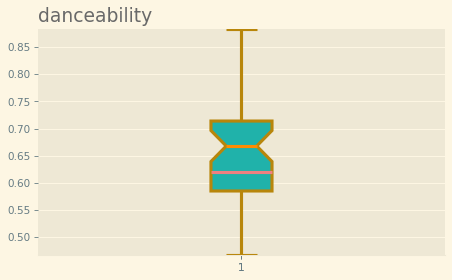

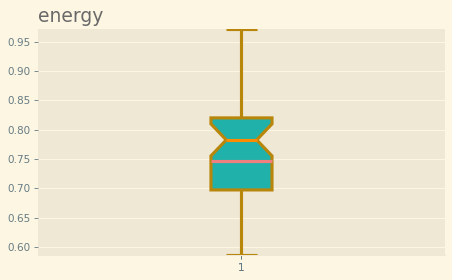

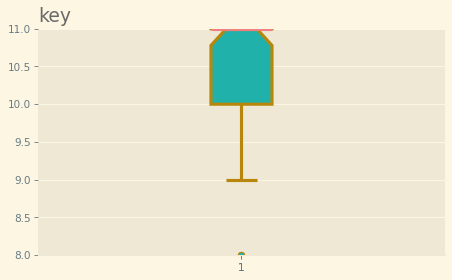

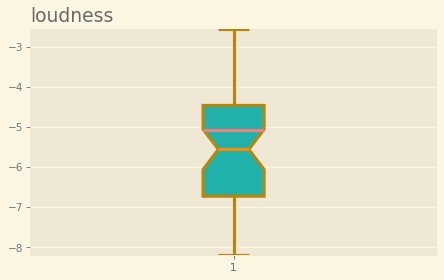

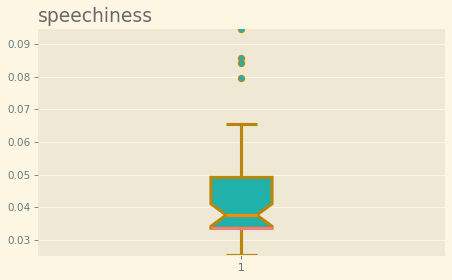

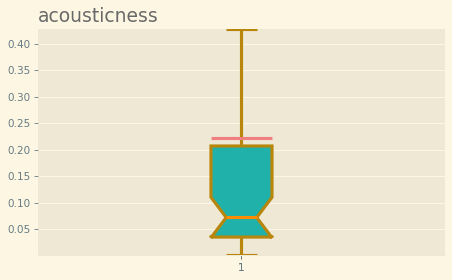

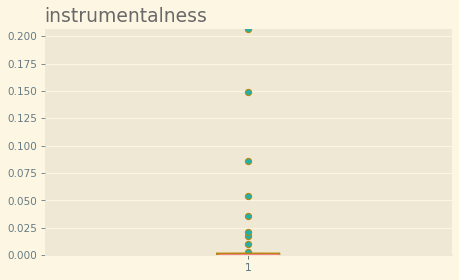

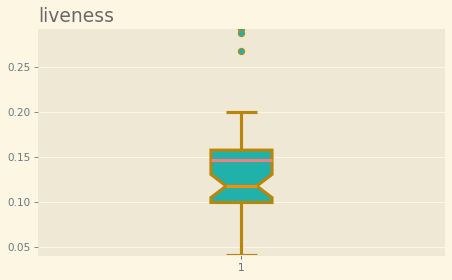

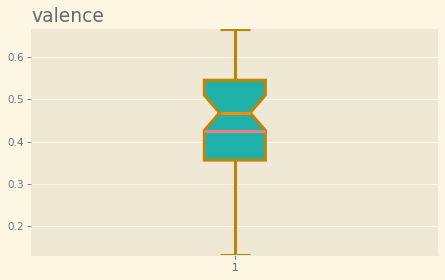

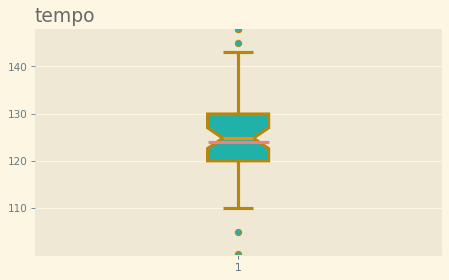

/Users/albertofernandez/miniconda3/envs/proj_final/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Attempting to set identical bottom == top == 4.0 results in singular transformations; automatically expanding.
  app.launch_new_instance()


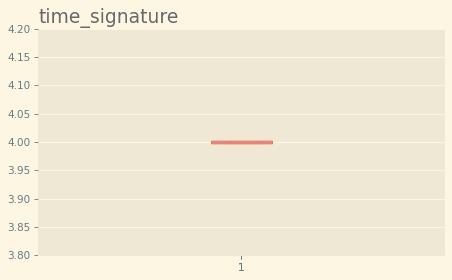

/Users/albertofernandez/miniconda3/envs/proj_final/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Attempting to set identical bottom == top == 1.0 results in singular transformations; automatically expanding.
  app.launch_new_instance()


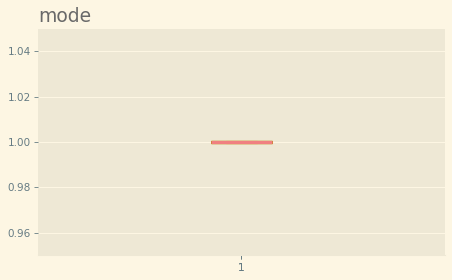

In [149]:
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
boxprops = dict(linewidth=3, color='darkgoldenrod')
plot=['danceability','energy','key','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo','time_signature','mode']
for column in plot:
    fig, ax1 = plt.subplots(nrows=1, figsize=(7,4),dpi=75)
    ax1.boxplot(similar_song.head(50)[column],
        zorder=2,notch=True, patch_artist=True,
            boxprops=dict(linestyle='--', linewidth=3,facecolor='lightseagreen', color='darkgoldenrod'),
            capprops=dict(color='darkgoldenrod',linewidth=3),
            whiskerprops=dict(color='darkgoldenrod',linewidth=3),
            flierprops=dict(marker='o',color='black', markerfacecolor='lightseagreen',markeredgecolor='darkgoldenrod'),
            medianprops=dict(color='darkorange',linewidth=3),
            )
    ax1.boxplot(similar_song.head(1)[column],zorder=2,medianprops=dict(color='lightcoral',linewidth=3))
    ax1.set_ylim([similar_song.head(50)[column].min(), similar_song.head(50)[column].max()]) 
    plt.title(column, 
          fontdict={'family': 'Gotham', 
                    'color' : 'dimgrey',
                    'size': 18})
    plt.show()